In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob
import Ngl
import Nio 
import metpy.calc as mpc
from metpy.units import units


In [2]:
import warnings
warnings.filterwarnings('ignore')


## Read in data from SCAM runs (32 levs and 64 levels)

In [3]:
# Where the files are saved (locally):
dataDir32 = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/AllMomentsSet/'
dataDir64 = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/AllMoments-64levs/'
dirNoMom  = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/HMG_noMomentsPrescribed/'  # 32 levels
dirUseAndre = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/HMG_noMoments_useAndre1978flag/'

# File naming conventions: 
hmg_startFile   = 'FSCAM.T42_T42.arm97.clasp_hmg_startDay'   # 32 and 64 level files *start* the same way
htg_startFile   = 'FSCAM.T42_T42.arm97.clasp_htg_startDay'
noMom_startFile = 'FSCAM.T42_T42.arm97.clasp_hmg_noMoments_startDay'
useAndre_startFile = 'FSCAM.T42_T42.arm97.clasp_hmg_noMoments_useAndreEqns_startDay'

middleFile32    = '_allMoments.cam.h0.2015-' # Default 20 min coupling
middleFile64    = '_64lev_AllMoments.cam.h0.2015-' # Default 20 min coupling
noMom_middle    = '.cam.h0.2015-'
endFile         = '-00000.nc'

# Month/day also factor into naming convention (since these are run for ~2 days and second day is used)
months    = np.ones(31)*6
months[0] = 5
days      = np.arange(0,31)
days[0]   = 31


In [4]:
# Now read in each daily file, and save the appropriate second day to an xr dataset: 

for iDay in range(29):
    
    # Define full file names 
    hmg32file    = dataDir32+hmg_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile32+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
    htg32file    = dataDir32+htg_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile32+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
    hmg64file    = dataDir64+hmg_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile64+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
    htg64file    = dataDir64+htg_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile64+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
    noMomFile    = dirNoMom+noMom_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+noMom_middle+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
    useAndreFile = dirUseAndre+useAndre_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+noMom_middle+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile


    # ---------------------- 
    # Read in 32 levels data
    # ----------------------
    # Read in files with homogeneous surface forcing prescribed 
    with xr.open_dataset(hmg32file, decode_times=True) as hmg32_DS:
        hmg32_DS['time']  = hmg32_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_hmg  = pd.DatetimeIndex(hmg32_DS['time'].values)
        iTimeStart = np.where((times_hmg.day==days[iDay+1]) & (times_hmg.hour==6))[0]
        iTimeEnd   = np.where((times_hmg.day==days[iDay+2]) & (times_hmg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            hmgDS_32 = hmg32_DS.isel(time=iTimeRange)
        else:
            hmgDS_32 = xr.concat([hmgDS_32,hmg32_DS.isel(time=iTimeRange)], dim='time')


    # Read in files with heterogeneous surface forcing prescribed     
    with xr.open_dataset(htg32file, decode_times=True) as htg32_DS:
        htg32_DS['time']  = htg32_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_htg  = pd.DatetimeIndex(htg32_DS['time'].values)
        iTimeStart = np.where((times_htg.day==days[iDay+1]) & (times_htg.hour==6))[0]
        iTimeEnd   = np.where((times_htg.day==days[iDay+2]) & (times_htg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            htgDS_32 = htg32_DS.isel(time=iTimeRange)
        else:
            htgDS_32 = xr.concat([htgDS_32,htg32_DS.isel(time=iTimeRange)], dim='time')
    
    # Read in files with no moments prescribed 
    with xr.open_dataset(noMomFile, decode_times=True) as noMom_DS:
        noMom_DS['time']  = noMom_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_noMom = pd.DatetimeIndex(noMom_DS['time'].values)
        iTimeStart  = np.where((times_noMom.day==days[iDay+1]) & (times_noMom.hour==6))[0]
        iTimeEnd    = np.where((times_noMom.day==days[iDay+2]) & (times_noMom.hour==6))[0]
        iTimeRange  = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            noMomDS = noMom_DS.isel(time=iTimeRange)
        else:
            noMomDS = xr.concat([noMomDS,noMom_DS.isel(time=iTimeRange)], dim='time')
            
    # Read in files with no moments prescribed that use Andre 1978 flag
    with xr.open_dataset(useAndreFile, decode_times=True) as useAndre_DS:
        useAndre_DS['time']  = useAndre_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_useAndre = pd.DatetimeIndex(useAndre_DS['time'].values)
        iTimeStart  = np.where((times_useAndre.day==days[iDay+1]) & (times_useAndre.hour==6))[0]
        iTimeEnd    = np.where((times_useAndre.day==days[iDay+2]) & (times_useAndre.hour==6))[0]
        iTimeRange  = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            useAndreDS = useAndre_DS.isel(time=iTimeRange)
        else:
            useAndreDS = xr.concat([useAndreDS,useAndre_DS.isel(time=iTimeRange)], dim='time')


    # ---------------------- 
    # Read in 64 levels data
    # ----------------------
    # Read in files with homogeneous surface forcing prescribed 
    with xr.open_dataset(hmg64file, decode_times=True) as hmg64_DS:
        hmg64_DS['time']  = hmg64_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_hmg  = pd.DatetimeIndex(hmg64_DS['time'].values)
        iTimeStart = np.where((times_hmg.day==days[iDay+1]) & (times_hmg.hour==6))[0]
        iTimeEnd   = np.where((times_hmg.day==days[iDay+2]) & (times_hmg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            hmgDS_64 = hmg64_DS.isel(time=iTimeRange)
        else:
            hmgDS_64 = xr.concat([hmgDS_64,hmg64_DS.isel(time=iTimeRange)], dim='time')


    # Read in files with heterogeneous surface forcing prescribed     
    with xr.open_dataset(htg64file, decode_times=True) as htg64_DS:
        htg64_DS['time']  = htg64_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_htg  = pd.DatetimeIndex(htg64_DS['time'].values)
        iTimeStart = np.where((times_htg.day==days[iDay+1]) & (times_htg.hour==6))[0]
        iTimeEnd   = np.where((times_htg.day==days[iDay+2]) & (times_htg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            htgDS_64 = htg64_DS.isel(time=iTimeRange)
        else:
            htgDS_64 = xr.concat([htgDS_64,htg64_DS.isel(time=iTimeRange)], dim='time')
    

    print('Done with day %i' % iDay)
    

Done with day 0
Done with day 1
Done with day 2
Done with day 3
Done with day 4
Done with day 5
Done with day 6
Done with day 7
Done with day 8
Done with day 9
Done with day 10
Done with day 11
Done with day 12
Done with day 13
Done with day 14
Done with day 15
Done with day 16
Done with day 17
Done with day 18
Done with day 19
Done with day 20
Done with day 21
Done with day 22
Done with day 23
Done with day 24
Done with day 25
Done with day 26
Done with day 27
Done with day 28


In [5]:
# Also read in the IOP files from Nate:
nateHMGfile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.nc'
nateHTGfile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-htg.nc'

nateHMG = xr.open_dataset(nateHMGfile,decode_times=True)
nateHTG = xr.open_dataset(nateHTGfile,decode_times=True)

nateTime = pd.DatetimeIndex(nateHMG.time.values, tz='UTC')


In [149]:
np.nanmax(abs(nateHMG.SH.values - nateHTG.SH.values))

0.0

**Convert to local time**

In [6]:
# Convert times to a pandas datetime array, with UTC timezone
timesHTG_32 = pd.DatetimeIndex(htgDS_32.time.values, tz='UTC')
timesHMG_32 = pd.DatetimeIndex(hmgDS_32.time.values, tz='UTC')
timesNoMom  = pd.DatetimeIndex(noMomDS.time.values,  tz='UTC')
timesHTG_64 = pd.DatetimeIndex(htgDS_64.time.values, tz='UTC')
timesHMG_64 = pd.DatetimeIndex(hmgDS_64.time.values, tz='UTC')

# Now convert those to Central time 
timesHTG_32local = timesHTG_32.tz_convert(tz='US/Central') 
timesHMG_32local = timesHMG_32.tz_convert(tz='US/Central') 
timesNoMom_local = timesNoMom.tz_convert(tz='US/Central') 
timesHTG_64local = timesHTG_64.tz_convert(tz='US/Central') 
timesHMG_64local = timesHMG_64.tz_convert(tz='US/Central') 

timesNate_local = nateTime.tz_convert(tz='US/Central')

## Interpolate level data to consistent pressure levels

In [7]:
print('32 levels: ', htgDS_32.lev.values)
print()
print('64 levels: ', htgDS_64.lev.values)


32 levels:  [  3.64346569   7.59481965  14.35663225  24.61222     35.92325002
  43.19375008  51.67749897  61.52049825  73.75095785  87.82123029
 103.31712663 121.54724076 142.99403876 168.22507977 197.9080867
 232.82861896 273.91081676 322.24190235 379.10090387 445.9925741
 524.68717471 609.77869481 691.38943031 763.40448111 820.85836865
 859.53476653 887.02024892 912.64454694 936.19839847 957.48547954
 976.32540739 992.55609512]

64 levels:  [  2.94935261   4.33757878   6.31325576   8.87638354  12.25728984
  16.45597466  21.58376854  27.1734478   32.82896281  37.59812564
  41.23337567  45.1541245   49.39599894  53.95899899  58.88049863
  64.16049786  70.27572766  77.22618803  84.26132426  91.38113633
  99.1290845  107.50516877 116.62022583 126.4742557  137.19765469
 148.79042283 161.40594333 175.04421622 189.88571968 205.93045373
 223.39071985 242.26651806 262.80761696 285.01401655 309.17955935
 335.30424535 363.73374611 394.46806163 427.91389674 464.07125145
 503.41855176 545.9557976

In [8]:
# New pressure levels in hPa 
pnew32 = np.arange(700.0,980.0,25.0)
pnew64 = np.arange(700.0,990.0,10.0) 


In [9]:
# ---------------------------------------------------
#   32 levels 
# ---------------------------------------------------
p0mb = htgDS_32.P0.values[0]/100        # mb
# Pull out hya/hyb profiles 
hyam = htgDS_32.hyam.values[0,:]
hybm = htgDS_32.hybm.values[0,:]
hyai = htgDS_32.hyai.values[0,:]
hybi = htgDS_32.hybi.values[0,:]

# Surface pressure with time dimension
PS_htg   = htgDS_32.PS.values              # Pa 
PS_hmg   = hmgDS_32.PS.values              # Pa
PS_noMom = noMomDS.PS.values
PS_useAndre = useAndreDS.PS.values

# Converting HTG variables: 
THLP2_htg32  = Ngl.vinth2p(htgDS_32.THLP2_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
WPTHLP_htg32 = Ngl.vinth2p(htgDS_32.WPTHLP_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
UP2_htg32    = Ngl.vinth2p(htgDS_32.UP2_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
WP2_htg32    = Ngl.vinth2p(htgDS_32.WP2_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
WP3_htg32    = Ngl.vinth2p(htgDS_32.WP3_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
WPRTP_htg32  = Ngl.vinth2p(htgDS_32.WPRTP_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
RTP2_htg32   = Ngl.vinth2p(htgDS_32.RTP2_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
RTPTHLP_htg32   = Ngl.vinth2p(htgDS_32.RTPTHLP_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
WPTHVP_htg32 = Ngl.vinth2p(htgDS_32.WPTHVP_CLUBB.values,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)
WSUB_htg32   = Ngl.vinth2p(htgDS_32.WSUB.values ,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)
T_htg32      = Ngl.vinth2p(htgDS_32.T.values,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)
Q_htg32      = Ngl.vinth2p(htgDS_32.Q.values,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)
OMEGA_htg32  = Ngl.vinth2p(htgDS_32.OMEGA.values ,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)
THETAL_htg32 = Ngl.vinth2p(htgDS_32.THETAL.values,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)
RVMTEND_htg32 = Ngl.vinth2p(htgDS_32.RVMTEND_CLUBB.values,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)

# Converting HMG variables: 
THLP2_hmg32  = Ngl.vinth2p(hmgDS_32.THLP2_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
WPTHLP_hmg32 = Ngl.vinth2p(hmgDS_32.WPTHLP_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
UP2_hmg32    = Ngl.vinth2p(hmgDS_32.UP2_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
WP2_hmg32    = Ngl.vinth2p(hmgDS_32.WP2_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
WP3_hmg32    = Ngl.vinth2p(hmgDS_32.WP3_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
WPRTP_hmg32  = Ngl.vinth2p(hmgDS_32.WPRTP_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
RTP2_hmg32   = Ngl.vinth2p(hmgDS_32.RTP2_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
RTPTHLP_hmg32   = Ngl.vinth2p(hmgDS_32.RTPTHLP_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
WPTHVP_hmg32 = Ngl.vinth2p(hmgDS_32.WPTHVP_CLUBB.values,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)
WSUB_hmg32   = Ngl.vinth2p(hmgDS_32.WSUB.values ,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)
T_hmg32      = Ngl.vinth2p(hmgDS_32.T.values,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)
Q_hmg32      = Ngl.vinth2p(hmgDS_32.Q.values,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)
OMEGA_hmg32  = Ngl.vinth2p(hmgDS_32.OMEGA.values ,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)
THETAL_hmg32 = Ngl.vinth2p(hmgDS_32.THETAL.values,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)
RVMTEND_hmg32 = Ngl.vinth2p(hmgDS_32.RVMTEND_CLUBB.values,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)

# Converting noMoments variables: 
THLP2_noMom  = Ngl.vinth2p(noMomDS.THLP2_CLUBB.values,hyai,hybi,pnew32,PS_noMom,1,p0mb,1,True)
WPTHLP_noMom = Ngl.vinth2p(noMomDS.WPTHLP_CLUBB.values,hyai,hybi,pnew32,PS_noMom,1,p0mb,1,True)
UP2_noMom    = Ngl.vinth2p(noMomDS.UP2_CLUBB.values,hyai,hybi,pnew32,PS_noMom,1,p0mb,1,True)
VP2_noMom    = Ngl.vinth2p(noMomDS.VP2_CLUBB.values,hyai,hybi,pnew32,PS_noMom,1,p0mb,1,True)
UPWP_noMom    = Ngl.vinth2p(noMomDS.UPWP_CLUBB.values,hyai,hybi,pnew32,PS_noMom,1,p0mb,1,True)
WP2_noMom    = Ngl.vinth2p(noMomDS.WP2_CLUBB.values,hyai,hybi,pnew32,PS_noMom,1,p0mb,1,True)
WP3_noMom    = Ngl.vinth2p(noMomDS.WP3_CLUBB.values,hyai,hybi,pnew32,PS_noMom,1,p0mb,1,True)
WPRTP_noMom  = Ngl.vinth2p(noMomDS.WPRTP_CLUBB.values,hyai,hybi,pnew32,PS_noMom,1,p0mb,1,True)
RTP2_noMom   = Ngl.vinth2p(noMomDS.RTP2_CLUBB.values,hyai,hybi,pnew32,PS_noMom,1,p0mb,1,True)
RTPTHLP_noMom = Ngl.vinth2p(noMomDS.RTPTHLP_CLUBB.values,hyai,hybi,pnew32,PS_noMom,1,p0mb,1,True)
WPTHVP_noMom = Ngl.vinth2p(noMomDS.WPTHVP_CLUBB.values,hyam,hybm,pnew32,PS_noMom,1,p0mb,1,True)
WSUB_noMom   = Ngl.vinth2p(noMomDS.WSUB.values ,hyam,hybm,pnew32,PS_noMom,1,p0mb,1,True)
T_noMom      = Ngl.vinth2p(noMomDS.T.values,hyam,hybm,pnew32,PS_noMom,1,p0mb,1,True)
Q_noMom      = Ngl.vinth2p(noMomDS.Q.values,hyam,hybm,pnew32,PS_noMom,1,p0mb,1,True)
OMEGA_noMom  = Ngl.vinth2p(noMomDS.OMEGA.values ,hyam,hybm,pnew32,PS_noMom,1,p0mb,1,True)
THETAL_noMom = Ngl.vinth2p(noMomDS.THETAL.values,hyam,hybm,pnew32,PS_noMom,1,p0mb,1,True)
RVMTEND_noMom = Ngl.vinth2p(noMomDS.RVMTEND_CLUBB.values,hyam,hybm,pnew32,PS_noMom,1,p0mb,1,True)

# Converting useAndre variables: 
THLP2_useAndre = Ngl.vinth2p(useAndreDS.THLP2_CLUBB.values,hyai,hybi,pnew32,PS_useAndre,1,p0mb,1,True)
WPTHLP_useAndre = Ngl.vinth2p(useAndreDS.WPTHLP_CLUBB.values,hyai,hybi,pnew32,PS_useAndre,1,p0mb,1,True)
UP2_useAndre    = Ngl.vinth2p(useAndreDS.UP2_CLUBB.values,hyai,hybi,pnew32,PS_useAndre,1,p0mb,1,True)
VP2_useAndre    = Ngl.vinth2p(useAndreDS.VP2_CLUBB.values,hyai,hybi,pnew32,PS_useAndre,1,p0mb,1,True)
UPWP_useAndre    = Ngl.vinth2p(useAndreDS.UPWP_CLUBB.values,hyai,hybi,pnew32,PS_useAndre,1,p0mb,1,True)
WP2_useAndre    = Ngl.vinth2p(useAndreDS.WP2_CLUBB.values,hyai,hybi,pnew32,PS_useAndre,1,p0mb,1,True)
WP3_useAndre    = Ngl.vinth2p(useAndreDS.WP3_CLUBB.values,hyai,hybi,pnew32,PS_useAndre,1,p0mb,1,True)
WPRTP_useAndre  = Ngl.vinth2p(useAndreDS.WPRTP_CLUBB.values,hyai,hybi,pnew32,PS_useAndre,1,p0mb,1,True)
RTP2_useAndre   = Ngl.vinth2p(useAndreDS.RTP2_CLUBB.values,hyai,hybi,pnew32,PS_useAndre,1,p0mb,1,True)
RTPTHLP_useAndre = Ngl.vinth2p(useAndreDS.RTPTHLP_CLUBB.values,hyai,hybi,pnew32,PS_useAndre,1,p0mb,1,True)
WPTHVP_useAndre = Ngl.vinth2p(useAndreDS.WPTHVP_CLUBB.values,hyam,hybm,pnew32,PS_useAndre,1,p0mb,1,True)
WSUB_useAndre   = Ngl.vinth2p(useAndreDS.WSUB.values ,hyam,hybm,pnew32,PS_useAndre,1,p0mb,1,True)
T_useAndre      = Ngl.vinth2p(useAndreDS.T.values,hyam,hybm,pnew32,PS_useAndre,1,p0mb,1,True)
Q_useAndre      = Ngl.vinth2p(useAndreDS.Q.values,hyam,hybm,pnew32,PS_useAndre,1,p0mb,1,True)
OMEGA_useAndre  = Ngl.vinth2p(useAndreDS.OMEGA.values ,hyam,hybm,pnew32,PS_useAndre,1,p0mb,1,True)
THETAL_useAndre = Ngl.vinth2p(useAndreDS.THETAL.values,hyam,hybm,pnew32,PS_useAndre,1,p0mb,1,True)
RVMTEND_useAndre = Ngl.vinth2p(useAndreDS.RVMTEND_CLUBB.values,hyam,hybm,pnew32,PS_useAndre,1,p0mb,1,True)

# ---------------------------------------------------
#   64 levels 
# ---------------------------------------------------
p0mb = htgDS_64.P0.values[0]/100        # mb
# Pull out hya/hyb profiles 
hyam = htgDS_64.hyam.values[0,:]
hybm = htgDS_64.hybm.values[0,:]
hyai = htgDS_64.hyai.values[0,:]
hybi = htgDS_64.hybi.values[0,:]

# Surface pressure with time dimension
PS_htg   = htgDS_64.PS.values              # Pa 
PS_hmg   = hmgDS_64.PS.values              # Pa

# Converting HTG variables: 
THLP2_htg64  = Ngl.vinth2p(htgDS_64.THLP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WPTHLP_htg64 = Ngl.vinth2p(htgDS_64.WPTHLP_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
UP2_htg64    = Ngl.vinth2p(htgDS_64.UP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
VP2_htg64    = Ngl.vinth2p(htgDS_64.VP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WP2_htg64    = Ngl.vinth2p(htgDS_64.WP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WP3_htg64    = Ngl.vinth2p(htgDS_64.WP3_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WPRTP_htg64  = Ngl.vinth2p(htgDS_64.WPRTP_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
RTP2_htg64   = Ngl.vinth2p(htgDS_64.RTP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
RTPTHLP_htg64   = Ngl.vinth2p(htgDS_64.RTPTHLP_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WPTHVP_htg64 = Ngl.vinth2p(htgDS_64.WPTHVP_CLUBB.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
WSUB_htg64   = Ngl.vinth2p(htgDS_64.WSUB.values ,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
T_htg64      = Ngl.vinth2p(htgDS_64.T.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
Q_htg64      = Ngl.vinth2p(htgDS_64.Q.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
OMEGA_htg64  = Ngl.vinth2p(htgDS_64.OMEGA.values ,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
U_htg64  = Ngl.vinth2p(htgDS_64.U.values ,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
V_htg64  = Ngl.vinth2p(htgDS_64.V.values ,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
THETAL_htg64 = Ngl.vinth2p(htgDS_64.THETAL.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
RVMTEND_htg64 = Ngl.vinth2p(htgDS_64.RVMTEND_CLUBB.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
STEND_htg64   = Ngl.vinth2p(htgDS_64.STEND_CLUBB.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
TKE_htg64     = Ngl.vinth2p(htgDS_64.TKE.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)

# Converting HMG variables: 
THLP2_hmg64  = Ngl.vinth2p(hmgDS_64.THLP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WPTHLP_hmg64 = Ngl.vinth2p(hmgDS_64.WPTHLP_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
UP2_hmg64    = Ngl.vinth2p(hmgDS_64.UP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
VP2_hmg64    = Ngl.vinth2p(hmgDS_64.VP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WP2_hmg64    = Ngl.vinth2p(hmgDS_64.WP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WP3_hmg64    = Ngl.vinth2p(hmgDS_64.WP3_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WPRTP_hmg64  = Ngl.vinth2p(hmgDS_64.WPRTP_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
RTP2_hmg64   = Ngl.vinth2p(hmgDS_64.RTP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
RTPTHLP_hmg64   = Ngl.vinth2p(hmgDS_64.RTPTHLP_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WPTHVP_hmg64 = Ngl.vinth2p(hmgDS_64.WPTHVP_CLUBB.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
WSUB_hmg64   = Ngl.vinth2p(hmgDS_64.WSUB.values ,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
T_hmg64      = Ngl.vinth2p(hmgDS_64.T.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
Q_hmg64      = Ngl.vinth2p(hmgDS_64.Q.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
OMEGA_hmg64  = Ngl.vinth2p(hmgDS_64.OMEGA.values ,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
U_hmg64  = Ngl.vinth2p(hmgDS_64.U.values ,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
V_hmg64  = Ngl.vinth2p(hmgDS_64.V.values ,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
THETAL_hmg64 = Ngl.vinth2p(hmgDS_64.THETAL.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
RVMTEND_hmg64 = Ngl.vinth2p(hmgDS_64.RVMTEND_CLUBB.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
STEND_hmg64   = Ngl.vinth2p(hmgDS_64.STEND_CLUBB.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
TKE_hmg64    = Ngl.vinth2p(hmgDS_64.TKE.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)



In [10]:
# Compute TKE using equation 9.6 in Wallace and Hobbs: 
#   TKE = 0.5 * (up2 + vp2 + wp3)
# TKE_hmg64 = 0.5*(UP2_hmg64 + VP2_hmg64 + WP2_hmg64)
# TKE_htg64 = 0.5*(UP2_htg64 + VP2_htg64 + WP2_htg64)

# Following Rich's advice, just use the vertical component for this 
TKE_hmg64 = 0.5*(WP2_hmg64)
TKE_htg64 = 0.5*(WP2_htg64)



In [67]:
# Convert pressure to height (nabbed from Rich's script) -- HMG
p0 = hmgDS_64['P0'].values[0]

plevm_hmg = hmgDS_64['hyam']*p0 + hmgDS_64['hybm']*hmgDS_64['PS'].isel(lat=0,lon=0) # Mid level
plevm_hmg.attrs['units'] = "Pa"

# Height with standard atmosphere
zlevm_hmg = plevm_hmg
zlevm_vals_hmg = 1000.*np.asarray(mpc.pressure_to_height_std(plevm_hmg)) # Units of [m] after multiplied 
zlevm_hmg = plevm_hmg.copy(deep=True)
zlevm_hmg[:,:] = zlevm_vals_hmg



In [68]:
# Convert pressure to height (nabbed from Rich's script)-- HTG
p0 = ['P0'].values[0]

plevm_htg = htgDS_64['hyam']*p0 + htgDS_64['hybm']*htgDS_64['PS'].isel(lat=0,lon=0) # Mid level
plevm_htg.attrs['units'] = "Pa"

# Height with standard atmosphere
zlevm_htg = plevm_htg
zlevm_vals_htg = 1000.*np.asarray(mpc.pressure_to_height_std(plevm_htg)) # Units of [m] after multiplied 
zlevm_htg = plevm_htg.copy(deep=True)
zlevm_htg[:,:] = zlevm_vals_htg

In [94]:
# Also from Rich's script...
pbl_var = 'Q'

pvar = hmgDS_64[pbl_var].isel(lat=0,lon=0)
pvar['lev'] = zlevm_hmg[0,:].values
dvardz = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

dvardz.loc[:,200:] = 0.  # Restrict to a specificheight region
dvardz.loc[:,:3000.] = 0
    
# dvardz_kmin = dvardz.argmin(axis=1) # Find the index of the maxium in the vertical
# dvardz_zmin = dvardz.lev[dvardz_kmin[:]] # Height level of max/min level.
# dvardz_ptop = dvardz.min(axis=1) # Actual value at min/max level.

for iT in range(nT):
    iLevs_hmg = np.where((zlevm_hmg[iT,:]>=200) & (zlevm_hmg[iT,:]<=3000))[0]
    maxLev_hmg = np.where(dvardz[iT,iLevs_hmg]==np.nanmax(dvardz[iT,iLevs_hmg]))[0]
    PBLdepth_hmg[iT] = zlevm_hmg[iT,iLevs_hmg[maxLev_hmg[0]]]
        

In [95]:
# Also from Rich's script...
pbl_var = 'Q'

pvar = htgDS_64[pbl_var].isel(lat=0,lon=0)
pvar['lev'] = zlevm_htg[0,:].values
dvardz = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

dvardz.loc[:,200:] = 0.  # Restrict to a specificheight region
dvardz.loc[:,:3000.] = 0
    
# dvardz_kmin = dvardz.argmin(axis=1) # Find the index of the maxium in the vertical
# dvardz_zmin = dvardz.lev[dvardz_kmin[:]] # Height level of max/min level.
# dvardz_ptop = dvardz.min(axis=1) # Actual value at min/max level.

for iT in range(nT):
    iLevs_htg = np.where((zlevm_htg[iT,:]>=200) & (zlevm_htg[iT,:]<=3000))[0]
    maxLev_htg = np.where(dvardz[iT,iLevs_htg]==np.nanmax(dvardz[iT,iLevs_htg]))[0]
    PBLdepth_htg[iT] = zlevm_htg[iT,iLevs_htg[maxLev_htg[0]]]
        

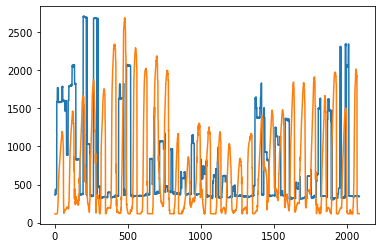

In [93]:
plt.plot(PBLdepth_hmg)
plt.plot(np.squeeze(hmgDS_64.PBLH.values))


In [69]:
## Look for max dQ/dz as top of PBL instead of using the PBLH from the model 
# Use zlevm_h?g computed above 

# What is dQ/dZ then? 
nT   = np.shape(Z3_htg64)[0]
nLev = np.shape(Z3_htg64)[1]

dQdz_hmg = np.full([nT, nLev], np.nan)
PBLdepth_hmg = np.full([nT], np.nan)

dQdz_htg = np.full([nT, nLev], np.nan)
PBLdepth_htg = np.full([nT], np.nan)

for iT in range(nT):
    for iLev in range(nLev-1):
        dQ_hmg = np.squeeze(hmgDS_64.Q.values)[iT, iLev+1] - np.squeeze(hmgDS_64.Q.values)[iT, iLev]
        dZ_hmg = zlevm_hmg[iT,iLev+1] - zlevm_hmg[iT,iLev]
        dQdz_hmg[iT,iLev+1] = dQ_hmg/dZ_hmg
        
        dQ_htg = np.squeeze(htgDS_64.Q.values)[iT, iLev+1] - np.squeeze(htgDS_64.Q.values)[iT, iLev]
        dZ_htg = zlevm_htg[iT,iLev+1] - zlevm_htg[iT,iLev]
        dQdz_htg[iT,iLev+1] = dQ_htg/dZ_htg
        
    iLevs_hmg = np.where((zlevm_hmg[iT,:]>=200) & (zlevm_hmg[iT,:]<=3000))[0]
    maxLev_hmg = np.where(dQdz_hmg[iT,iLevs_hmg]==np.nanmax(dQdz_hmg[iT,iLevs_hmg]))[0]
    PBLdepth_hmg[iT] = zlevm_hmg[iT,iLevs_hmg[maxLev_hmg[0]]]
    
    iLevs_htg        = np.where((zlevm_htg[iT,:]>=200) & (zlevm_htg[iT,:]<=3000))[0]
    maxLev_htg       = np.where(dQdz_htg[iT,iLevs_htg]==np.nanmax(dQdz_htg[iT,iLevs_htg]))[0]
    PBLdepth_htg[iT] = zlevm_htg[iT,iLevs_htg[maxLev_htg[0]]]



(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


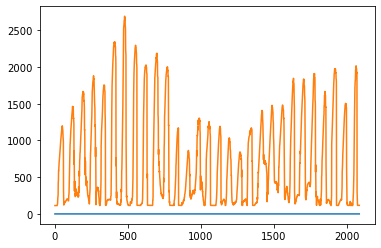

In [86]:
plt.plot(dvardz_ptop)
plt.plot(np.squeeze(hmgDS_64.PBLH.values))

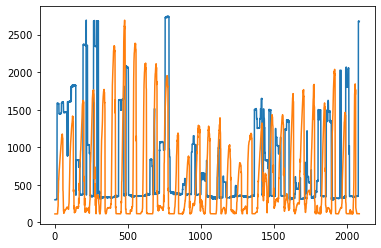

In [71]:
plt.plot(PBLdepth_htg)
plt.plot(np.squeeze(htgDS_64.PBLH.values))


In [13]:
## Use MetPy to convert omega to vertical velocity 
#      (assuming dry air rather than using virtual temperature correction)

Omega_hmg64 = np.squeeze(OMEGA_hmg64) * units('Pa/s')
Omega_htg64 = np.squeeze(OMEGA_htg64) * units('Pa/s')

presurreLevs = pnew64 * units('hPa')

Temp_hmg64 = np.squeeze(T_hmg64) * units('K')
Temp_htg64 = np.squeeze(T_htg64) * units('K')

print('Units added to all fields...')

w_hmg64 = mpc.vertical_velocity(Omega_hmg64, presurreLevs, Temp_hmg64)
w_htg64 = mpc.vertical_velocity(Omega_htg64, presurreLevs, Temp_htg64)

print('W computed from Omega')


Units added to all fields...
W computed from Omega


In [131]:
np.shape(U_hmg64)

(2088, 29)

In [130]:
np.shape(TKE_htg64)

(2088,)

## Comparison over full period (or longer subsets)

In [9]:
# Mean diurnal PBLH cycle?
meanDiurnal_HTG32 = htgDS_32.groupby("time.hour").mean()
meanDiurnal_HMG32 = hmgDS_32.groupby("time.hour").mean()

meanDiurnal_HTG64 = htgDS_64.groupby("time.hour").mean()
meanDiurnal_HMG64 = hmgDS_64.groupby("time.hour").mean()

meanDiurnal_noMom = noMomDS.groupby("time.hour").mean()

meanDiurnal_useAndre = useAndreDS.groupby("time.hour").mean()


Text(0, 0.5, 'PBLH [m]')

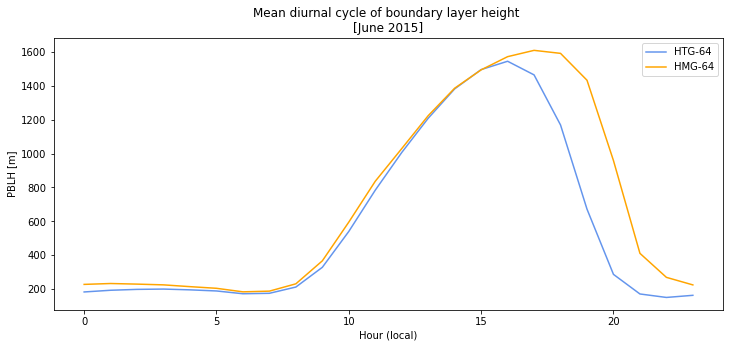

In [10]:
# Easier to plot in local time, so let's double up on the diurnal cycle,
#  Then plot the correct section representing 12a-12a
# 
# CDT to UTC: 12a CDT = 5a UTC, so 5 hour offset 
htg32_diurnalPBL_double = np.full([48], np.nan)
htg32_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_HTG32.PBLH.values)
htg32_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_HTG32.PBLH.values)

hmg32_diurnalPBL_double = np.full([48], np.nan)
hmg32_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_HMG32.PBLH.values)
hmg32_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_HMG32.PBLH.values)

htg64_diurnalPBL_double = np.full([48], np.nan)
htg64_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_HTG64.PBLH.values)
htg64_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_HTG64.PBLH.values)

hmg64_diurnalPBL_double = np.full([48], np.nan)
hmg64_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_HMG64.PBLH.values)
hmg64_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_HMG64.PBLH.values)

noMom_diurnalPBL_double = np.full([48], np.nan)
noMom_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_noMom.PBLH.values)
noMom_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_noMom.PBLH.values)

useAndre_diurnalPBL_double = np.full([48], np.nan)
useAndre_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_useAndre.PBLH.values)
useAndre_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_useAndre.PBLH.values)

hoursDouble = np.full([48],np.nan)
hoursDouble[0:24] = meanDiurnal_HTG32.hour.values
hoursDouble[24::] = meanDiurnal_HTG32.hour.values+24

fig, ax1 = plt.subplots(1,1, figsize=(12, 5), 
                     facecolor='w', edgecolor='k')

#ax1.plot(meanDiurnal_HTG32.hour.values,htg32_diurnalPBL_double[5:29],'b',label='HTG-32')
#ax1.plot(meanDiurnal_HTG32.hour.values,hmg32_diurnalPBL_double[5:29],'r',label='HMG-32')
ax1.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBL_double[5:29],color='cornflowerblue',label='HTG-64')
ax1.plot(meanDiurnal_HTG32.hour.values,hmg64_diurnalPBL_double[5:29],color='orange',label='HMG-64')
#ax1.plot(meanDiurnal_HTG32.hour.values,noMom_diurnalPBL_double[5:29],color='g',label='No Moments')
# ax1.plot(timesHTG_old,np.squeeze(htgOldDS.PBLH.values)[:],color='cyan',label='HET-old',alpha=0.9)
# ax1.plot(timesHMG_old,np.squeeze(hmgOldDS.PBLH.values)[:],color='violet',label='HOM-old',alpha=0.6)
ax1.legend()
ax1.set_title('Mean diurnal cycle of boundary layer height \n[June 2015]')
ax1.set_xlabel('Hour (local)')
ax1.set_ylabel('PBLH [m]')
#ax1.set_ylim([-0.1e-6, 1.3e-6])


Text(0, 0.5, 'PBLH [m]')

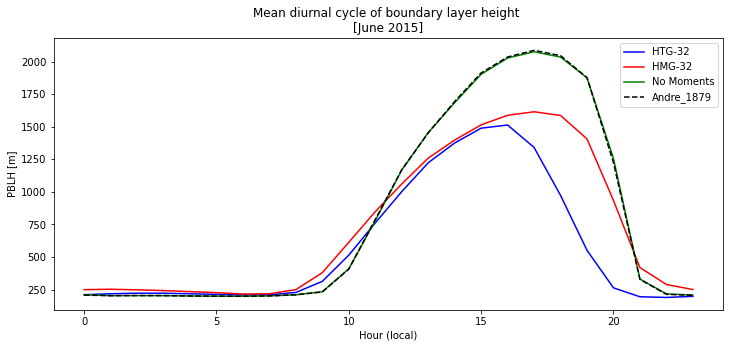

In [53]:
fig, ax1 = plt.subplots(1,1, figsize=(12, 5), 
                     facecolor='w', edgecolor='k')


ax1.plot(meanDiurnal_HTG32.hour.values,htg32_diurnalPBL_double[5:29],color='b',label='HTG-32')
ax1.plot(meanDiurnal_HTG32.hour.values,hmg32_diurnalPBL_double[5:29],color='r',label='HMG-32')
ax1.plot(meanDiurnal_HTG32.hour.values,noMom_diurnalPBL_double[5:29],color='g',label='No Moments')
ax1.plot(meanDiurnal_HTG32.hour.values,useAndre_diurnalPBL_double[5:29],color='k',linestyle='--',label='Andre_1879')


#ax1.plot(timesNoMom,np.squeeze(noMomDS.PBLH.values)[:],'g',label='NoMoments',alpha=0.6)
# ax1.plot(timesHTG_old,np.squeeze(htgOldDS.PBLH.values)[:],color='cyan',label='HET-old',alpha=0.9)
# ax1.plot(timesHMG_old,np.squeeze(hmgOldDS.PBLH.values)[:],color='violet',label='HOM-old',alpha=0.6)
ax1.legend()
ax1.set_title('Mean diurnal cycle of boundary layer height \n[June 2015]')
ax1.set_xlabel('Hour (local)')
ax1.set_ylabel('PBLH [m]')
#ax1.set_ylim([-0.1e-6, 1.3e-6])



(16587.0, 16616.0)

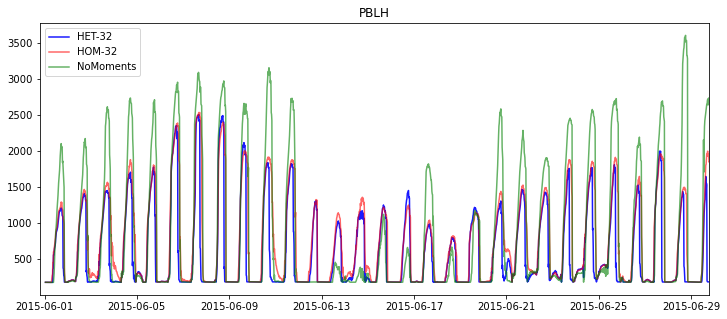

In [243]:
fig, ax1 = plt.subplots(1,1, figsize=(12, 5), 
                     facecolor='w', edgecolor='k')


ax1.plot(timesHTG_32local,np.squeeze(htgDS_32.PBLH.values)[:],'b',label='HET-32',alpha=0.9)
ax1.plot(timesHTG_32local,np.squeeze(hmgDS_32.PBLH.values)[:],'r',label='HOM-32',alpha=0.6)
ax1.plot(timesNoMom_local,np.squeeze(noMomDS.PBLH.values)[:],'g',label='NoMoments',alpha=0.6)
# ax1.plot(timesHTG_old,np.squeeze(htgOldDS.PBLH.values)[:],color='cyan',label='HET-old',alpha=0.9)
# ax1.plot(timesHMG_old,np.squeeze(hmgOldDS.PBLH.values)[:],color='violet',label='HOM-old',alpha=0.6)
ax1.legend()
ax1.set_title('PBLH')
ax1.set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,30))
#ax1.set_ylim([-0.1e-6, 1.3e-6])




(16587.0, 16616.0)

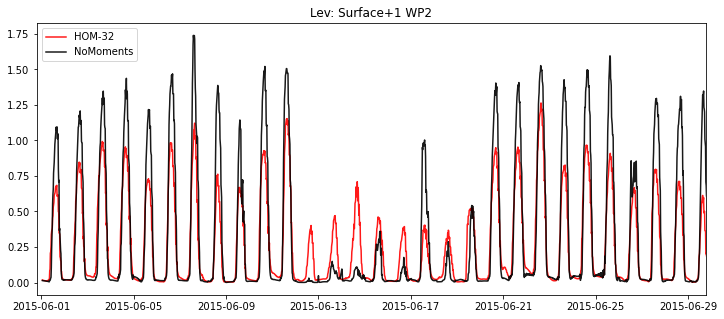

In [18]:
fig, ax1 = plt.subplots(1,1, figsize=(12, 5), 
                     facecolor='w', edgecolor='k')


#ax1.plot(timesHTG_32local,np.squeeze(htgDS_32.WP2_CLUBB.values)[:,-1],'b',label='HET-32',alpha=0.9)
ax1.plot(timesHTG_32local,np.squeeze(hmgDS_32.WP2_CLUBB.values)[:,-2],'r',label='HOM-32',alpha=0.9)
ax1.plot(timesNoMom_local,np.squeeze(noMomDS.WP2_CLUBB.values)[:,-2],color='k',label='NoMoments',alpha=0.9)
# ax1.plot(timesHTG_old,np.squeeze(htgOldDS.PBLH.values)[:],color='cyan',label='HET-old',alpha=0.9)
# ax1.plot(timesHMG_old,np.squeeze(hmgOldDS.PBLH.values)[:],color='violet',label='HOM-old',alpha=0.6)
ax1.legend()
ax1.set_title('Lev: Surface+1 WP2')
ax1.set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,30))
#ax1.set_ylim([-0.1e-6, 1.3e-6])





In [21]:
np.shape(WP2_noMom)

(2088, 12, 1, 1)

In [23]:
noMomDS.WP2_CLUBB

<xarray.DataArray 'WP2_CLUBB' (time: 2088, ilev: 33, lat: 1, lon: 1)>
array([[[[0.0004    ]],

        [[0.0004    ]],

        [[0.0004    ]],

        ...,

        [[0.00465468]],

        [[0.01376306]],

        [[0.07815509]]],


       [[[0.0004    ]],

        [[0.0004    ]],

        [[0.0004    ]],
...
        [[0.00381525]],

        [[0.0013741 ]],

        [[0.00998725]]],


       [[[0.0004    ]],

        [[0.0004    ]],

        [[0.0004    ]],

        ...,

        [[0.00336655]],

        [[0.0012928 ]],

        [[0.01004553]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 36.61
  * lon      (lon) float64 262.5
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
  * time     (time) datetime64[ns] 2015-06-01T06:00:00 ... 2015-06-30T05:40:00
Attributes:
    mdims:         2
    units:         m2/s2
    long_name:     Vertical Velocity Variance
    cell_methods:  time: mean

Text(0.5, 1.0, '8-10a Mean \nTemperature Variance')

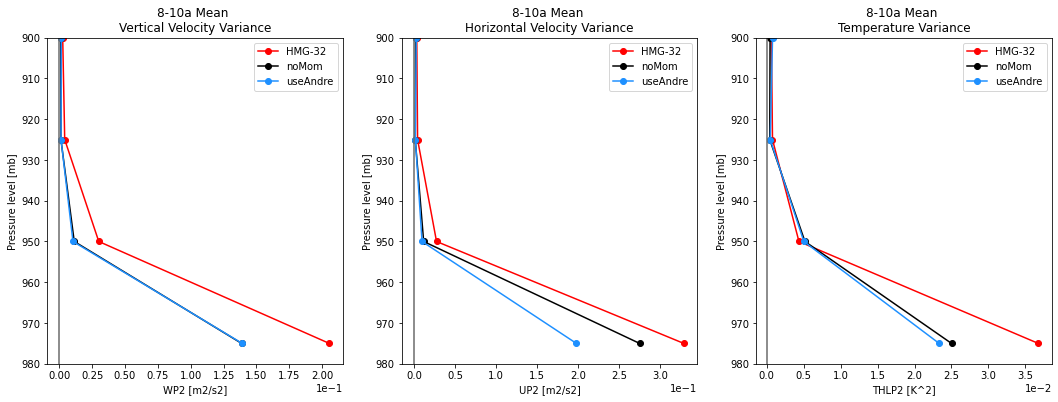

In [15]:
# Plot mean vertical profiles in morning? (8-10a local)
iMorning     = np.where((timesHMG_32local.hour>=8) & (timesHMG_32local.hour<10))[0]
#iMorning     = np.where((timesHMG_32local.hour>=14) & (timesHMG_32local.hour<17))[0]

fig, axs_all = plt.subplots(1,3, figsize=(18, 6),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)


axs[0].plot(np.nanmean(np.squeeze(WP2_hmg32)[iMorning,:], axis=0), pnew32,'o-',color='r',label='HMG-32')
axs[0].plot(np.nanmean(np.squeeze(WP2_noMom)[iMorning,:], axis=0), pnew32,'o-',color='k',label='noMom')
axs[0].plot(np.nanmean(np.squeeze(WP2_useAndre)[iMorning,:], axis=0), pnew32,'o-',color='dodgerblue',label='useAndre')
axs[0].axvline(0,color='dimgrey')
axs[0].set_ylim([900,980])
axs[0].invert_yaxis()
axs[0].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[0].set_ylabel('Pressure level [mb]')
axs[0].set_xlabel('WP2 [m2/s2]')
axs[0].set_title('8-10a Mean \nVertical Velocity Variance')


axs[1].plot(np.nanmean(np.squeeze(UP2_hmg32)[iMorning,:], axis=0), pnew32,'o-',color='r',label='HMG-32')
axs[1].plot(np.nanmean(np.squeeze(UP2_noMom)[iMorning,:], axis=0), pnew32,'o-',color='k',label='noMom')
axs[1].plot(np.nanmean(np.squeeze(UP2_useAndre)[iMorning,:], axis=0), pnew32,'o-',color='dodgerblue',label='useAndre')
axs[1].axvline(0,color='dimgrey')
axs[1].set_ylim([900,980])
axs[1].invert_yaxis()
axs[1].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[1].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[1].set_ylabel('Pressure level [mb]')
axs[1].set_xlabel('UP2 [m2/s2]')
axs[1].set_title('8-10a Mean \nHorizontal Velocity Variance')

axs[2].plot(np.nanmean(np.squeeze(THLP2_hmg32)[iMorning,:], axis=0), pnew32,'o-',color='r',label='HMG-32')
axs[2].plot(np.nanmean(np.squeeze(THLP2_noMom)[iMorning,:], axis=0), pnew32,'o-',color='k',label='noMom')
axs[2].plot(np.nanmean(np.squeeze(THLP2_useAndre)[iMorning,:], axis=0), pnew32,'o-',color='dodgerblue',label='useAndre')
axs[2].axvline(0,color='dimgrey')
axs[2].set_ylim([900,980])
axs[2].invert_yaxis()
axs[2].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[2].set_ylabel('Pressure level [mb]')
axs[2].set_xlabel('THLP2 [K^2]')
axs[2].set_title('8-10a Mean \nTemperature Variance')


Text(0.5, 1.0, '2-5p Mean \nMoisture Flux')

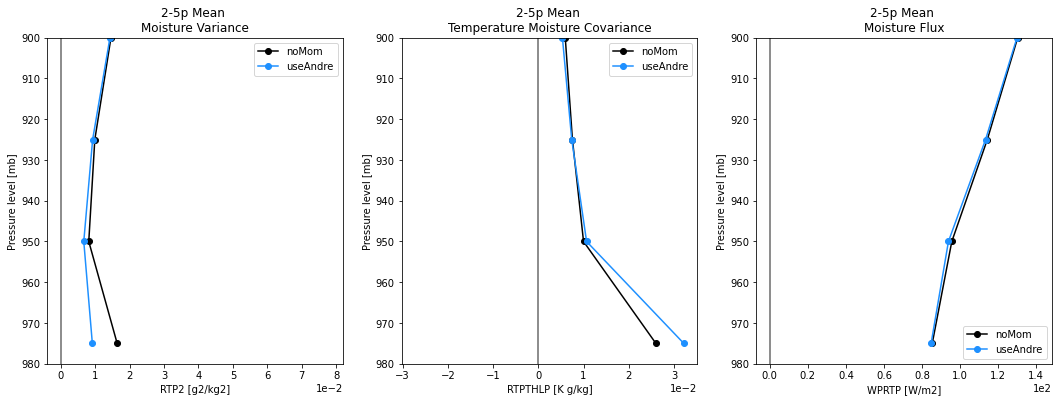

In [19]:
# Plot mean vertical profiles in morning? (8-10a local)
#iMorning     = np.where((timesHMG_32local.hour>=8) & (timesHMG_32local.hour<10))[0]
iMorning     = np.where((timesHMG_32local.hour>=14) & (timesHMG_32local.hour<17))[0]

fig, axs_all = plt.subplots(1,3, figsize=(18, 6),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)


# axs[0].plot(np.nanmean(np.squeeze(RTP2_hmg32)[iMorning,:], axis=0), pnew32,'o-',color='r',label='HMG-32')
axs[0].plot(np.nanmean(np.squeeze(RTP2_noMom)[iMorning,:], axis=0), pnew32,'o-',color='k',label='noMom')
axs[0].plot(np.nanmean(np.squeeze(RTP2_useAndre)[iMorning,:], axis=0), pnew32,'o-',color='dodgerblue',label='useAndre')
axs[0].axvline(0,color='dimgrey')
axs[0].set_ylim([900,980])
axs[0].invert_yaxis()
axs[0].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[0].set_ylabel('Pressure level [mb]')
axs[0].set_xlabel('RTP2 [g2/kg2]')
axs[0].set_title('2-5p Mean \nMoisture Variance')


# axs[1].plot(np.nanmean(np.squeeze(RTPTHLP_hmg32)[iMorning,:], axis=0), pnew32,'o-',color='r',label='HMG-32')
axs[1].plot(np.nanmean(np.squeeze(RTPTHLP_noMom)[iMorning,:], axis=0), pnew32,'o-',color='k',label='noMom')
axs[1].plot(np.nanmean(np.squeeze(RTPTHLP_useAndre)[iMorning,:], axis=0), pnew32,'o-',color='dodgerblue',label='useAndre')
axs[1].axvline(0,color='dimgrey')
axs[1].set_ylim([900,980])
axs[1].invert_yaxis()
axs[1].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[1].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[1].set_ylabel('Pressure level [mb]')
axs[1].set_xlabel('RTPTHLP [K g/kg]')
axs[1].set_title('2-5p Mean \nTemperature Moisture Covariance')

# axs[2].plot(np.nanmean(np.squeeze(WPRTP_hmg32)[iMorning,:], axis=0), pnew32,'o-',color='r',label='HMG-32')
axs[2].plot(np.nanmean(np.squeeze(WPRTP_noMom)[iMorning,:], axis=0), pnew32,'o-',color='k',label='noMom')
axs[2].plot(np.nanmean(np.squeeze(WPRTP_useAndre)[iMorning,:], axis=0), pnew32,'o-',color='dodgerblue',label='useAndre')
axs[2].axvline(0,color='dimgrey')
axs[2].set_ylim([900,980])
axs[2].invert_yaxis()
axs[2].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[2].set_ylabel('Pressure level [mb]')
axs[2].set_xlabel('WPRTP [W/m2]')
axs[2].set_title('2-5p Mean \nMoisture Flux')



In [25]:
print(pnew32)
print()
print(pnew32[-3::])

[700. 725. 750. 775. 800. 825. 850. 875. 900. 925. 950. 975.]

[925. 950. 975.]


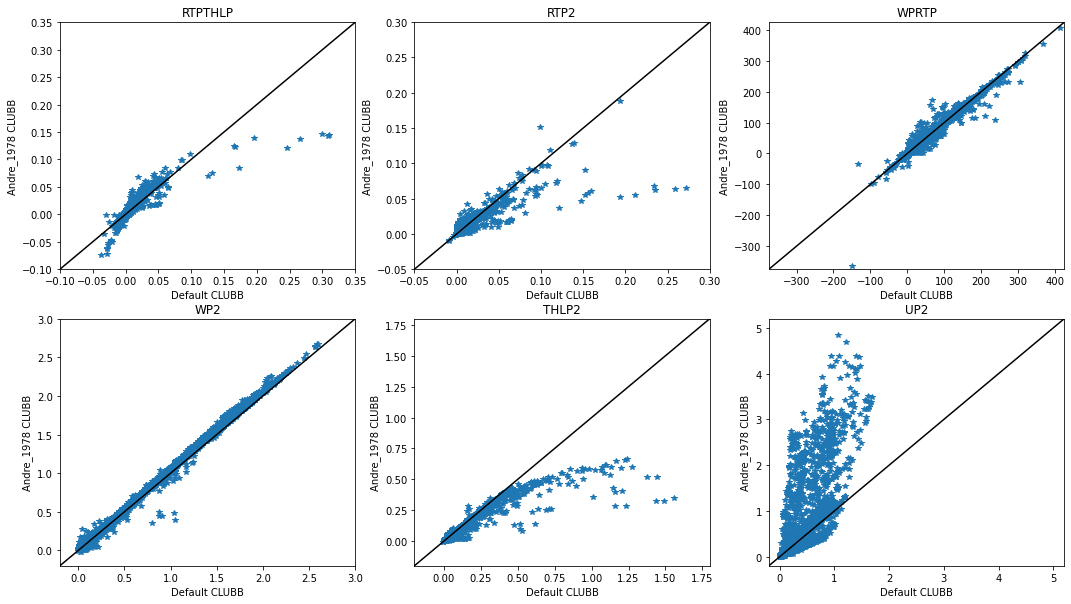

In [46]:
## Scatter plot of lowest 3-model levels, all days: noMom vs. useAndre

nTimes=np.shape(RTPTHLP_noMom)[0]

fig, axs_all = plt.subplots(2,3, figsize=(18, 10),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.2)


axs[0].plot(np.reshape(RTPTHLP_noMom[:,-3::,:,:], 3*nTimes), np.reshape(RTPTHLP_useAndre[:,-3::,:,:], 3*nTimes),'*')
axs[0].set_title('RTPTHLP')
axs[0].set_xlabel('Default CLUBB')
axs[0].set_ylabel('Andre_1978 CLUBB')
axs[0].set_ylim([-0.1, 0.35])
axs[0].set_xlim([-0.1, 0.35])
axs[0].plot([-0.1,0.35],[-0.1,0.35],'k-')

axs[1].plot(np.reshape(RTP2_noMom[:,-3::,:,:], 3*nTimes), np.reshape(RTP2_useAndre[:,-3::,:,:], 3*nTimes),'*')
axs[1].set_title('RTP2')
axs[1].set_xlabel('Default CLUBB')
axs[1].set_ylabel('Andre_1978 CLUBB')
axs[1].set_ylim([-0.05, 0.30])
axs[1].set_xlim([-0.05, 0.30])
axs[1].plot([-0.05,0.30],[-0.05,0.30],'k-')

axs[2].plot(np.reshape(WPRTP_noMom[:,-3::,:,:], 3*nTimes), np.reshape(WPRTP_useAndre[:,-3::,:,:], 3*nTimes),'*')
axs[2].set_title('WPRTP')
axs[2].set_xlabel('Default CLUBB')
axs[2].set_ylabel('Andre_1978 CLUBB')
axs[2].set_ylim([-375, 425])
axs[2].set_xlim([-375, 425])
axs[2].plot([-375,425],[-375,425],'k-')

# -------------------------------------------------- Second row 
axs[3].plot(np.reshape(WP2_noMom[:,-3::,:,:], 3*nTimes), np.reshape(WP2_useAndre[:,-3::,:,:], 3*nTimes),'*')
axs[3].set_title('WP2')
axs[3].set_xlabel('Default CLUBB')
axs[3].set_ylabel('Andre_1978 CLUBB')
axs[3].set_ylim([-0.2, 3])
axs[3].set_xlim([-0.2, 3])
axs[3].plot([-0.2,3],[-0.2,3],'k-')

axs[4].plot(np.reshape(THLP2_noMom[:,-3::,:,:], 3*nTimes), np.reshape(THLP2_useAndre[:,-3::,:,:], 3*nTimes),'*')
axs[4].set_title('THLP2')
axs[4].set_xlabel('Default CLUBB')
axs[4].set_ylabel('Andre_1978 CLUBB')
axs[4].set_ylim([-0.2, 1.8])
axs[4].set_xlim([-0.2, 1.8])
axs[4].plot([-0.2,1.8],[-0.2,1.8],'k-')

axs[5].plot(np.reshape(UP2_noMom[:,-3::,:,:], 3*nTimes), np.reshape(UP2_useAndre[:,-3::,:,:], 3*nTimes),'*')
axs[5].set_title('UP2')
axs[5].set_xlabel('Default CLUBB')
axs[5].set_ylabel('Andre_1978 CLUBB')
axs[5].set_ylim([-0.2, 5.2])
axs[5].set_xlim([-0.2, 5.2])
axs[5].plot([-0.2,5.2],[-0.2,5.2],'k-')


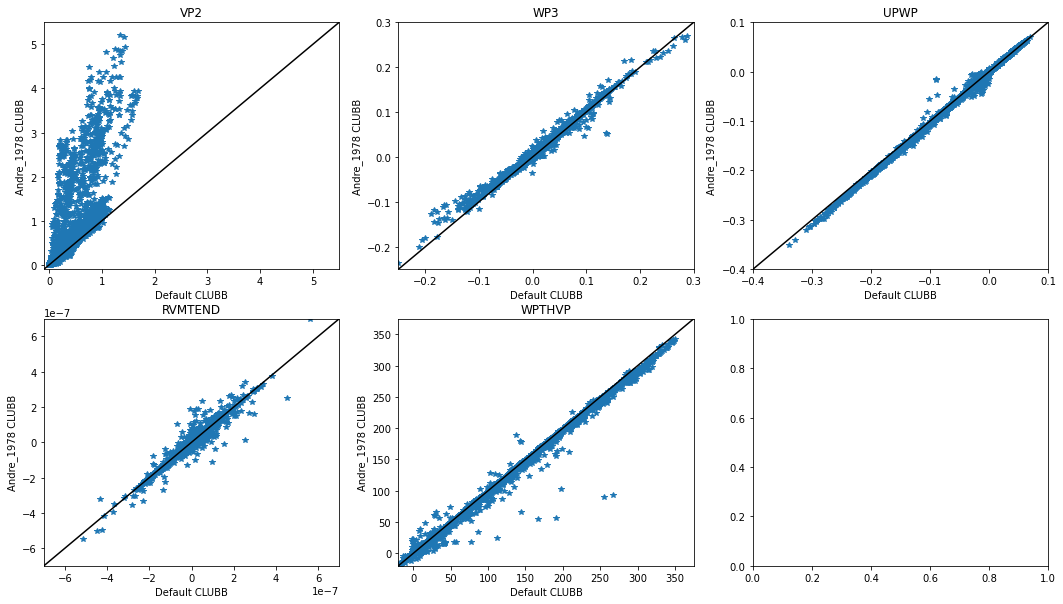

In [56]:
## Scatter plot of lowest 3-model levels, all days: noMom vs. useAndre

nTimes=np.shape(RTPTHLP_noMom)[0]

fig, axs_all = plt.subplots(2,3, figsize=(18, 10),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.2)


axs[0].plot(np.reshape(VP2_noMom[:,-3::,:,:], 3*nTimes), np.reshape(VP2_useAndre[:,-3::,:,:], 3*nTimes),'*')
axs[0].set_title('VP2')
axs[0].set_xlabel('Default CLUBB')
axs[0].set_ylabel('Andre_1978 CLUBB')
axs[0].set_ylim([-0.1, 5.5])
axs[0].set_xlim([-0.1, 5.5])
axs[0].plot([-0.1,5.5],[-0.1,5.5],'k-')

axs[1].plot(np.reshape(WP3_noMom[:,-3::,:,:], 3*nTimes), np.reshape(WP3_useAndre[:,-3::,:,:], 3*nTimes),'*')
axs[1].set_title('WP3')
axs[1].set_xlabel('Default CLUBB')
axs[1].set_ylabel('Andre_1978 CLUBB')
axs[1].set_ylim([-0.25, 0.30])
axs[1].set_xlim([-0.25, 0.30])
axs[1].plot([-0.25,0.30],[-0.25,0.30],'k-')

axs[2].plot(np.reshape(UPWP_noMom[:,-3::,:,:], 3*nTimes), np.reshape(UPWP_useAndre[:,-3::,:,:], 3*nTimes),'*')
axs[2].set_title('UPWP')
axs[2].set_xlabel('Default CLUBB')
axs[2].set_ylabel('Andre_1978 CLUBB')
axs[2].set_ylim([-0.4, 0.1])
axs[2].set_xlim([-0.4, 0.1])
axs[2].plot([-0.4,0.1],[-0.4,0.1],'k-')

# -------------------------------------------------- Second row 
axs[3].plot(np.reshape(RVMTEND_noMom[:,-3::,:,:], 3*nTimes), np.reshape(RVMTEND_useAndre[:,-3::,:,:], 3*nTimes),'*')
axs[3].set_title('RVMTEND')
axs[3].set_xlabel('Default CLUBB')
axs[3].set_ylabel('Andre_1978 CLUBB')
axs[3].set_ylim([-7e-7, 7e-7])
axs[3].set_xlim([-7e-7, 7e-7])
axs[3].plot([-7e-7,7e-7],[-7e-7,7e-7],'k-')

axs[4].plot(np.reshape(WPTHVP_noMom[:,-3::,:,:], 3*nTimes), np.reshape(WPTHVP_useAndre[:,-3::,:,:], 3*nTimes),'*')
axs[4].set_title('WPTHVP')
axs[4].set_xlabel('Default CLUBB')
axs[4].set_ylabel('Andre_1978 CLUBB')
axs[4].set_ylim([-20, 375])
axs[4].set_xlim([-20, 375])
axs[4].plot([-20,375],[-20,375],'k-')

# axs[5].plot(np.reshape(UP2_noMom[:,-3::,:,:], 3*nTimes), np.reshape(UP2_useAndre[:,-3::,:,:], 3*nTimes),'*')
# axs[5].set_title('UP2')
# axs[5].set_xlabel('Default CLUBB')
# axs[5].set_ylabel('Andre_1978 CLUBB')
# axs[5].set_ylim([-0.2, 5.2])
# axs[5].set_xlim([-0.2, 5.2])
# axs[5].plot([-0.2,5.2],[-0.2,5.2],'k-')



Text(0, 0.5, '[m/s]')

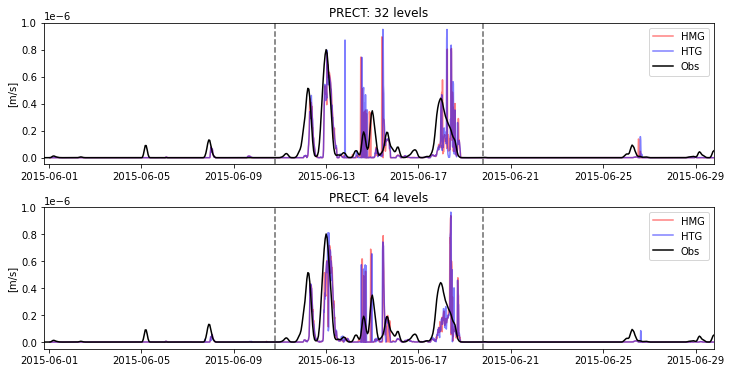

In [167]:
fig, axs_all = plt.subplots(2,1, figsize=(12, 6),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.3)

# Plot 32 levels:
# ---------------
axs[0].plot(timesHTG_32local, np.squeeze(hmgDS_32.PRECT.values)[:],'r', label='HMG',alpha=0.5)
axs[0].plot(timesHTG_32local, np.squeeze(htgDS_32.PRECT.values)[:],'b', label='HTG',alpha=0.5)
axs[0].plot(timesNate_local, np.squeeze(nateHMG.prec_srf.values/3600.0/1000.0)[:], color='k', label='Obs')  # Original units = mm/hr
axs[0].legend()
axs[0].set_title('PRECT: 32 levels')
axs[0].set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,30))
#axs[0].set_xlim(datetime.date(2015,6,11),datetime.date(2015,6,20))
axs[0].set_ylim([-0.05e-6, 1e-6])
axs[0].axvline(datetime.datetime(2015,6,20),color='dimgray',linestyle='--')
axs[0].axvline(datetime.datetime(2015,6,11),color='dimgray',linestyle='--')
axs[0].set_ylabel('[m/s]')

# Plot 64 levels:
# ---------------
axs[1].plot(timesHTG_64local, np.squeeze(hmgDS_64.PRECT.values)[:],'r', label='HMG',alpha=0.5)
axs[1].plot(timesHTG_64local, np.squeeze(htgDS_64.PRECT.values)[:],'b', label='HTG',alpha=0.5)
axs[1].plot(timesNate_local, np.squeeze(nateHMG.prec_srf.values/3600.0/1000.0)[:], color='k', label='Obs')  # Original units = mm/hr
axs[1].legend()
axs[1].set_title('PRECT: 64 levels')
axs[1].set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,30))
axs[1].axvline(datetime.datetime(2015,6,20),color='dimgray',linestyle='--')
axs[1].axvline(datetime.datetime(2015,6,11),color='dimgray',linestyle='--')
#axs[1].set_xlim(datetime.date(2015,6,11),datetime.date(2015,6,20))
axs[1].set_ylim([-0.05e-6, 1e-6])
axs[1].set_ylabel('[m/s]')


Text(0, 0.5, '[m/s]')

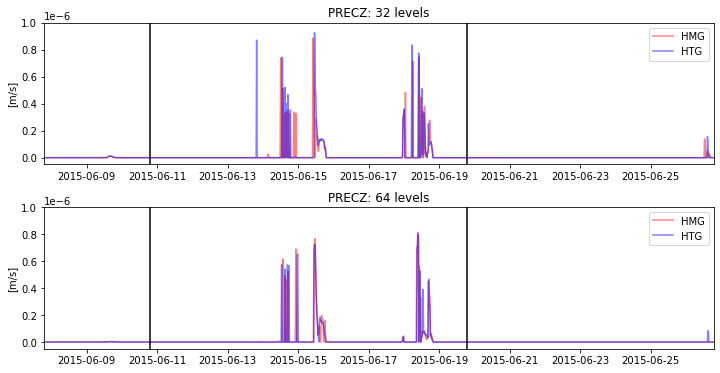

In [119]:
fig, axs_all = plt.subplots(2,1, figsize=(12, 6),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.3)

# Plot 32 levels:
# ---------------
axs[0].plot(timesHTG_32local, np.squeeze(hmgDS_32.PRECZ.values)[:],'r', label='HMG',alpha=0.5)
axs[0].plot(timesHTG_32local, np.squeeze(htgDS_32.PRECZ.values)[:],'b', label='HTG',alpha=0.5)
axs[0].legend()
axs[0].set_title('PRECZ: 32 levels')
# axs[0].set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,30))
axs[0].set_xlim(datetime.date(2015,6,8),datetime.date(2015,6,27))
axs[0].set_ylim([-0.05e-6, 1e-6])
axs[0].axvline(datetime.datetime(2015,6,20),color='k')
axs[0].axvline(datetime.datetime(2015,6,11),color='k')
axs[0].set_ylabel('[m/s]')

# Plot 64 levels:
# ---------------
axs[1].plot(timesHTG_64local, np.squeeze(hmgDS_64.PRECZ.values)[:],'r', label='HMG',alpha=0.5)
axs[1].plot(timesHTG_64local, np.squeeze(htgDS_64.PRECZ.values)[:],'b', label='HTG',alpha=0.5)
axs[1].legend()
axs[1].set_title('PRECZ: 64 levels')
axs[1].set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,30))
axs[1].axvline(datetime.datetime(2015,6,20),color='k')
axs[1].axvline(datetime.datetime(2015,6,11),color='k')
axs[1].set_xlim(datetime.date(2015,6,8),datetime.date(2015,6,27))
axs[1].set_ylim([-0.05e-6, 1e-6])
axs[1].set_ylabel('[m/s]')



Text(0, 0.5, '[m/s]')

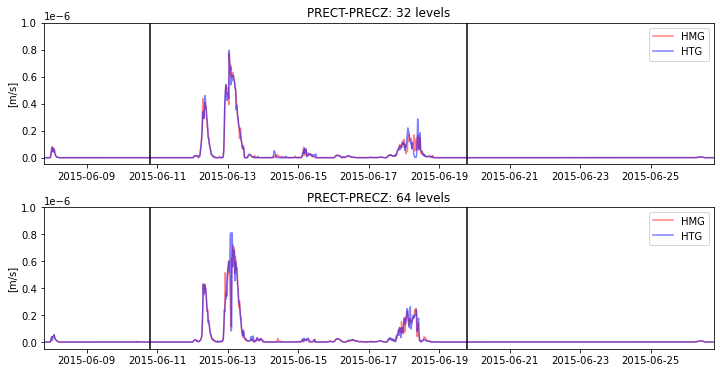

In [120]:
fig, axs_all = plt.subplots(2,1, figsize=(12, 6),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.3)

# Plot 32 levels:
# ---------------
axs[0].plot(timesHTG_32local, np.squeeze(hmgDS_32.PRECT.values-hmgDS_32.PRECZ.values)[:],'r', label='HMG',alpha=0.5)
axs[0].plot(timesHTG_32local, np.squeeze(htgDS_32.PRECT.values-htgDS_32.PRECZ.values)[:],'b', label='HTG',alpha=0.5)
axs[0].legend()
axs[0].set_title('PRECT-PRECZ: 32 levels')
# axs[0].set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,30))
axs[0].set_xlim(datetime.date(2015,6,8),datetime.date(2015,6,27))
axs[0].set_ylim([-0.05e-6, 1e-6])
axs[0].axvline(datetime.datetime(2015,6,20),color='k')
axs[0].axvline(datetime.datetime(2015,6,11),color='k')
axs[0].set_ylabel('[m/s]')

# Plot 64 levels:
# ---------------
axs[1].plot(timesHTG_64local, np.squeeze(hmgDS_64.PRECT.values-hmgDS_64.PRECZ.values)[:],'r', label='HMG',alpha=0.5)
axs[1].plot(timesHTG_64local, np.squeeze(htgDS_64.PRECT.values-htgDS_64.PRECZ.values)[:],'b', label='HTG',alpha=0.5)
axs[1].legend()
axs[1].set_title('PRECT-PRECZ: 64 levels')
axs[1].set_xlim(datetime.date(2015,6,8),datetime.date(2015,6,27))
axs[1].axvline(datetime.datetime(2015,6,20),color='k')
axs[1].axvline(datetime.datetime(2015,6,11),color='k')
#axs[1].set_xlim(datetime.date(2015,6,11),datetime.date(2015,6,20))
axs[1].set_ylim([-0.05e-6, 1e-6])
axs[1].set_ylabel('[m/s]')




In [143]:
# Print out total precipitation from each simulation/vertical resolution
print('Total June precipitation [m/s]')
print('              HMG       HTG')
print('32levs: %10.2e %10.2e ' % (np.nansum(hmgDS_32.PRECT.values), np.nansum(htgDS_32.PRECT.values)))
print('64levs: %10.2e %10.2e ' % (np.nansum(hmgDS_64.PRECT.values), np.nansum(htgDS_64.PRECT.values)))


Total June precipitation [m/s]
              HMG       HTG
32levs:   4.80e-05   4.77e-05 
64levs:   4.65e-05   4.73e-05 


In [14]:
# Define three different periods... 
iEarlyDry = np.where(timesHTG_64local.day<=11)[0]
iWet      = np.where( (timesHTG_64local.day>=12) & (timesHTG_64local.day<=19) )[0]
iLateDry  = np.where(timesHTG_64local.day>=20)[0]

# Define early dry periods... 
hmg32_earlyDry = hmgDS_32.isel(time=iEarlyDry)
htg32_earlyDry = htgDS_32.isel(time=iEarlyDry)
hmg64_earlyDry = hmgDS_64.isel(time=iEarlyDry)
htg64_earlyDry = htgDS_64.isel(time=iEarlyDry)

# Define wet period...
hmg32_wet = hmgDS_32.isel(time=iWet)
htg32_wet = htgDS_32.isel(time=iWet)
hmg64_wet = hmgDS_64.isel(time=iWet)
htg64_wet = htgDS_64.isel(time=iWet)

# Define late dry periods...
hmg32_lateDry = hmgDS_32.isel(time=iLateDry)
htg32_lateDry = htgDS_32.isel(time=iLateDry)
hmg64_lateDry = hmgDS_64.isel(time=iLateDry)
htg64_lateDry = htgDS_64.isel(time=iLateDry)


**What does the average diurnal cycle of PBLH look like in these cases/periods?**

In [77]:
# -------------------------------- 
#   Early dry period 
# -------------------------------- 

# Mean diurnal cycle (in UTC time, though)
meanDiurnal_earlyDry_htg32 = htg32_earlyDry.groupby("time.hour").mean()
meanDiurnal_earlyDry_hmg32 = hmg32_earlyDry.groupby("time.hour").mean()

meanDiurnal_earlyDry_htg64 = htg64_earlyDry.groupby("time.hour").mean()
meanDiurnal_earlyDry_hmg64 = hmg64_earlyDry.groupby("time.hour").mean()

# Easier to plot in local time, so let's double up on the diurnal cycle,
#  Then plot the correct section representing 12a-12a
# 
# CDT to UTC: 12a CDT = 6a UTC, so 6 hour offset 
htg_diurnalPBL32_double       = np.full([48], np.nan)
htg_diurnalPBL32_double[0:24] = np.squeeze(meanDiurnal_earlyDry_htg32.PBLH.values)
htg_diurnalPBL32_double[24::] = np.squeeze(meanDiurnal_earlyDry_htg32.PBLH.values)
htg32_diurnalPBLH_earlyDry    = htg_diurnalPBL32_double[6:30]

hmg_diurnalPBL32_double       = np.full([48], np.nan)
hmg_diurnalPBL32_double[0:24] = np.squeeze(meanDiurnal_earlyDry_hmg32.PBLH.values)
hmg_diurnalPBL32_double[24::] = np.squeeze(meanDiurnal_earlyDry_hmg32.PBLH.values)
hmg32_diurnalPBLH_earlyDry    = hmg_diurnalPBL32_double[6:30]

htg_diurnalPBL64_double       = np.full([48], np.nan)
htg_diurnalPBL64_double[0:24] = np.squeeze(meanDiurnal_earlyDry_htg64.PBLH.values)
htg_diurnalPBL64_double[24::] = np.squeeze(meanDiurnal_earlyDry_htg64.PBLH.values)
htg64_diurnalPBLH_earlyDry    = htg_diurnalPBL64_double[6:30]

hmg_diurnalPBL64_double       = np.full([48], np.nan)
hmg_diurnalPBL64_double[0:24] = np.squeeze(meanDiurnal_earlyDry_hmg64.PBLH.values)
hmg_diurnalPBL64_double[24::] = np.squeeze(meanDiurnal_earlyDry_hmg64.PBLH.values)
hmg64_diurnalPBLH_earlyDry    = hmg_diurnalPBL64_double[6:30]



In [78]:
# -------------------------------- 
#   Wet period 
# -------------------------------- 

# Mean diurnal cycle (in UTC time, though)
meanDiurnal_wet_htg32 = htg32_wet.groupby("time.hour").mean()
meanDiurnal_wet_hmg32 = hmg32_wet.groupby("time.hour").mean()

meanDiurnal_wet_htg64 = htg64_wet.groupby("time.hour").mean()
meanDiurnal_wet_hmg64 = hmg64_wet.groupby("time.hour").mean()

# Easier to plot in local time, so let's double up on the diurnal cycle,
#  Then plot the correct section representing 12a-12a
# 
# CDT to UTC: 12a CDT = 6a UTC, so 6 hour offset 
htg_diurnalPBL32_double       = np.full([48], np.nan)
htg_diurnalPBL32_double[0:24] = np.squeeze(meanDiurnal_wet_htg32.PBLH.values)
htg_diurnalPBL32_double[24::] = np.squeeze(meanDiurnal_wet_htg32.PBLH.values)
htg32_diurnalPBLH_wet         = htg_diurnalPBL32_double[6:30]

hmg_diurnalPBL32_double       = np.full([48], np.nan)
hmg_diurnalPBL32_double[0:24] = np.squeeze(meanDiurnal_wet_hmg32.PBLH.values)
hmg_diurnalPBL32_double[24::] = np.squeeze(meanDiurnal_wet_hmg32.PBLH.values)
hmg32_diurnalPBLH_wet         = hmg_diurnalPBL32_double[6:30]

htg_diurnalPBL64_double       = np.full([48], np.nan)
htg_diurnalPBL64_double[0:24] = np.squeeze(meanDiurnal_wet_htg64.PBLH.values)
htg_diurnalPBL64_double[24::] = np.squeeze(meanDiurnal_wet_htg64.PBLH.values)
htg64_diurnalPBLH_wet         = htg_diurnalPBL64_double[6:30]

hmg_diurnalPBL64_double       = np.full([48], np.nan)
hmg_diurnalPBL64_double[0:24] = np.squeeze(meanDiurnal_wet_hmg64.PBLH.values)
hmg_diurnalPBL64_double[24::] = np.squeeze(meanDiurnal_wet_hmg64.PBLH.values)
hmg64_diurnalPBLH_wet         = hmg_diurnalPBL64_double[6:30]


In [79]:
# -------------------------------- 
#   Late dry period 
# -------------------------------- 

# Mean diurnal cycle (in UTC time, though)
meanDiurnal_lateDry_htg32 = htg32_lateDry.groupby("time.hour").mean()
meanDiurnal_lateDry_hmg32 = hmg32_lateDry.groupby("time.hour").mean()

meanDiurnal_lateDry_htg64 = htg64_lateDry.groupby("time.hour").mean()
meanDiurnal_lateDry_hmg64 = hmg64_lateDry.groupby("time.hour").mean()

# Easier to plot in local time, so let's double up on the diurnal cycle,
#  Then plot the correct section representing 12a-12a
# 
# CDT to UTC: 12a CDT = 6a UTC, so 6 hour offset 
htg_diurnalPBL32_double       = np.full([48], np.nan)
htg_diurnalPBL32_double[0:24] = np.squeeze(meanDiurnal_lateDry_htg32.PBLH.values)
htg_diurnalPBL32_double[24::] = np.squeeze(meanDiurnal_lateDry_htg32.PBLH.values)
htg32_diurnalPBLH_lateDry     = htg_diurnalPBL32_double[6:30]

hmg_diurnalPBL32_double       = np.full([48], np.nan)
hmg_diurnalPBL32_double[0:24] = np.squeeze(meanDiurnal_lateDry_hmg32.PBLH.values)
hmg_diurnalPBL32_double[24::] = np.squeeze(meanDiurnal_lateDry_hmg32.PBLH.values)
hmg32_diurnalPBLH_lateDry     = hmg_diurnalPBL32_double[6:30]

htg_diurnalPBL64_double       = np.full([48], np.nan)
htg_diurnalPBL64_double[0:24] = np.squeeze(meanDiurnal_lateDry_htg64.PBLH.values)
htg_diurnalPBL64_double[24::] = np.squeeze(meanDiurnal_lateDry_htg64.PBLH.values)
htg64_diurnalPBLH_lateDry     = htg_diurnalPBL64_double[6:30]

hmg_diurnalPBL64_double       = np.full([48], np.nan)
hmg_diurnalPBL64_double[0:24] = np.squeeze(meanDiurnal_lateDry_hmg64.PBLH.values)
hmg_diurnalPBL64_double[24::] = np.squeeze(meanDiurnal_lateDry_hmg64.PBLH.values)
hmg64_diurnalPBLH_lateDry     = hmg_diurnalPBL64_double[6:30]




(0.0, 2000.0)

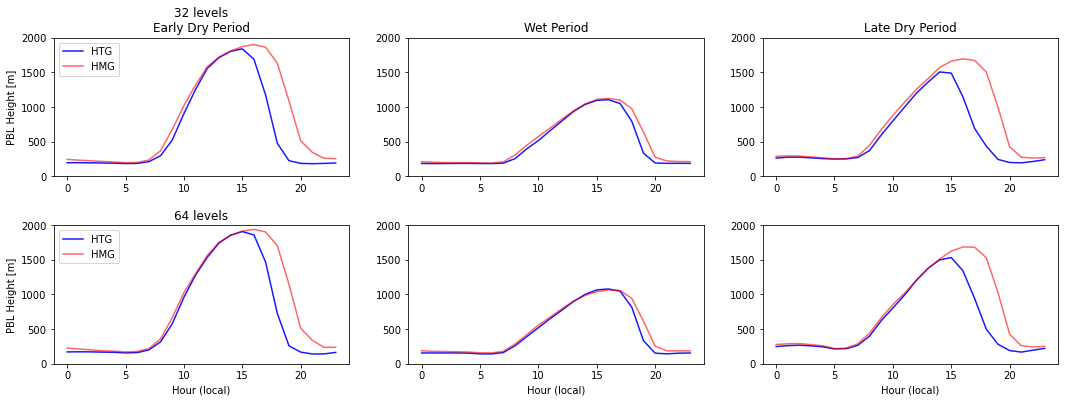

In [80]:
# What is the differenct in PBLH within each of these? 
fig, axs_all = plt.subplots(2,3, figsize=(18, 6),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.35)

# ------------
#  32 levels 
# ------------

axs[0].plot(meanDiurnal_lateDry_hmg32.hour.values,htg32_diurnalPBLH_earlyDry,'b',label='HTG',alpha=0.9)
axs[0].plot(meanDiurnal_lateDry_hmg32.hour.values,hmg32_diurnalPBLH_earlyDry,'r',label='HMG',alpha=0.6)
axs[0].set_title('32 levels\nEarly Dry Period')
axs[0].legend(loc='upper left')
axs[0].set_ylabel('PBL Height [m]')

axs[1].plot(meanDiurnal_lateDry_hmg32.hour.values,htg32_diurnalPBLH_wet,'b',label='HTG',alpha=0.9)
axs[1].plot(meanDiurnal_lateDry_hmg32.hour.values,hmg32_diurnalPBLH_wet,'r',label='HMG',alpha=0.6)
axs[1].set_title('Wet Period')

axs[2].plot(meanDiurnal_lateDry_hmg32.hour.values,htg32_diurnalPBLH_lateDry,'b',label='HTG',alpha=0.9)
axs[2].plot(meanDiurnal_lateDry_hmg32.hour.values,hmg32_diurnalPBLH_lateDry,'r',label='HMG',alpha=0.6)
axs[2].set_title('Late Dry Period')


# ------------
#  64 levels 
# ------------

axs[3].plot(meanDiurnal_lateDry_hmg32.hour.values,htg64_diurnalPBLH_earlyDry,'b',label='HTG',alpha=0.9)
axs[3].plot(meanDiurnal_lateDry_hmg32.hour.values,hmg64_diurnalPBLH_earlyDry,'r',label='HMG',alpha=0.6)
axs[3].set_title('64 levels')
axs[3].legend(loc='upper left')
axs[3].set_ylabel('PBL Height [m]')
axs[3].set_xlabel('Hour (local)')

axs[4].plot(meanDiurnal_lateDry_hmg32.hour.values,htg64_diurnalPBLH_wet,'b',label='HTG',alpha=0.9)
axs[4].plot(meanDiurnal_lateDry_hmg32.hour.values,hmg64_diurnalPBLH_wet,'r',label='HMG',alpha=0.6)
axs[4].set_xlabel('Hour (local)')

axs[5].plot(meanDiurnal_lateDry_hmg32.hour.values,htg64_diurnalPBLH_lateDry,'b',label='HTG',alpha=0.9)
axs[5].plot(meanDiurnal_lateDry_hmg32.hour.values,hmg64_diurnalPBLH_lateDry,'r',label='HMG',alpha=0.6)
axs[5].set_xlabel('Hour (local)')


# Set consistent y axis limits
axs[0].set_ylim([0,2000])
axs[1].set_ylim([0,2000])
axs[2].set_ylim([0,2000])
axs[3].set_ylim([0,2000])
axs[4].set_ylim([0,2000])
axs[5].set_ylim([0,2000])


**Composites over these periods to look at vertical evolution of fields**

Specific Humidity

In [75]:
np.shape(PBLdepth_hmg)

(2088,)

In [96]:
# Get mean over days...? 
np.shape(Q_hmg32[iEarlyDry,:,:,:])

# Specific Humidity 
dailyQ_hmg32 = np.full([30,72, len(pnew32)], np.nan)
dailyQ_htg32 = np.full([30,72, len(pnew32)], np.nan)
dailyQ_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyQ_htg64 = np.full([30,72, len(pnew64)], np.nan)

# Liquid water potential temperature 
dailyTHETAL_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyTHETAL_htg64 = np.full([30,72, len(pnew64)], np.nan)

# Moisture flux 
dailyWPRTP_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyWPRTP_htg64 = np.full([30,72, len(pnew64)], np.nan)

# Heat flux 
dailyWPTHLP_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyWPTHLP_htg64 = np.full([30,72, len(pnew64)], np.nan)

# Buoyancy flux 
dailyWPTHVP_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyWPTHVP_htg64 = np.full([30,72, len(pnew64)], np.nan)

# Vertical velocity variance 
dailyWP2_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyWP2_htg64 = np.full([30,72, len(pnew64)], np.nan)

# Omega 
dailyOMEGA_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyOMEGA_htg64 = np.full([30,72, len(pnew64)], np.nan)

# TKE 
dailyTKE_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyTKE_htg64 = np.full([30,72, len(pnew64)], np.nan)

# CLUBB Water Vapor Tendency
dailyRVMTEND_hmg32 = np.full([30,72, len(pnew32)], np.nan)
dailyRVMTEND_htg32 = np.full([30,72, len(pnew32)], np.nan)
dailyRVMTEND_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyRVMTEND_htg64 = np.full([30,72, len(pnew64)], np.nan)

# CLUBB Static energy Tendency
dailySTEND_hmg32 = np.full([30,72, len(pnew32)], np.nan)
dailySTEND_htg32 = np.full([30,72, len(pnew32)], np.nan)
dailySTEND_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailySTEND_htg64 = np.full([30,72, len(pnew64)], np.nan)

# RTP2 
dailyRTP2_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyRTP2_htg64 = np.full([30,72, len(pnew64)], np.nan)

# THLP2 
dailyTHLP2_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyTHLP2_htg64 = np.full([30,72, len(pnew64)], np.nan)

# WSUB
dailyWSUB_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyWSUB_htg64 = np.full([30,72, len(pnew64)], np.nan)

# PBLH as defined by dQ/dZ max
dailyDQDZmax_hmg64 = np.full([30,72], np.nan)
dailyDQDZmax_htg64 = np.full([30,72], np.nan)

for days in range(29):
    iDay = np.where(timesHMG_32local.day==(days+1))[0]
    
    # The first day starts at 01 local time, not 00, so missing 3 first points:
    if days==0:
        # Specific Humidity 
        dailyQ_hmg32[days,3::,:] = np.squeeze(Q_hmg32)[iDay,:]
        dailyQ_htg32[days,3::,:] = np.squeeze(Q_htg32)[iDay,:]
        
        dailyQ_hmg64[days,3::,:] = np.squeeze(Q_hmg64)[iDay,:]
        dailyQ_htg64[days,3::,:] = np.squeeze(Q_htg64)[iDay,:]
        
        # CLUBB Water Vapor Tendency
        dailyRVMTEND_hmg32[days,3::,:] = np.squeeze(RVMTEND_hmg32)[iDay,:]
        dailyRVMTEND_htg32[days,3::,:] = np.squeeze(RVMTEND_htg32)[iDay,:]
        
        dailyRVMTEND_hmg64[days,3::,:] = np.squeeze(RVMTEND_hmg64)[iDay,:]
        dailyRVMTEND_htg64[days,3::,:] = np.squeeze(RVMTEND_htg64)[iDay,:]
        
        # Liquid water potential temperature 
        dailyTHETAL_hmg64[days,3::,:] = np.squeeze(THETAL_hmg64)[iDay,:]
        dailyTHETAL_htg64[days,3::,:] = np.squeeze(THETAL_htg64)[iDay,:]
        
        # Moisture flux
        dailyWPRTP_hmg64[days,3::,:] = np.squeeze(WPRTP_hmg64)[iDay,:]
        dailyWPRTP_htg64[days,3::,:] = np.squeeze(WPRTP_htg64)[iDay,:]
        
        #Heat flux 
        dailyWPTHLP_hmg64[days,3::,:] = np.squeeze(WPTHLP_hmg64)[iDay,:]
        dailyWPTHLP_htg64[days,3::,:] = np.squeeze(WPTHLP_htg64)[iDay,:]
        
        # Buoyancy flux 
        dailyWPTHVP_hmg64[days,3::,:] = np.squeeze(WPTHVP_hmg64)[iDay,:]
        dailyWPTHVP_htg64[days,3::,:] = np.squeeze(WPTHVP_htg64)[iDay,:]
        
        # Vertical velcoity variance 
        dailyWP2_hmg64[days,3::,:] = np.squeeze(WP2_hmg64)[iDay,:]
        dailyWP2_htg64[days,3::,:] = np.squeeze(WP2_htg64)[iDay,:]
        
        # OMEGA
        dailyOMEGA_hmg64[days,3::,:] = np.squeeze(OMEGA_hmg64)[iDay,:]
        dailyOMEGA_htg64[days,3::,:] = np.squeeze(OMEGA_htg64)[iDay,:]
        
        # TKE
        dailyTKE_hmg64[days,3::,:] = np.squeeze(TKE_hmg64)[iDay,:]
        dailyTKE_htg64[days,3::,:] = np.squeeze(TKE_htg64)[iDay,:]
        
        # CLUBB Static Energy Tendency
        dailySTEND_hmg64[days,3::,:] = np.squeeze(STEND_hmg64)[iDay,:]
        dailySTEND_htg64[days,3::,:] = np.squeeze(STEND_htg64)[iDay,:]
        
        # RTP2
        dailyRTP2_hmg64[days,3::,:] = np.squeeze(RTP2_hmg64)[iDay,:]
        dailyRTP2_htg64[days,3::,:] = np.squeeze(RTP2_htg64)[iDay,:]
        
        # THLP2
        dailyTHLP2_hmg64[days,3::,:] = np.squeeze(THLP2_hmg64)[iDay,:]
        dailyTHLP2_htg64[days,3::,:] = np.squeeze(THLP2_htg64)[iDay,:]
        
        # WSUB
        dailyWSUB_hmg64[days,3::,:] = np.squeeze(WSUB_hmg64)[iDay,:]
        dailyWSUB_htg64[days,3::,:] = np.squeeze(WSUB_htg64)[iDay,:]
        
        # PBLH as defined by dQ/dZ max
        dailyDQDZmax_hmg64[days,3::] = np.squeeze(PBLdepth_hmg)[iDay]
        dailyDQDZmax_htg64[days,3::] = np.squeeze(PBLdepth_htg)[iDay]
        
    else:
        # Specific Humidity 
        dailyQ_hmg32[days,:,:]   = np.squeeze(Q_hmg32)[iDay,:]
        dailyQ_htg32[days,:,:]   = np.squeeze(Q_htg32)[iDay,:]
        
        dailyQ_hmg64[days,:,:]   = np.squeeze(Q_hmg64)[iDay,:]
        dailyQ_htg64[days,:,:]   = np.squeeze(Q_htg64)[iDay,:]
        
        # CLUBB Water Vapor Tendency 
        dailyRVMTEND_hmg32[days,:,:]   = np.squeeze(RVMTEND_hmg32)[iDay,:]
        dailyRVMTEND_htg32[days,:,:]   = np.squeeze(RVMTEND_htg32)[iDay,:]
        
        dailyRVMTEND_hmg64[days,:,:]   = np.squeeze(RVMTEND_hmg64)[iDay,:]
        dailyRVMTEND_htg64[days,:,:]   = np.squeeze(RVMTEND_htg64)[iDay,:]
        
        # Liquid water potential temperature 
        dailyTHETAL_hmg64[days,:,:] = np.squeeze(THETAL_hmg64)[iDay,:]
        dailyTHETAL_htg64[days,:,:] = np.squeeze(THETAL_htg64)[iDay,:]
        
        # Moisture flux
        dailyWPRTP_hmg64[days,:,:] = np.squeeze(WPRTP_hmg64)[iDay,:]
        dailyWPRTP_htg64[days,:,:] = np.squeeze(WPRTP_htg64)[iDay,:]
        
        #Heat flux 
        dailyWPTHLP_hmg64[days,:,:] = np.squeeze(WPTHLP_hmg64)[iDay,:]
        dailyWPTHLP_htg64[days,:,:] = np.squeeze(WPTHLP_htg64)[iDay,:]
        
        # Buoyancy flux 
        dailyWPTHVP_hmg64[days,:,:] = np.squeeze(WPTHVP_hmg64)[iDay,:]
        dailyWPTHVP_htg64[days,:,:] = np.squeeze(WPTHVP_htg64)[iDay,:]
        
        # Vertical velcoity variance 
        dailyWP2_hmg64[days,:,:] = np.squeeze(WP2_hmg64)[iDay,:]
        dailyWP2_htg64[days,:,:] = np.squeeze(WP2_htg64)[iDay,:]
        
        # OMEGA
        dailyOMEGA_hmg64[days,:,:] = np.squeeze(OMEGA_hmg64)[iDay,:]
        dailyOMEGA_htg64[days,:,:] = np.squeeze(OMEGA_htg64)[iDay,:]
        
        # TKE
        dailyTKE_hmg64[days,:,:] = np.squeeze(TKE_hmg64)[iDay,:]
        dailyTKE_htg64[days,:,:] = np.squeeze(TKE_htg64)[iDay,:]
        
        # CLUBB Static Energy Tendency
        dailySTEND_hmg64[days,:,:] = np.squeeze(STEND_hmg64)[iDay,:]
        dailySTEND_htg64[days,:,:] = np.squeeze(STEND_htg64)[iDay,:]
        
        # RTP2
        dailyRTP2_hmg64[days,:,:] = np.squeeze(RTP2_hmg64)[iDay,:]
        dailyRTP2_htg64[days,:,:] = np.squeeze(RTP2_htg64)[iDay,:]
        
        # THLP2
        dailyTHLP2_hmg64[days,:,:] = np.squeeze(THLP2_hmg64)[iDay,:]
        dailyTHLP2_htg64[days,:,:] = np.squeeze(THLP2_htg64)[iDay,:]
        
        # WSUB
        dailyWSUB_hmg64[days,:,:] = np.squeeze(WSUB_hmg64)[iDay,:]
        dailyWSUB_htg64[days,:,:] = np.squeeze(WSUB_htg64)[iDay,:]
        
        # PBLH as defined by dQ/dZ max
        dailyDQDZmax_hmg64[days,:] = np.squeeze(PBLdepth_hmg)[iDay]
        dailyDQDZmax_htg64[days,:] = np.squeeze(PBLdepth_htg)[iDay]
        
        
# ----------------------------------------------------        
# Average over all the days in a period 
# ----------------------------------------------------

# Specific Humidity 
# earlyPeriod_Qhmg32 = np.nanmean(dailyQ_hmg32[0:11,:,:], axis=0)
# earlyPeriod_Qhtg32 = np.nanmean(dailyQ_htg32[0:11,:,:], axis=0)
earlyPeriod_Qhmg = np.nanmean(dailyQ_hmg64[0:11,:,:], axis=0)
earlyPeriod_Qhtg = np.nanmean(dailyQ_htg64[0:11,:,:], axis=0)
earlyPeriod_Qdiff32  = np.nanmean( (dailyQ_htg32[0:11,:,:] - dailyQ_hmg32[0:11,:,:]), axis=0)
earlyPeriod_Qdiff64  = np.nanmean( (dailyQ_htg64[0:11,:,:] - dailyQ_hmg64[0:11,:,:]), axis=0)

# wetPeriod_Qhmg32 = np.nanmean(dailyQ_hmg32[11:20,:,:], axis=0)
# wetPeriod_Qhtg32 = np.nanmean(dailyQ_htg32[11:20,:,:], axis=0)
# wetPeriod_Qhmg64 = np.nanmean(dailyQ_hmg64[11:20,:,:], axis=0)
# wetPeriod_Qhtg64 = np.nanmean(dailyQ_htg64[11:20,:,:], axis=0)
wetPeriod_Qdiff32  = np.nanmean( (dailyQ_htg32[11:20,:,:] - dailyQ_hmg32[11:20,:,:]), axis=0)
wetPeriod_Qdiff64  = np.nanmean( (dailyQ_htg64[11:20,:,:] - dailyQ_hmg64[11:20,:,:]), axis=0)

# latePeriod_Qhmg32 = np.nanmean(dailyQ_hmg32[20::,:,:], axis=0)
# latePeriod_Qhtg32 = np.nanmean(dailyQ_htg32[20::,:,:], axis=0)
# latePeriod_Qhmg64 = np.nanmean(dailyQ_hmg64[20::,:,:], axis=0)
# latePeriod_Qhtg64 = np.nanmean(dailyQ_htg64[20::,:,:], axis=0)
latePeriod_Qdiff32  = np.nanmean( (dailyQ_htg32[20::,:,:] - dailyQ_hmg32[20::,:,:]), axis=0)
latePeriod_Qdiff64  = np.nanmean( (dailyQ_htg64[20::,:,:] - dailyQ_hmg64[20::,:,:]), axis=0)


# CLUBB Water Vapor Tendency 
earlyPeriod_RVMTENDhmg64 = np.nanmean(dailyRVMTEND_hmg64[0:11,:,:], axis=0)
earlyPeriod_RVMTENDhtg64 = np.nanmean(dailyRVMTEND_htg64[0:11,:,:], axis=0)

earlyPeriod_RVMTENDdiff32  = np.nanmean( (dailyRVMTEND_htg32[0:11,:,:] - dailyRVMTEND_hmg32[0:11,:,:]), axis=0)
earlyPeriod_RVMTENDdiff64  = np.nanmean( (dailyRVMTEND_htg64[0:11,:,:] - dailyRVMTEND_hmg64[0:11,:,:]), axis=0)

wetPeriod_RVMTENDdiff32  = np.nanmean( (dailyRVMTEND_htg32[11:20,:,:] - dailyRVMTEND_hmg32[11:20,:,:]), axis=0)
wetPeriod_RVMTENDdiff64  = np.nanmean( (dailyRVMTEND_htg64[11:20,:,:] - dailyRVMTEND_hmg64[11:20,:,:]), axis=0)

latePeriod_RVMTENDdiff32  = np.nanmean( (dailyRVMTEND_htg32[20::,:,:] - dailyRVMTEND_hmg32[20::,:,:]), axis=0)
latePeriod_RVMTENDdiff64  = np.nanmean( (dailyRVMTEND_htg64[20::,:,:] - dailyRVMTEND_hmg64[20::,:,:]), axis=0)

# Liquid water potential temperature 
earlyPeriod_THLPhmg64 = np.nanmean(dailyTHETAL_hmg64[0:11,:,:], axis=0)
earlyPeriod_THLPhtg64 = np.nanmean(dailyTHETAL_htg64[0:11,:,:], axis=0)

earlyPeriod_THLPdiff64 = np.nanmean( (dailyTHETAL_htg64[0:11,:,:] - dailyTHETAL_hmg64[0:11,:,:]), axis=0)
wetPeriod_THLPdiff64   = np.nanmean( (dailyTHETAL_htg64[11:20,:,:] - dailyTHETAL_hmg64[11:20,:,:]), axis=0)
latePeriod_THLPdiff64  = np.nanmean( (dailyTHETAL_htg64[20::,:,:] - dailyTHETAL_hmg64[20::,:,:]), axis=0)

# Moisture Flux 
earlyPeriod_WPRTPdiff64 = np.nanmean( (dailyWPRTP_htg64[0:11,:,:] - dailyWPRTP_hmg64[0:11,:,:]), axis=0)
wetPeriod_WPRTPdiff64   = np.nanmean( (dailyWPRTP_htg64[11:20,:,:] - dailyWPRTP_hmg64[11:20,:,:]), axis=0)
latePeriod_WPRTPdiff64  = np.nanmean( (dailyWPRTP_htg64[20::,:,:] - dailyWPRTP_hmg64[20::,:,:]), axis=0)

# Heat Flux 
earlyPeriod_WPTHLPdiff64 = np.nanmean( (dailyWPTHLP_htg64[0:11,:,:] - dailyWPTHLP_hmg64[0:11,:,:]), axis=0)
wetPeriod_WPTHLPdiff64   = np.nanmean( (dailyWPTHLP_htg64[11:20,:,:] - dailyWPTHLP_hmg64[11:20,:,:]), axis=0)
latePeriod_WPTHLPdiff64  = np.nanmean( (dailyWPTHLP_htg64[20::,:,:] - dailyWPTHLP_hmg64[20::,:,:]), axis=0)

earlyPeriod_WPTHLPhmg64 = np.nanmean( dailyWPTHLP_hmg64[0:11,:,:], axis=0)
earlyPeriod_WPTHLPhtg64 = np.nanmean( dailyWPTHLP_htg64[0:11,:,:], axis=0)

# Buoyancy Flux 
earlyPeriod_WPTHVPdiff64 = np.nanmean( (dailyWPTHVP_htg64[0:11,:,:] - dailyWPTHVP_hmg64[0:11,:,:]), axis=0)
wetPeriod_WPTHVPdiff64   = np.nanmean( (dailyWPTHVP_htg64[11:20,:,:] - dailyWPTHVP_hmg64[11:20,:,:]), axis=0)
latePeriod_WPTHVPdiff64  = np.nanmean( (dailyWPTHVP_htg64[20::,:,:] - dailyWPTHVP_hmg64[20::,:,:]), axis=0)

# Vertical Velocity Variance 
earlyPeriod_WP2hmg64 = np.nanmean(dailyWP2_hmg64[0:11,:,:], axis=0)
earlyPeriod_WP2htg64 = np.nanmean(dailyWP2_htg64[0:11,:,:], axis=0)

earlyPeriod_WP2diff64 = np.nanmean( (dailyWP2_htg64[0:11,:,:] - dailyWP2_hmg64[0:11,:,:]), axis=0)
wetPeriod_WP2diff64   = np.nanmean( (dailyWP2_htg64[11:20,:,:] - dailyWP2_hmg64[11:20,:,:]), axis=0)
latePeriod_WP2diff64  = np.nanmean( (dailyWP2_htg64[20::,:,:] - dailyWP2_hmg64[20::,:,:]), axis=0)

# Omega
earlyPeriod_Omegadiff64 = np.nanmean( (dailyOMEGA_htg64[0:11,:,:] - dailyOMEGA_hmg64[0:11,:,:]), axis=0)
wetPeriod_Omegadiff64   = np.nanmean( (dailyOMEGA_htg64[11:20,:,:] - dailyOMEGA_hmg64[11:20,:,:]), axis=0)
latePeriod_Omegadiff64  = np.nanmean( (dailyOMEGA_htg64[20::,:,:] - dailyOMEGA_hmg64[20::,:,:]), axis=0)

# TKE
earlyPeriod_TKEhmg64 = np.nanmean( dailyTKE_hmg64[0:11,:,:], axis=0)
earlyPeriod_TKEhtg64 = np.nanmean( dailyTKE_htg64[0:11,:,:], axis=0)

earlyPeriod_TKEdiff64 = np.nanmean( (dailyTKE_htg64[0:11,:,:] - dailyTKE_hmg64[0:11,:,:]), axis=0)
wetPeriod_TKEdiff64   = np.nanmean( (dailyTKE_htg64[11:20,:,:] - dailyTKE_hmg64[11:20,:,:]), axis=0)
latePeriod_TKEdiff64  = np.nanmean( (dailyTKE_htg64[20::,:,:] - dailyTKE_hmg64[20::,:,:]), axis=0)

earlyPeriod_TKEhmg64 = np.nanmean( dailyTKE_hmg64[0:11,:,:], axis=0)
earlyPeriod_TKEhtg64 = np.nanmean( dailyTKE_htg64[0:11,:,:], axis=0)

# STEND
earlyPeriod_STENDhmg64 = np.nanmean(dailySTEND_hmg64[0:11,:,:], axis=0)
earlyPeriod_STENDhtg64 = np.nanmean(dailySTEND_htg64[0:11,:,:], axis=0)

earlyPeriod_STENDdiff64 = np.nanmean( (dailySTEND_htg64[0:11,:,:] - dailySTEND_hmg64[0:11,:,:]), axis=0)
wetPeriod_STENDdiff64   = np.nanmean( (dailySTEND_htg64[11:20,:,:] - dailySTEND_hmg64[11:20,:,:]), axis=0)
latePeriod_STENDdiff64  = np.nanmean( (dailySTEND_htg64[20::,:,:] - dailySTEND_hmg64[20::,:,:]), axis=0)

# RTP2
earlyPeriod_RTP2hmg64 = np.nanmean(dailyRTP2_hmg64[0:11,:,:], axis=0)
earlyPeriod_RTP2htg64 = np.nanmean(dailyRTP2_htg64[0:11,:,:], axis=0)

earlyPeriod_RTP2diff64 = np.nanmean( (dailyRTP2_htg64[0:11,:,:] - dailyRTP2_hmg64[0:11,:,:]), axis=0)
wetPeriod_RTP2diff64   = np.nanmean( (dailyRTP2_htg64[11:20,:,:] - dailyRTP2_hmg64[11:20,:,:]), axis=0)
latePeriod_RTP2diff64  = np.nanmean( (dailyRTP2_htg64[20::,:,:] - dailyRTP2_hmg64[20::,:,:]), axis=0)

# THLP2
earlyPeriod_THLP2hmg64 = np.nanmean(dailyTHLP2_hmg64[0:11,:,:], axis=0)
earlyPeriod_THLP2htg64 = np.nanmean(dailyTHLP2_htg64[0:11,:,:], axis=0)

earlyPeriod_THLP2diff64 = np.nanmean( (dailyTHLP2_htg64[0:11,:,:] - dailyTHLP2_hmg64[0:11,:,:]), axis=0)
wetPeriod_THLP2diff64   = np.nanmean( (dailyTHLP2_htg64[11:20,:,:] - dailyTHLP2_hmg64[11:20,:,:]), axis=0)
latePeriod_THLP2diff64  = np.nanmean( (dailyTHLP2_htg64[20::,:,:] - dailyTHLP2_hmg64[20::,:,:]), axis=0)

# WSUB
earlyPeriod_WSUBhmg64 = np.nanmean(dailyWSUB_hmg64[0:11,:,:], axis=0)
earlyPeriod_WSUBhtg64 = np.nanmean(dailyWSUB_htg64[0:11,:,:], axis=0)

earlyPeriod_WSUBdiff64 = np.nanmean( (dailyWSUB_htg64[0:11,:,:] - dailyWSUB_hmg64[0:11,:,:]), axis=0)
wetPeriod_WSUBdiff64   = np.nanmean( (dailyWSUB_htg64[11:20,:,:] - dailyWSUB_hmg64[11:20,:,:]), axis=0)
latePeriod_WSUBdiff64  = np.nanmean( (dailyWSUB_htg64[20::,:,:] - dailyWSUB_hmg64[20::,:,:]), axis=0)

# Max dQDz as PBLH proxy
earlyPeriod_DQDZhmg64 = np.nanmean(dailyDQDZmax_hmg64[0:11,:], axis=0)
earlyPeriod_DQDZhtg64 = np.nanmean(dailyDQDZmax_htg64[0:11,:], axis=0)

earlyPeriod_DQDZdiff64 = np.nanmean( (dailyDQDZmax_htg64[0:11,:] - dailyDQDZmax_hmg64[0:11,:]), axis=0)
wetPeriod_DQDZdiff64   = np.nanmean( (dailyDQDZmax_htg64[11:20,:] - dailyDQDZmax_hmg64[11:20,:]), axis=0)
latePeriod_DQDZdiff64  = np.nanmean( (dailyDQDZmax_htg64[20::,:] - dailyDQDZmax_hmg64[20::,:]), axis=0)



**Look at full month means**

(6.0, 18.0)

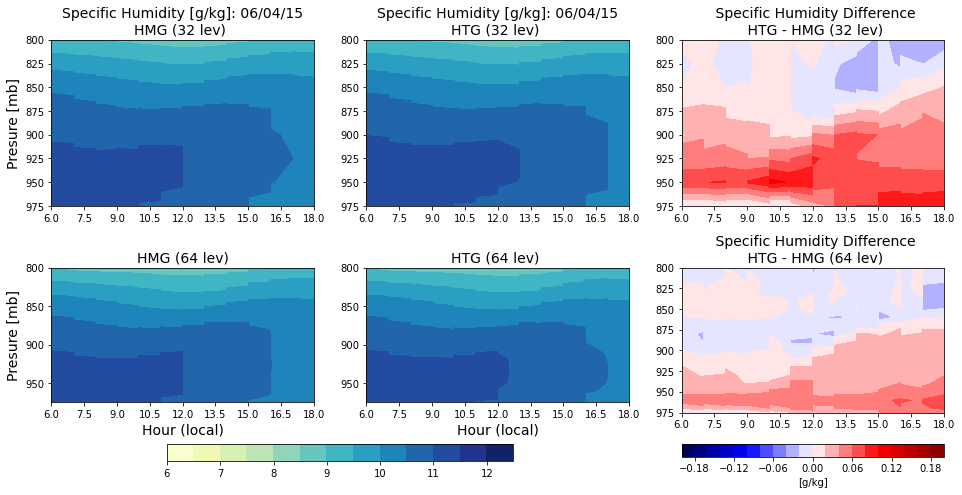

In [139]:

fig, axs_all = plt.subplots(2,3, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

#Tlevs = np.arange(0.0020,0.01,0.0005)
Qlevs = np.arange(6.0,13.0,0.5)
Qdiff_levs = np.arange(-0.2,0.22,0.02)

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(np.nanmean(np.squeeze(dailyQ_hmg32)*1000.0, axis=0)), Qlevs,
                      cmap='YlGnBu')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('Specific Humidity [g/kg]: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(np.nanmean(np.squeeze(dailyQ_htg32)*1000.0, axis=0)), Qlevs,
                      cmap='YlGnBu')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('Specific Humidity [g/kg]: 06/04/15\nHTG (32 lev) ', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel
diff_32 = (np.nanmean(np.squeeze(dailyQ_htg32)*1000.0, axis=0) - np.nanmean(np.squeeze(dailyQ_hmg32)*1000.0, axis=0))
cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(diff_32), Qdiff_levs,
                      cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' Specific Humidity Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()


# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(np.nanmean(np.squeeze(dailyQ_hmg64)*1000.0, axis=0)), Qlevs,
                       cmap='YlGnBu')
axs[3].set_ylim([800,975])

axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,)

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(np.nanmean(np.squeeze(dailyQ_htg64)*1000.0, axis=0)), Qlevs,
                      cmap='YlGnBu')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev) ', fontsize=14)
axs[4].invert_yaxis()

# Plot difference in third panel
diff_128 = (np.nanmean(np.squeeze(dailyQ_htg64)*1000.0, axis=0) - np.nanmean(np.squeeze(dailyQ_hmg64)*1000.0, axis=0))
cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_128), Qdiff_levs,
                      cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title(' Specific Humidity Difference\n HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = '[g/kg]')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])



(6.0, 18.0)

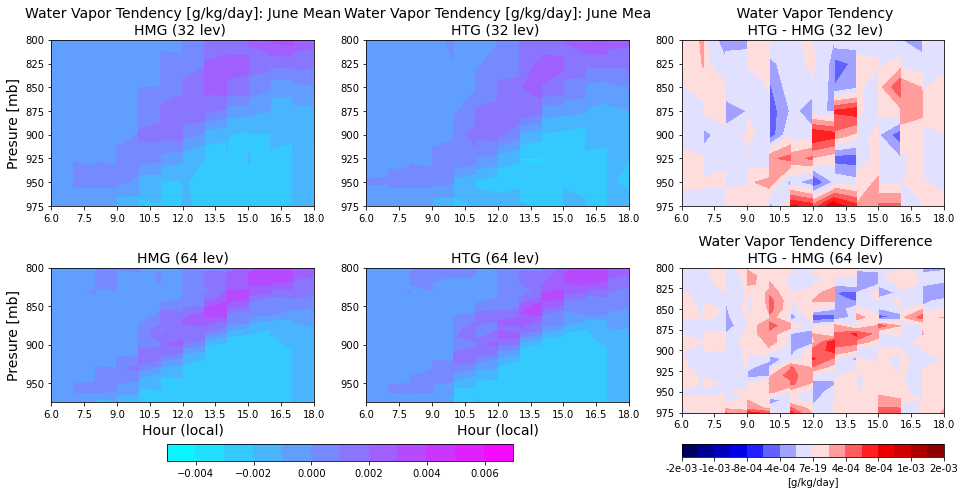

In [149]:

fig, axs_all = plt.subplots(2,3, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

#Tlevs = np.arange(0.0020,0.01,0.0005)
RVMlevs      = np.arange(-0.005,0.008,0.001)
RVMdiff_levs = np.arange(-0.0016,0.0018,0.0002)

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.nanmean(np.squeeze(dailyRVMTEND_hmg32)*86400.0, axis=0)),
                       RVMlevs,
                       cmap='cool')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('Water Vapor Tendency [g/kg/day]: June Mean\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.nanmean(np.squeeze(dailyRVMTEND_htg32)*86400.0, axis=0)), 
                       RVMlevs,
                       cmap='cool')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('Water Vapor Tendency [g/kg/day]: June Mea\nHTG (32 lev) ', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel
diff_32 = (np.nanmean(np.squeeze(dailyRVMTEND_htg32)*86400.0, axis=0) - np.nanmean(np.squeeze(dailyRVMTEND_hmg32)*86400.0, axis=0))
cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(diff_32), 
                          RVMdiff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' Water Vapor Tendency\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()


# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.nanmean(np.squeeze(dailyRVMTEND_hmg64)*86400.0, axis=0)), 
                       RVMlevs,
                       cmap='cool')
axs[3].set_ylim([800,975])

axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,)

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.nanmean(np.squeeze(dailyRVMTEND_htg64)*86400.0, axis=0)), 
                       RVMlevs,
                       cmap='cool')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev) ', fontsize=14)
axs[4].invert_yaxis()

# Plot difference in third panel
diff_128 = (np.nanmean(np.squeeze(dailyRVMTEND_htg64)*86400.0, axis=0) - np.nanmean(np.squeeze(dailyRVMTEND_hmg64)*86400.0, axis=0))
cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_128), 
                          RVMdiff_levs,
                      cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title(' Water Vapor Tendency Difference\n HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = '[g/kg/day]',format='%.0e')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])





**Look at means over subset periods (early/late dry and wet period)**

In [20]:
# Pick out a day to get times right 
timeSel     = np.where((timesHMG_32local.day==4))[0]

In [ ]:
# Max dQDz as PBLH proxy
earlyPeriod_DQDZdiff64 = np.nanmean( (dailyDQDZmax_htg64[0:11,:] - dailyDQDZmax_hmg64[0:11,:]), axis=0)
wetPeriod_DQDZdiff64   = np.nanmean( (dailyDQDZmax_htg64[11:20,:] - dailyDQDZmax_hmg64[11:20,:]), axis=0)
latePeriod_DQDZdiff64  = np.nanmean( (dailyDQDZmax_htg64[20::,:] - dailyDQDZmax_hmg64[20::,:]), axis=0)

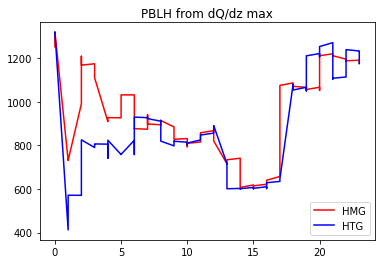

In [98]:
plt.plot(timesHMG_32local[timeSel].hour, earlyPeriod_DQDZhmg64,'r')
plt.plot(timesHMG_32local[timeSel].hour, earlyPeriod_DQDZhtg64, 'b')
plt.title('PBLH from dQ/dz max')
plt.legend(['HMG','HTG'])

In [116]:
htgDS_32.ilev.values

array([   2.25523952,    5.03169186,   10.15794743,   18.55531707,
         29.7346756 ,   39.27300125,   47.11449891,   56.24049902,
         66.80049747,   80.70141822,   94.94104236,  111.6932109 ,
        131.40127063,  154.58680689,  181.86335266,  213.95282075,
        251.70441717,  296.11721635,  348.36658835,  409.83521938,
        482.14992881,  567.22442061,  652.33296901,  730.44589162,
        796.36307061,  845.35366669,  873.71586636,  900.32463148,
        924.96446241,  947.43233453,  967.53862454,  985.11219025,
       1000.        ])

Text(0.5, 1.0, 'WP2')

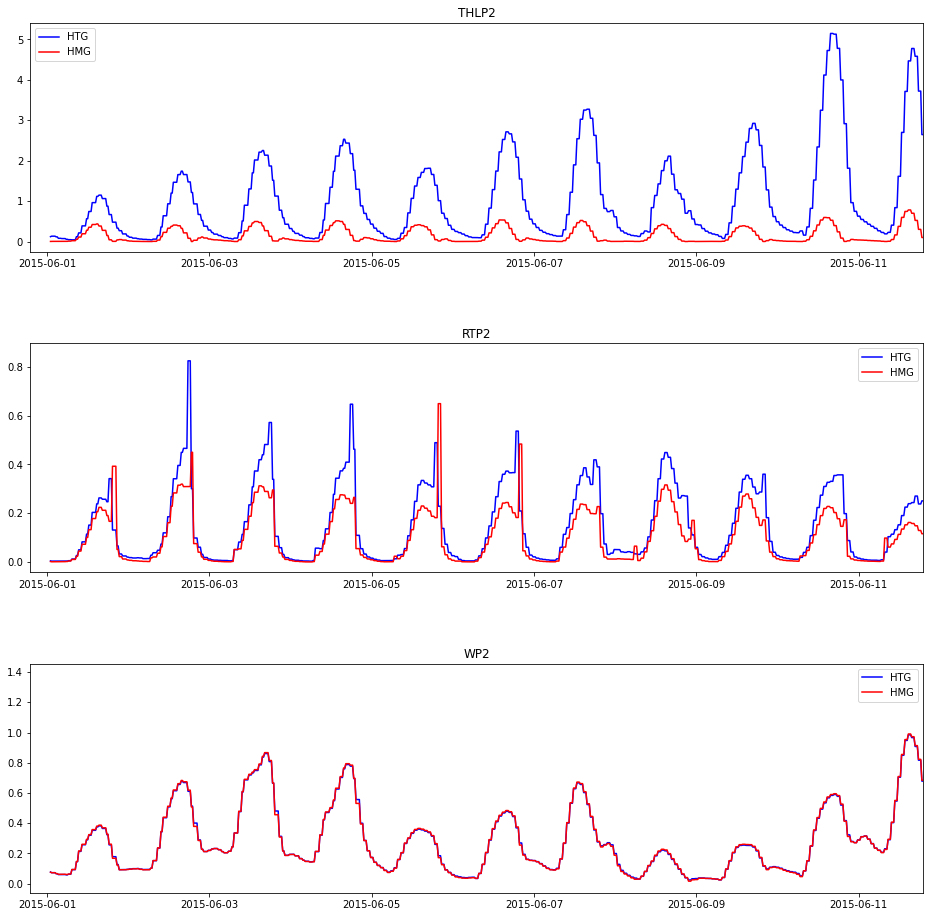

In [123]:
fig, axs_all = plt.subplots(3,1, figsize=(16, 16),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.4,wspace=0.3)


axs[0].plot(timesHTG_32local, np.squeeze(htgDS_64.THLP2_CLUBB.values)[:,-1],'b',label='HTG')
axs[0].plot(timesHTG_32local, np.squeeze(hmgDS_64.THLP2_CLUBB.values)[:,-1],'r',label='HMG')
axs[0].set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,12))
axs[0].legend()
axs[0].set_title('THLP2')

axs[1].plot(timesHTG_32local, np.squeeze(htgDS_64.RTP2_CLUBB.values)[:,-1],'b',label='HTG')
axs[1].plot(timesHTG_32local, np.squeeze(hmgDS_64.RTP2_CLUBB.values)[:,-1],'r',label='HMG')
axs[1].set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,12))
axs[1].legend()
axs[1].set_title('RTP2')

axs[2].plot(timesHTG_32local, np.squeeze(htgDS_64.WP2_CLUBB.values)[:,-1],'b',label='HTG')
axs[2].plot(timesHTG_32local, np.squeeze(hmgDS_64.WP2_CLUBB.values)[:,-1],'r',label='HMG')
axs[2].set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,12))
axs[2].legend()
axs[2].set_title('WP2')

# ax1.plot(timesHTG_32local,np.squeeze(htgDS_32.PBLH.values)[:],'b',label='HET-32',alpha=0.9)
# ax1.plot(timesHTG_32local,np.squeeze(hmgDS_32.PBLH.values)[:],'r',label='HOM-32',alpha=0.6)


Text(0.5, 1.0, 'Mean WP2\nEarly Period')

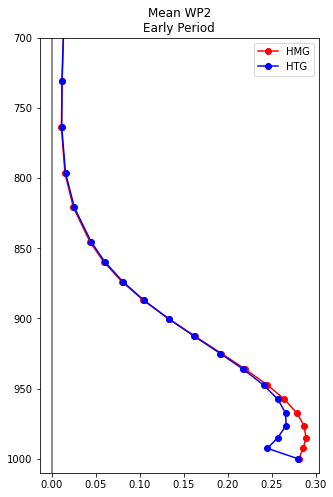

In [140]:
# Plot mean vertical profiles in morning? (8-10a local)
iMorning     = np.where((timesHMG_32local[timeSel].hour>=8) & (timesHMG_32local[timeSel].hour<10))[0]

fig, axs_all = plt.subplots(1,1, figsize=(5, 8),
                     facecolor='w', edgecolor='k')



axs_all.plot(np.nanmean(np.squeeze(hmgDS_64.WP2_CLUBB.values), axis=0), htgDS_64.ilev.values,'o-',color='r',label='HMG')
axs_all.plot(np.nanmean(np.squeeze(htgDS_64.WP2_CLUBB.values), axis=0), htgDS_64.ilev.values,'o-',color='b',label='HTG')
axs_all.axvline(0,color='dimgrey')
axs_all.set_ylim([700,1010])
axs_all.invert_yaxis()
axs_all.legend()
# axs[0].set_xlim([-15e-5,15e-5])
# axs[0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
# axs[0].set_ylabel('Pressure level [mb]')
# axs[0].set_xlabel('HTG-HMG Specific Humidity [g/kg]')
axs_all.set_title('Mean WP2\nEarly Period')


Text(0.5, 1.0, 'WP2')

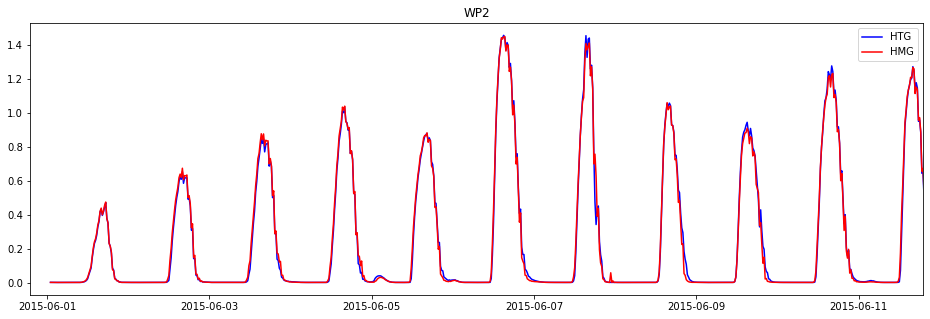

In [127]:
fig, ax0 = plt.subplots(1,1, figsize=(16, 5),
                     facecolor='w', edgecolor='k')

ax0.plot(timesHTG_32local, np.squeeze(htgDS_64.WP2_CLUBB.values)[:,-10],'b',label='HTG')
ax0.plot(timesHTG_32local, np.squeeze(hmgDS_64.WP2_CLUBB.values)[:,-10],'r',label='HMG')
ax0.set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,12))
ax0.legend()
ax0.set_title('WP2')

Text(0.5, 1.0, 'LHFLX')

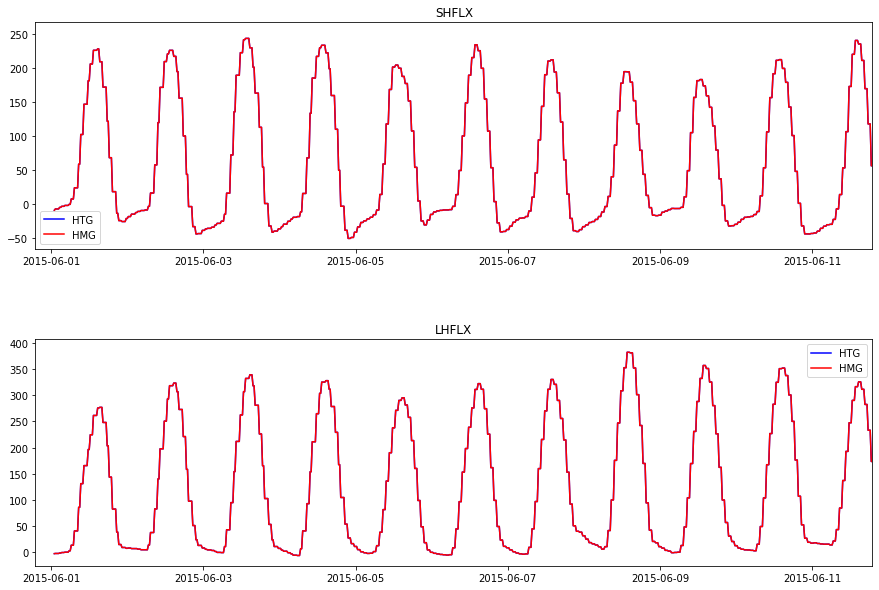

In [144]:
fig, axs_all = plt.subplots(2,1, figsize=(15, 10),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.4,wspace=0.3)


axs[0].plot(timesHTG_32local, np.squeeze(htgDS_32.SHFLX.values)[:],'b',label='HTG')
axs[0].plot(timesHTG_32local, np.squeeze(hmgDS_32.SHFLX.values)[:],'r',label='HMG')
axs[0].set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,12))
axs[0].legend()
axs[0].set_title('SHFLX')

axs[1].plot(timesHTG_32local, np.squeeze(htgDS_32.LHFLX.values)[:],'b',label='HTG')
axs[1].plot(timesHTG_32local, np.squeeze(hmgDS_32.LHFLX.values)[:],'r',label='HMG')
axs[1].set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,12))
axs[1].legend()
axs[1].set_title('LHFLX')



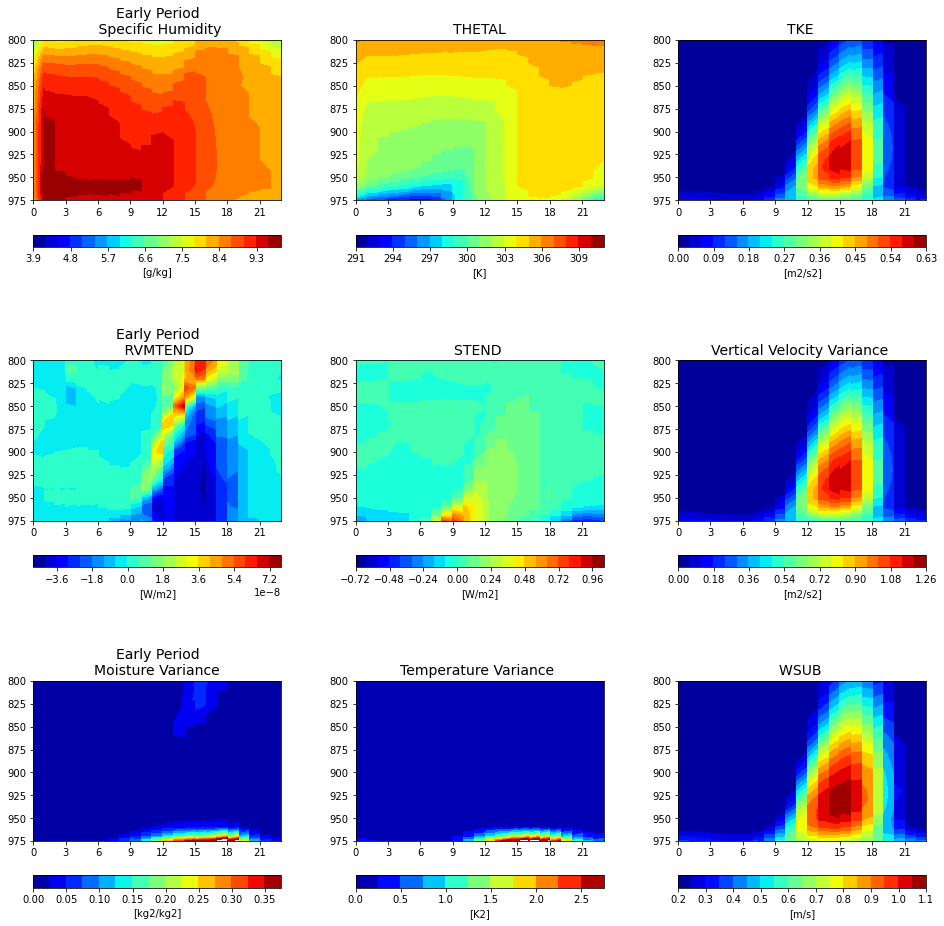

In [104]:
fig, axs_all = plt.subplots(3,3, figsize=(16, 16),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.4,wspace=0.3)

# Define contour levels
#Qdiff_levs = np.arange(-0.5,0.55,0.05)
Qdiff_levs = 20
Tdiff_levs = 20
TKEdiff_levs = 20
buoyDiff_levs = 20
moistFluxDiff_levs = 20
tempFluxDiff_levs  = 20
vertVelDiff_levs   = 20
RVMTENDlevs = 20
STENDlevs = 20

# --- Plot differences (HTG-HMG) defined above ---

# Plot difference in moisture (specific humidity)
cmap    = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_Qhtg*1000.0), Qdiff_levs,
                      cmap='jet')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_title('Early Period\n Specific Humidity', fontsize=14)
axs[0].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,0],orientation='horizontal',label = '[g/kg]')
# axs2 = axs[0].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in temperature (THETAL)
cmap    = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_THLPhtg64), Tdiff_levs,
                      cmap='jet')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('THETAL', fontsize=14)
axs[1].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,1],orientation='horizontal',label = '[K]')
# axs2 = axs[1].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in TKE
cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_TKEhtg64), TKEdiff_levs,
                      cmap='jet')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title('TKE ', fontsize=14)
axs[2].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[m2/s2]')
# axs2 = axs[2].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])



# # Plot difference in Buoyancy Flux
# cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_WPTHLPdiff64), buoyDiff_levs,
#                       cmap='seismic')
# axs[2].set_ylim([800,975])
# axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
# axs[2].set_title('Buoyancy Flux Difference', fontsize=14)
# axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[W/m2]')
# axs2 = axs[2].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in moisture flux
cmap    = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_RVMTENDhtg64), RVMTENDlevs,
                      cmap='jet')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_title('Early Period\n RVMTEND', fontsize=14)
axs[3].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,0],orientation='horizontal',label = '[W/m2]')
# axs2 = axs[3].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in temperature flux
cmap    = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_STENDhtg64), STENDlevs,
                      cmap='jet')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_title('STEND ', fontsize=14)
axs[4].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,1],orientation='horizontal',label = '[W/m2]')
# axs2 = axs[4].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in vertical velocity
cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_WP2htg64), vertVelDiff_levs,
                      cmap='jet')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('Vertical Velocity Variance ', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = '[m2/s2]')
# axs2 = axs[5].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# ------- Third row ------
rtp2Diff_levs = np.arange(0,0.4,0.025)
thlp2Diff_levs = np.arange(0,3,0.25)
wsubDiff_levs = 20

# Plot difference in RTP2
cmap    = axs[6].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_RTP2htg64), rtp2Diff_levs,
                      cmap='jet')
axs[6].set_ylim([800,975])
axs[6].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[6].set_title('Early Period\nMoisture Variance', fontsize=14)
axs[6].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[2,0],orientation='horizontal',label = '[kg2/kg2]')
# axs2 = axs[5].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in THLP2
cmap    = axs[7].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_THLP2htg64), thlp2Diff_levs,
                      cmap='jet')
axs[7].set_ylim([800,975])
axs[7].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[7].set_title('Temperature Variance ', fontsize=14)
axs[7].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[2,1],orientation='horizontal',label = '[K2]')
# axs2 = axs[5].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in WSUB
cmap    = axs[8].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_WSUBhtg64), wsubDiff_levs,
                      cmap='jet')
axs[8].set_ylim([800,975])
axs[8].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[8].set_title('WSUB ', fontsize=14)
axs[8].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[2,2],orientation='horizontal',label = '[m/s]')
# axs2 = axs[5].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])




# Limit x axis?
# axs[0].set_xlim([6,19])
# axs[1].set_xlim([6,19])
# axs[2].set_xlim([6,19])
# axs[3].set_xlim([6,19])
# axs[4].set_xlim([6,19])
# axs[5].set_xlim([6,19])
# axs[6].set_xlim([6,19])
# axs[7].set_xlim([6,19])
# axs[8].set_xlim([6,19])




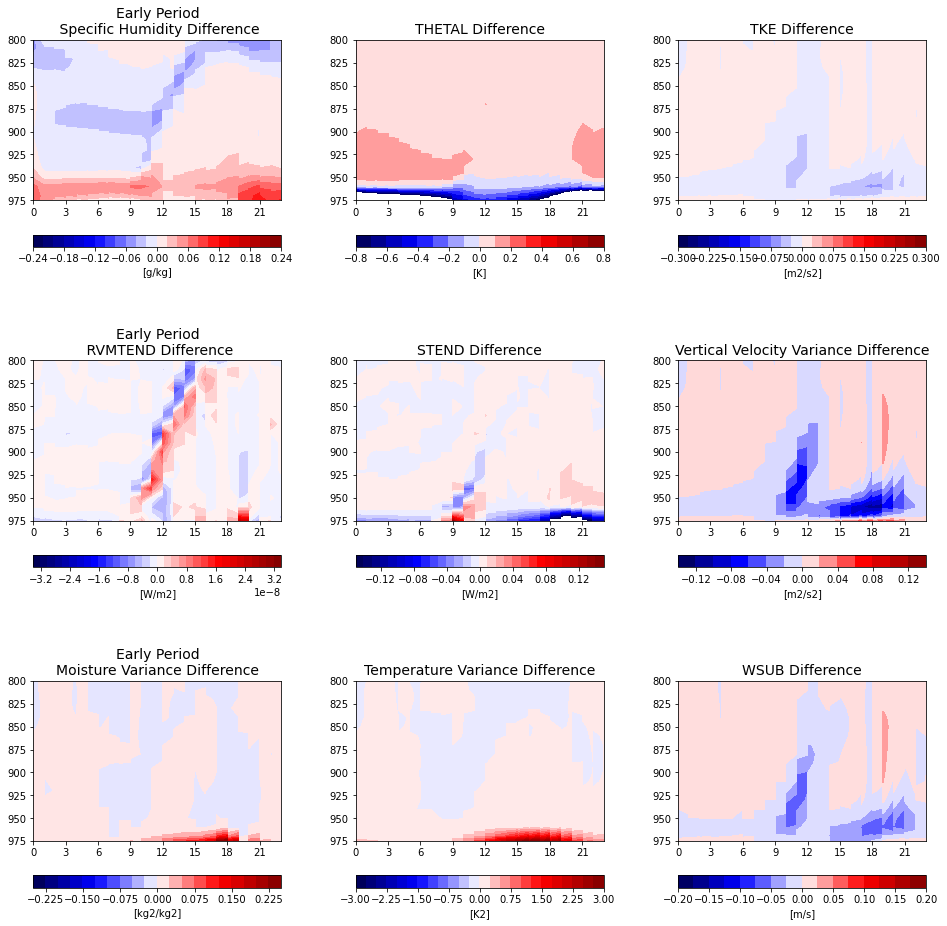

In [37]:
fig, axs_all = plt.subplots(3,3, figsize=(16, 16),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.4,wspace=0.3)

# Define contour levels
#Qdiff_levs = np.arange(-0.5,0.55,0.05)
Qdiff_levs = np.arange(-0.24,0.26,0.02)
Tdiff_levs = np.arange(-0.8,0.9,0.1)
TKEdiff_levs = np.arange(-0.3,0.325,0.025)
buoyDiff_levs = np.arange(-30,32,2)
moistFluxDiff_levs = np.arange(-30,32,2)
tempFluxDiff_levs  = np.arange(-30,32,2)
vertVelDiff_levs   = np.arange(-0.14,0.14,0.02)
RVMTENDlevs = np.arange(-3.4e-8, 3.6e-8, 0.2e-8)
STENDlevs = np.arange(-0.15,0.16,0.01)

# --- Plot differences (HTG-HMG) defined above ---

# Plot difference in moisture (specific humidity)
cmap    = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_Qdiff64*1000.0), Qdiff_levs,
                      cmap='seismic')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_title('Early Period\n Specific Humidity Difference', fontsize=14)
axs[0].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,0],orientation='horizontal',label = '[g/kg]')
# axs2 = axs[0].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in temperature (THETAL)
cmap    = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_THLPdiff64), Tdiff_levs,
                      cmap='seismic')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('THETAL Difference', fontsize=14)
axs[1].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,1],orientation='horizontal',label = '[K]')
# axs2 = axs[1].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in TKE
cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_TKEdiff64), TKEdiff_levs,
                      cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title('TKE Difference', fontsize=14)
axs[2].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[m2/s2]')
# axs2 = axs[2].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])



# # Plot difference in Buoyancy Flux
# cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_WPTHLPdiff64), buoyDiff_levs,
#                       cmap='seismic')
# axs[2].set_ylim([800,975])
# axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
# axs[2].set_title('Buoyancy Flux Difference', fontsize=14)
# axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[W/m2]')
# axs2 = axs[2].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in moisture flux
cmap    = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_RVMTENDdiff64), RVMTENDlevs,
                      cmap='seismic')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_title('Early Period\n RVMTEND Difference', fontsize=14)
axs[3].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,0],orientation='horizontal',label = '[W/m2]')
# axs2 = axs[3].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in temperature flux
cmap    = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_STENDdiff64), STENDlevs,
                      cmap='seismic')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_title('STEND Difference', fontsize=14)
axs[4].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,1],orientation='horizontal',label = '[W/m2]')
# axs2 = axs[4].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in vertical velocity
cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_WP2diff64), vertVelDiff_levs,
                      cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('Vertical Velocity Variance Difference', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = '[m2/s2]')
# axs2 = axs[5].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# ------- Third row ------
rtp2Diff_levs = np.arange(-0.25,0.275,0.025)
thlp2Diff_levs = np.arange(-3,3.25,0.25)
wsubDiff_levs = np.arange(-0.2,0.225,0.025)

# Plot difference in RTP2
cmap    = axs[6].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_RTP2diff64), rtp2Diff_levs,
                      cmap='seismic')
axs[6].set_ylim([800,975])
axs[6].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[6].set_title('Early Period\nMoisture Variance Difference', fontsize=14)
axs[6].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[2,0],orientation='horizontal',label = '[kg2/kg2]')
# axs2 = axs[5].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in THLP2
cmap    = axs[7].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_THLP2diff64), thlp2Diff_levs,
                      cmap='seismic')
axs[7].set_ylim([800,975])
axs[7].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[7].set_title('Temperature Variance Difference', fontsize=14)
axs[7].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[2,1],orientation='horizontal',label = '[K2]')
# axs2 = axs[5].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in WSUB
cmap    = axs[8].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_WSUBdiff64), wsubDiff_levs,
                      cmap='seismic')
axs[8].set_ylim([800,975])
axs[8].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[8].set_title('WSUB Difference', fontsize=14)
axs[8].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[2,2],orientation='horizontal',label = '[m/s]')
# axs2 = axs[5].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])




# Limit x axis?
# axs[0].set_xlim([6,19])
# axs[1].set_xlim([6,19])
# axs[2].set_xlim([6,19])
# axs[3].set_xlim([6,19])
# axs[4].set_xlim([6,19])
# axs[5].set_xlim([6,19])
# axs[6].set_xlim([6,19])
# axs[7].set_xlim([6,19])
# axs[8].set_xlim([6,19])



(6.0, 19.0)

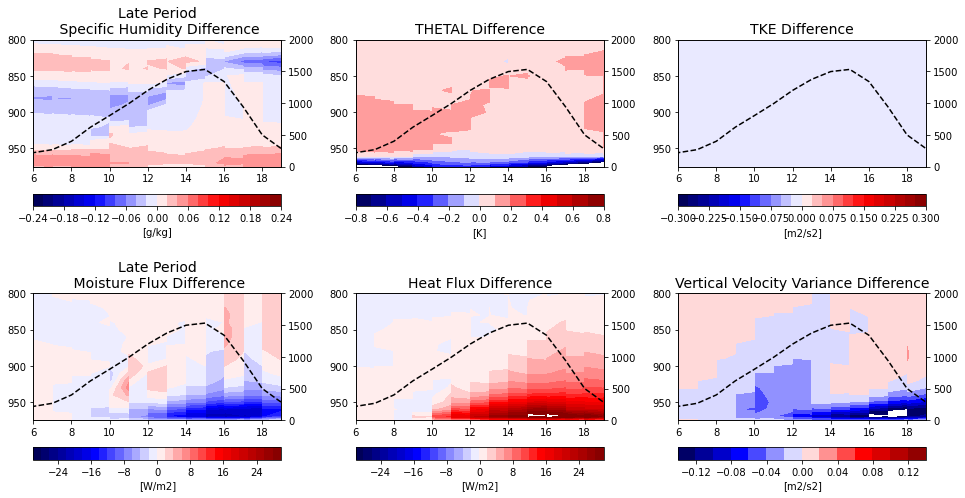

In [161]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.4,wspace=0.3)

# Define contour levels
Qdiff_levs = np.arange(-0.24,0.26,0.02)
Tdiff_levs = np.arange(-0.8,0.9,0.1)
TKEdiff_levs = np.arange(-0.3,0.325,0.025)
buoyDiff_levs = np.arange(-30,32,2)
moistFluxDiff_levs = np.arange(-30,32,2)
tempFluxDiff_levs  = np.arange(-30,32,2)
vertVelDiff_levs   = np.arange(-0.14,0.14,0.02)

# --- Plot differences (HTG-HMG) defined above ---

# Plot difference in moisture (specific humidity)
cmap    = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(latePeriod_Qdiff64*1000.0), Qdiff_levs,
                      cmap='seismic')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_title('Late Period\n Specific Humidity Difference', fontsize=14)
axs[0].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,0],orientation='horizontal',label = '[g/kg]')
axs2 = axs[0].twinx()
axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_lateDry,color='k',linestyle='--',label='HTG')
axs2.set_ylim([0,2000])

# Plot difference in temperature (THETAL)
cmap    = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(latePeriod_THLPdiff64), Tdiff_levs,
                      cmap='seismic')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('THETAL Difference', fontsize=14)
axs[1].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,1],orientation='horizontal',label = '[K]')
axs2 = axs[1].twinx()
axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_lateDry,color='k',linestyle='--',label='HTG')
axs2.set_ylim([0,2000])

# Plot difference in TKE
cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(latePeriod_TKEdiff64), TKEdiff_levs,
                      cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title('TKE Difference', fontsize=14)
axs[2].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[m2/s2]')
axs2 = axs[2].twinx()
axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_lateDry,color='k',linestyle='--',label='HTG')
axs2.set_ylim([0,2000])




# # Plot difference in Buoyancy Flux
# cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(latePeriod_WPTHLPdiff64), buoyDiff_levs,
#                       cmap='seismic')
# axs[2].set_ylim([800,975])
# axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
# axs[2].set_title('Buoyancy Flux Difference', fontsize=14)
# axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[W/m2]')
# axs2 = axs[2].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_lateDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in moisture flux
cmap    = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(latePeriod_WPRTPdiff64), moistFluxDiff_levs,
                      cmap='seismic')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_title('Late Period\n Moisture Flux Difference', fontsize=14)
axs[3].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,0],orientation='horizontal',label = '[W/m2]')
axs2 = axs[3].twinx()
axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_lateDry,color='k',linestyle='--',label='HTG')
axs2.set_ylim([0,2000])

# Plot difference in temperature flux
cmap    = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(latePeriod_WPTHLPdiff64), tempFluxDiff_levs,
                      cmap='seismic')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_title('Heat Flux Difference', fontsize=14)
axs[4].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,1],orientation='horizontal',label = '[W/m2]')
axs2 = axs[4].twinx()
axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_lateDry,color='k',linestyle='--',label='HTG')
axs2.set_ylim([0,2000])

# Plot difference in vertical velocity
cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(latePeriod_WP2diff64), vertVelDiff_levs,
                      cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('Vertical Velocity Variance Difference', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = '[m2/s2]')
axs2 = axs[5].twinx()
axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_lateDry,color='k',linestyle='--',label='HTG')
axs2.set_ylim([0,2000])


# Limit x axis?
axs[0].set_xlim([6,19])
axs[1].set_xlim([6,19])
axs[2].set_xlim([6,19])
axs[3].set_xlim([6,19])
axs[4].set_xlim([6,19])
axs[5].set_xlim([6,19])




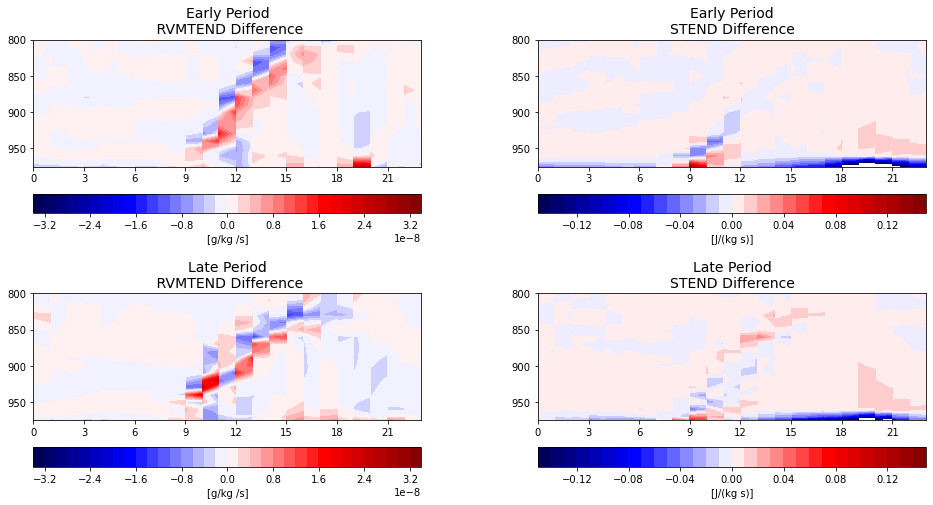

In [157]:
fig, axs_all = plt.subplots(2,2, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.4,wspace=0.3)

# Define contour levels
RVMTENDlevs = np.arange(-3.4e-8, 3.6e-8, 0.2e-8)
STENDlevs = np.arange(-0.15,0.16,0.01)

# --- Plot differences (HTG-HMG) defined above ---

# Plot difference in moisture (specific humidity)
cmap    = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_RVMTENDdiff64), RVMTENDlevs,
                      cmap='seismic')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_title('Early Period\n RVMTEND Difference', fontsize=14)
axs[0].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,0],orientation='horizontal',label = '[g/kg /s]')
# axs2 = axs[0].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in temperature (THETAL)
cmap    = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_STENDdiff64), STENDlevs,
                      cmap='seismic')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('Early Period\nSTEND Difference', fontsize=14)
axs[1].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,1],orientation='horizontal',label = '[J/(kg s)]')
# axs2 = axs[1].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_lateDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# -- Late period --
# Plot difference in moisture (specific humidity)
cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(latePeriod_RVMTENDdiff64), RVMTENDlevs,
                      cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title('Late Period\n RVMTEND Difference', fontsize=14)
axs[2].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,0],orientation='horizontal',label = '[g/kg /s]')
# axs2 = axs[0].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in temperature (THETAL)
cmap    = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(latePeriod_STENDdiff64), STENDlevs,
                      cmap='seismic')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_title('Late Period\nSTEND Difference', fontsize=14)
axs[3].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,1],orientation='horizontal',label = '[J/(kg s)]')
# axs2 = axs[1].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_lateDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])


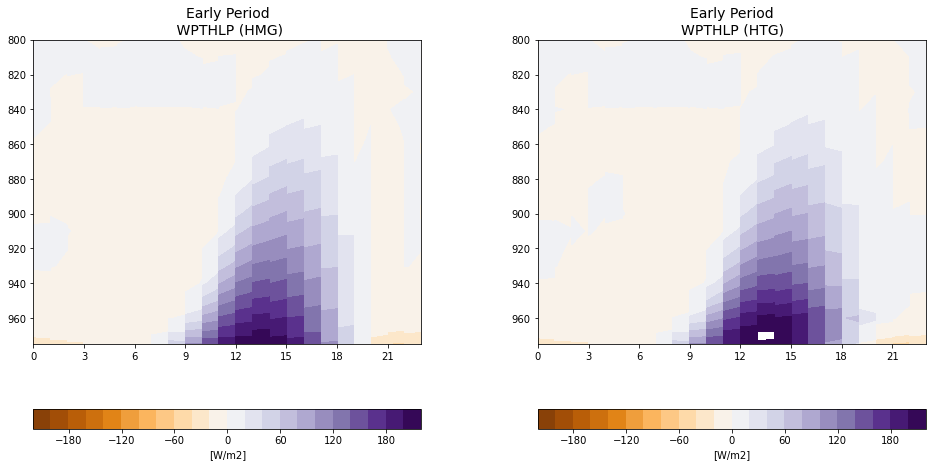

In [175]:
fig, axs_all = plt.subplots(1,2, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.4,wspace=0.3)

# Define contour levels
# RVMTENDlevs = np.arange(-3.4e-8, 3.6e-8, 0.2e-8)
# STENDlevs = np.arange(-0.15,0.16,0.01)
levs=np.arange(-220,240,20)

# --- Plot differences (HTG-HMG) defined above ---

# Plot difference in moisture (specific humidity)
cmap    = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_WPTHLPhmg64), levs,
                      cmap='PuOr')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_title('Early Period\n WPTHLP (HMG)', fontsize=14)
axs[0].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0],orientation='horizontal',label = '[W/m2]')
# axs2 = axs[0].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])

# Plot difference in temperature (THETAL)
cmap    = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_WPTHLPhtg64), levs,
                      cmap='PuOr')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('Early Period\nWPTHLP (HTG)', fontsize=14)
axs[1].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1],orientation='horizontal',label = '[W/m2]')
# axs2 = axs[1].twinx()
# axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_lateDry,color='k',linestyle='--',label='HTG')
# axs2.set_ylim([0,2000])




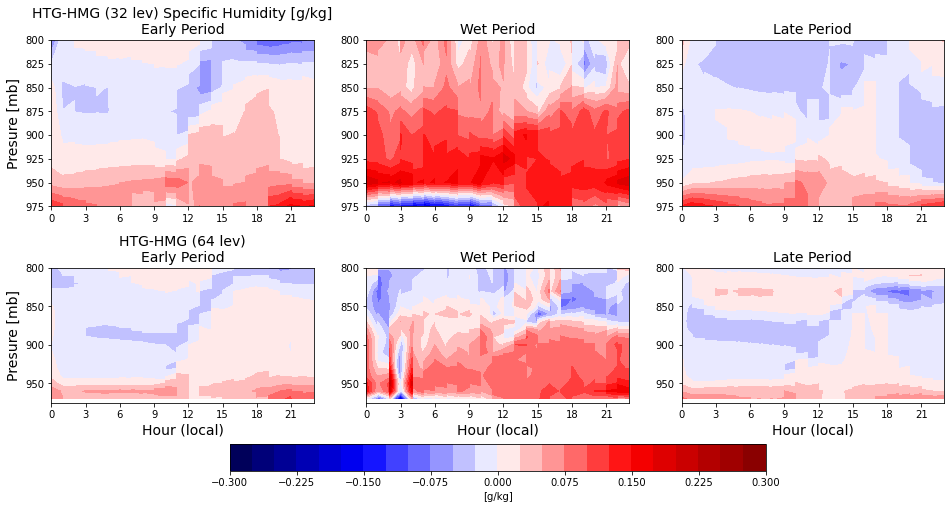

In [242]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

#Tlevs = np.arange(0.0020,0.01,0.0005)
Qlevs = np.arange(3.0,11.0,0.5)
Qdiff_levs = np.arange(-0.3,0.325,0.025)

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(earlyPeriod_Qdiff32*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('HTG-HMG (32 lev) Specific Humidity [g/kg]\nEarly Period', fontsize=14)
axs[0].invert_yaxis()

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(wetPeriod_Qdiff32*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('\nWet Period', fontsize=14)
axs[1].invert_yaxis()

cmap = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(latePeriod_Qdiff32*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title('\nLate Period', fontsize=14)
axs[2].invert_yaxis()

# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_Qdiff64*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[3].set_ylim([800,975])

axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HTG-HMG (64 lev)\nEarly Period', fontsize=14)
axs[3].invert_yaxis()

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(wetPeriod_Qdiff64*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('\nWet Period', fontsize=14)
axs[4].invert_yaxis()

fig.colorbar(cmap,ax=axs_all[1,:],orientation='horizontal',pad=0.2,shrink=0.6,label='[g/kg]')


cmap = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(latePeriod_Qdiff64*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_xlabel('Hour (local)',fontsize=14)
axs[5].set_title('\nLate Period', fontsize=14)
axs[5].invert_yaxis()


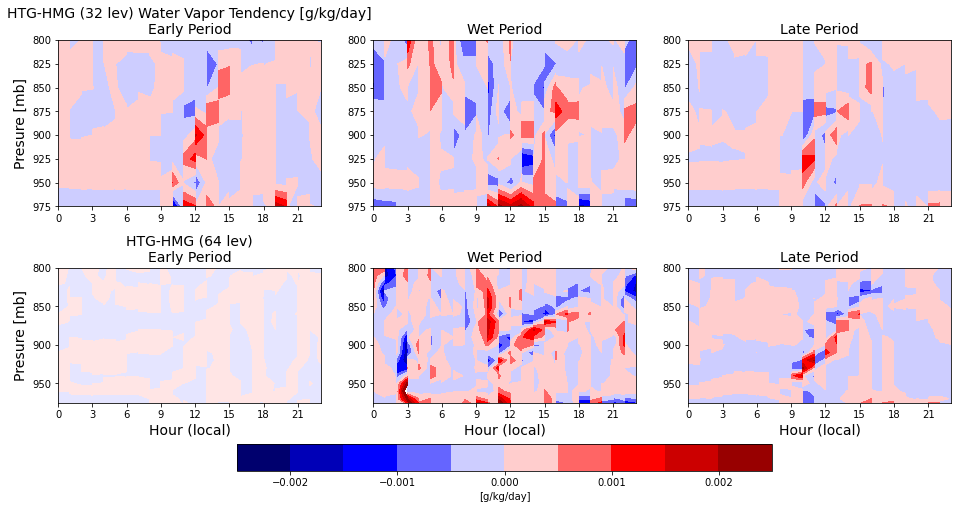

In [117]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

diff_levs = np.arange(-0.0025,0.0030,0.0005)

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(earlyPeriod_RVMTENDdiff32*86400.0), 
                       diff_levs,
                       cmap='seismic')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('HTG-HMG (32 lev) Water Vapor Tendency [g/kg/day]\nEarly Period', fontsize=14)
axs[0].invert_yaxis()

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(wetPeriod_RVMTENDdiff32*86400.0), 
                       diff_levs,
                       cmap='seismic')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('\nWet Period', fontsize=14)
axs[1].invert_yaxis()

cmap = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(latePeriod_RVMTENDdiff32*86400.0), 
                       diff_levs,
                       cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title('\nLate Period', fontsize=14)
axs[2].invert_yaxis()

# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_RVMTENDdiff64*86400.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[3].set_ylim([800,975])

axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HTG-HMG (64 lev)\nEarly Period', fontsize=14)
axs[3].invert_yaxis()

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(wetPeriod_RVMTENDdiff64*86400.0), 
                       diff_levs,
                       cmap='seismic')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('\nWet Period', fontsize=14)
axs[4].invert_yaxis()

fig.colorbar(cmap,ax=axs_all[1,:],orientation='horizontal',pad=0.2,shrink=0.6,label='[g/kg/day]')


cmap = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(latePeriod_RVMTENDdiff64*86400.0), 
                       diff_levs,
                       cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_xlabel('Hour (local)',fontsize=14)
axs[5].set_title('\nLate Period', fontsize=14)
axs[5].invert_yaxis()


Text(0.5, 1.0, '8-10a Mean Specific Humidity [HTG-HMG]\nLate Period')

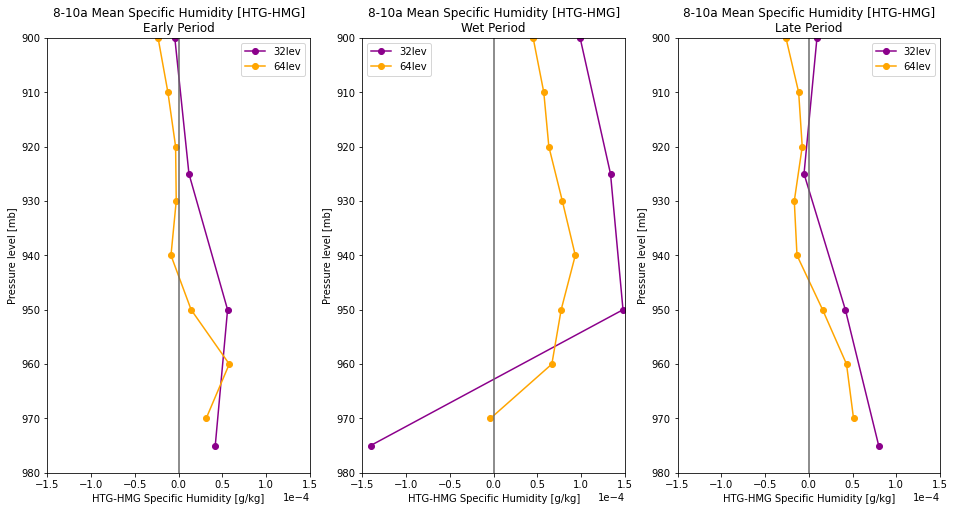

In [276]:
# Plot mean vertical profiles in morning? (8-10a local)
iMorning     = np.where((timesHMG_32local[timeSel].hour>=8) & (timesHMG_32local[timeSel].hour<10))[0]

fig, axs_all = plt.subplots(1,3, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)


axs[0].plot(np.nanmean(earlyPeriod_Qdiff32[iMorning,:], axis=0), pnew32,'o-',color='darkmagenta',label='32lev')
axs[0].plot(np.nanmean(earlyPeriod_Qdiff64[iMorning,:], axis=0), pnew64,'o-',color='orange',label='64lev')
axs[0].axvline(0,color='dimgrey')
axs[0].set_ylim([900,980])
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_xlim([-15e-5,15e-5])
axs[0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[0].set_ylabel('Pressure level [mb]')
axs[0].set_xlabel('HTG-HMG Specific Humidity [g/kg]')
axs[0].set_title('8-10a Mean Specific Humidity [HTG-HMG]\nEarly Period')

axs[1].plot(np.nanmean(wetPeriod_Qdiff32[iMorning,:], axis=0), pnew32,'o-',color='darkmagenta',label='32lev')
axs[1].plot(np.nanmean(wetPeriod_Qdiff64[iMorning,:], axis=0), pnew64,'o-',color='orange',label='64lev')
axs[1].axvline(0,color='dimgrey')
axs[1].set_ylim([900,980])
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_xlim([-15e-5,15e-5])
axs[1].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[1].set_ylabel('Pressure level [mb]')
axs[1].set_xlabel('HTG-HMG Specific Humidity [g/kg]')
axs[1].set_title('8-10a Mean Specific Humidity [HTG-HMG]\nWet Period')

axs[2].plot(np.nanmean(latePeriod_Qdiff32[iMorning,:], axis=0), pnew32,'o-',color='darkmagenta',label='32lev')
axs[2].plot(np.nanmean(latePeriod_Qdiff64[iMorning,:], axis=0), pnew64,'o-',color='orange',label='64lev')
axs[2].axvline(0,color='dimgrey')
axs[2].set_ylim([900,980])
axs[2].invert_yaxis()
axs[2].legend()
axs[2].set_xlim([-15e-5,15e-5])
axs[2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[2].set_ylabel('Pressure level [mb]')
axs[2].set_xlabel('HTG-HMG Specific Humidity [g/kg]')
axs[2].set_title('8-10a Mean Specific Humidity [HTG-HMG]\nLate Period')


## Comparison over a single day [06/04/2015], which we've used as a case study

In [12]:
timeSel     = np.where((timesHMG_32local.day==4))[0]

hmgDS_32sel = hmgDS_32.isel(time=timeSel)
htgDS_32sel = htgDS_32.isel(time=timeSel)
noMom_sel   = noMomDS.isel(time=timeSel)
hmgDS_64sel = hmgDS_64.isel(time=timeSel)
htgDS_64sel = htgDS_64.isel(time=timeSel)

timeSel_nate = np.where((timesNate_local.year==2015) & (timesNate_local.month==6) & (timesNate_local.day==4))[0]
nateHMG_sel  = nateHMG.isel(time=timeSel_nate)


Plot PBLH evolution

(0.0, 2000.0)

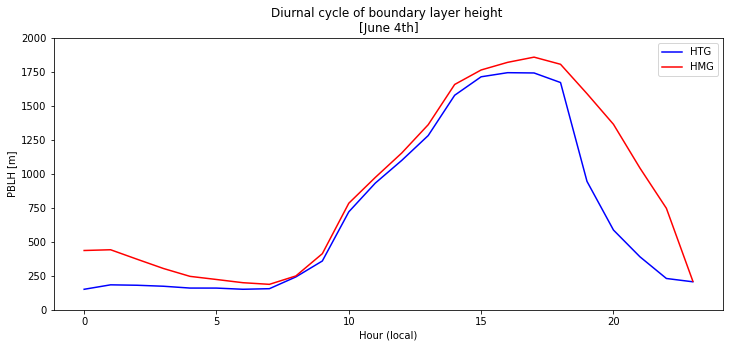

In [18]:
meanDiurnal_HTG64 = htgDS_64sel.groupby("time.hour").mean()
meanDiurnal_HMG64 = hmgDS_64sel.groupby("time.hour").mean()

htg64_diurnalPBL_double = np.full([48], np.nan)
htg64_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_HTG64.PBLH.values)
htg64_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_HTG64.PBLH.values)

hmg64_diurnalPBL_double = np.full([48], np.nan)
hmg64_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_HMG64.PBLH.values)
hmg64_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_HMG64.PBLH.values)

hoursDouble = np.full([48],np.nan)
hoursDouble[0:24] = meanDiurnal_HTG32.hour.values
hoursDouble[24::] = meanDiurnal_HTG32.hour.values+24

fig, ax1 = plt.subplots(1,1, figsize=(12, 5), 
                     facecolor='w', edgecolor='k')


ax1.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBL_double[5:29],color='b',label='HTG')
ax1.plot(meanDiurnal_HTG32.hour.values,hmg64_diurnalPBL_double[5:29],color='r',label='HMG')
ax1.legend()
ax1.set_title('Diurnal cycle of boundary layer height \n[June 4th]')
ax1.set_xlabel('Hour (local)')
ax1.set_ylabel('PBLH [m]')
ax1.set_ylim([0, 2000])



What evolves differently (HTG-HMG) over course of day? 

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [65]:
# Compute difference in moisture (g/kg)
diff_moisture = ((np.squeeze(Q_htg64[timeSel,:,:,:])*1000.0) - (np.squeeze(Q_hmg64[timeSel,:,:,:])*1000.0))

# Compute difference in liquid water potential temeprature (K)
diff_temperature = ((np.squeeze(THETAL_htg64[timeSel,:,:,:])) - (np.squeeze(THETAL_hmg64[timeSel,:,:,:])))

# Compute difference in heat flux (W/m2)
diff_heatFlux = ((np.squeeze(WPTHLP_htg64[timeSel,:,:,:])) - (np.squeeze(WPTHLP_hmg64[timeSel,:,:,:])))

# Compute difference in moisture flux (W/m2)
diff_moistureFlux = ((np.squeeze(WPRTP_htg64[timeSel,:,:,:])) - (np.squeeze(WPRTP_hmg64[timeSel,:,:,:])))

# Compute difference in buoyancy flux (W/m2)
diff_buoyancyFlux = ((np.squeeze(WPTHVP_htg64[timeSel,:,:,:])) - (np.squeeze(WPTHVP_hmg64[timeSel,:,:,:])))

# Compute difference in vertica velocity (Pa/s)
diff_vertVelocity = ((np.squeeze(OMEGA_htg64[timeSel,:,:,:])) - (np.squeeze(OMEGA_hmg64[timeSel,:,:,:])))
# Actually equal to zero everywhere 

# Compute difference in vertica velocity variance (m2/s2)
diff_vertVariance = ((np.squeeze(WP2_htg64[timeSel,:,:,:])) - (np.squeeze(WP2_hmg64[timeSel,:,:,:])))


(6.0, 18.0)

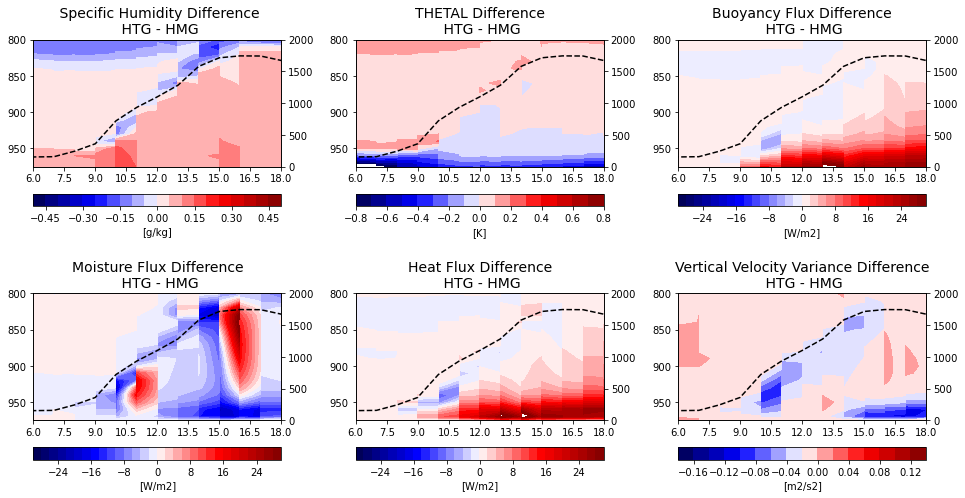

In [66]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.4,wspace=0.3)

# Define contour levels
Qdiff_levs = np.arange(-0.5,0.55,0.05)
Tdiff_levs = np.arange(-0.8,0.9,0.1)
buoyDiff_levs = np.arange(-30,32,2)
moistFluxDiff_levs = np.arange(-30,32,2)
tempFluxDiff_levs  = np.arange(-30,32,2)
vertVelDiff_levs = 20

# --- Plot differences (HTG-HMG) defined above ---

# Plot difference in moisture (specific humidity)
cmap    = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_moisture), Qdiff_levs,
                      cmap='seismic')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_title(' Specific Humidity Difference\n HTG - HMG', fontsize=14)
axs[0].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,0],orientation='horizontal',label = '[g/kg]')
axs2 = axs[0].twinx()
axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBL_double[5:29],color='k',linestyle='--',label='HTG')
axs2.set_ylim([0,2000])

# Plot difference in temperature (THETAL)
cmap    = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_temperature), Tdiff_levs,
                      cmap='seismic')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('THETAL Difference\n HTG - HMG', fontsize=14)
axs[1].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,1],orientation='horizontal',label = '[K]')
axs2 = axs[1].twinx()
axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBL_double[5:29],color='k',linestyle='--',label='HTG')
axs2.set_ylim([0,2000])

# Plot difference in Buoyancy Flux
cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_buoyancyFlux), buoyDiff_levs,
                      cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title('Buoyancy Flux Difference\n HTG - HMG', fontsize=14)
axs[2].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[W/m2]')
axs2 = axs[2].twinx()
axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBL_double[5:29],color='k',linestyle='--',label='HTG')
axs2.set_ylim([0,2000])

# Plot difference in moisture flux
cmap    = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_moistureFlux), moistFluxDiff_levs,
                      cmap='seismic')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_title('Moisture Flux Difference\n HTG - HMG', fontsize=14)
axs[3].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,0],orientation='horizontal',label = '[W/m2]')
axs2 = axs[3].twinx()
axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBL_double[5:29],color='k',linestyle='--',label='HTG')
axs2.set_ylim([0,2000])

# Plot difference in temperature flux
cmap    = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_heatFlux), tempFluxDiff_levs,
                      cmap='seismic')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_title('Heat Flux Difference\n HTG - HMG', fontsize=14)
axs[4].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,1],orientation='horizontal',label = '[W/m2]')
axs2 = axs[4].twinx()
axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBL_double[5:29],color='k',linestyle='--',label='HTG')
axs2.set_ylim([0,2000])

# Plot difference in vertical velocity
cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_vertVariance), vertVelDiff_levs,
                      cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('Vertical Velocity Variance Difference\n HTG - HMG', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = '[m2/s2]')
axs2 = axs[5].twinx()
axs2.plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBL_double[5:29],color='k',linestyle='--',label='HTG')
axs2.set_ylim([0,2000])


# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])


Initial work on all this

In [74]:
# fig, axs1 = plt.subplots(1,1, figsize=(16, 8),
#                      facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace=0.1)

# axs1.plot(timesHMG_32local[timeSel].hour, np.squeeze(hmgDS_32sel.PBLH.values),'r-')


(6.0, 18.0)

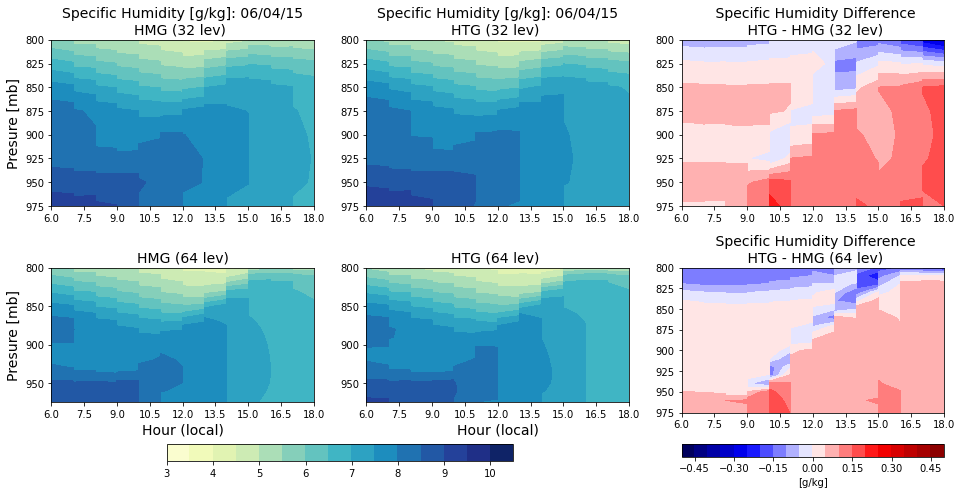

In [102]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs_all = plt.subplots(2,3, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

#Tlevs = np.arange(0.0020,0.01,0.0005)
Qlevs = np.arange(3.0,11.0,0.5)
Qdiff_levs = np.arange(-0.5,0.55,0.05)

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(np.squeeze(Q_hmg32[timeSel,:,:,:])*1000.0), Qlevs,
                      cmap='YlGnBu')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('Specific Humidity [g/kg]: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(np.squeeze(Q_htg32[timeSel,:,:,:])*1000.0), Qlevs,
                      cmap='YlGnBu')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('Specific Humidity [g/kg]: 06/04/15\nHTG (32 lev) ', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel
diff_32 = ((np.squeeze(Q_htg32[timeSel,:,:,:])*1000.0) - (np.squeeze(Q_hmg32[timeSel,:,:,:])*1000.0))
cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(diff_32), Qdiff_levs,
                      cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' Specific Humidity Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()


# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(np.squeeze(Q_hmg64[timeSel,:,:,:])*1000.0), Qlevs,
                       cmap='YlGnBu')
axs[3].set_ylim([800,975])

axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,)

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(np.squeeze(Q_htg64[timeSel,:,:,:])*1000.0), Qlevs,
                      cmap='YlGnBu')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev) ', fontsize=14)
axs[4].invert_yaxis()

# Plot difference in third panel
diff_128 = ((np.squeeze(Q_htg64[timeSel,:,:,:])*1000.0) - (np.squeeze(Q_hmg64[timeSel,:,:,:])*1000.0))
cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_128), Qdiff_levs,
                      cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title(' Specific Humidity Difference\n HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = '[g/kg]')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])




(6.0, 18.0)

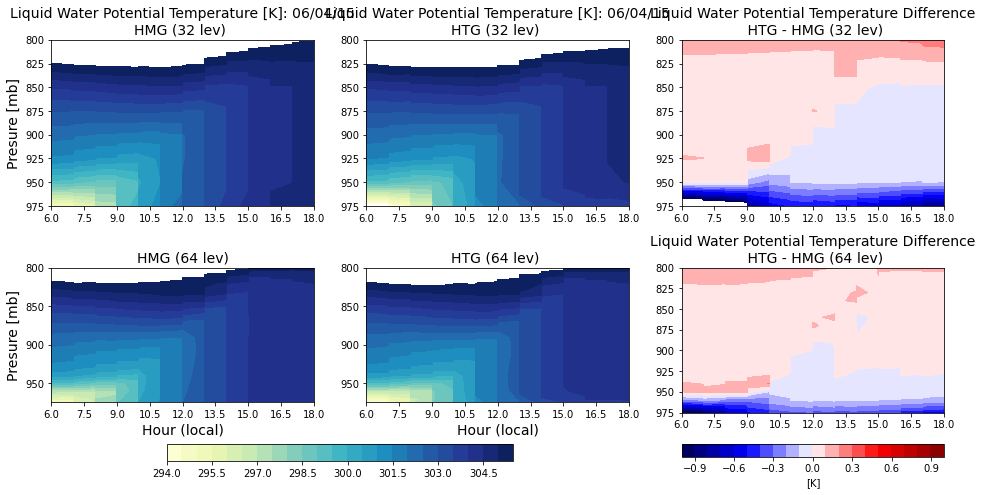

In [71]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs_all = plt.subplots(2,3, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

#Tlevs = np.arange(0.0020,0.01,0.0005)
Tlevs = np.arange(294,306,0.5)
Tdiff_levs = np.arange(-1,1.1,0.1)
#Qlevs = np.arange(3.0,11.0,0.5)
#Qdiff_levs = np.arange(-0.6,0.65,0.05)

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(np.squeeze(THETAL_hmg32[timeSel,:,:,:])), Tlevs,
                      cmap='YlGnBu')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('Liquid Water Potential Temperature [K]: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(np.squeeze(THETAL_htg32[timeSel,:,:,:])), Tlevs,
                      cmap='YlGnBu')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('Liquid Water Potential Temperature [K]: 06/04/15\nHTG (32 lev) ', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel
diff_32 = ((np.squeeze(THETAL_htg32[timeSel,:,:,:])) - (np.squeeze(THETAL_hmg32[timeSel,:,:,:])))
cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(diff_32), Tdiff_levs,
                      cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title('Liquid Water Potential Temperature Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()


# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(np.squeeze(THETAL_hmg64[timeSel,:,:,:])), Tlevs,
                       cmap='YlGnBu')
axs[3].set_ylim([800,975])

axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,)

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(np.squeeze(THETAL_htg64[timeSel,:,:,:])), Tlevs,
                      cmap='YlGnBu')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev) ', fontsize=14)
axs[4].invert_yaxis()

# Plot difference in third panel
diff_128 = ((np.squeeze(THETAL_htg64[timeSel,:,:,:])) - (np.squeeze(THETAL_hmg64[timeSel,:,:,:])))
cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_128), Tdiff_levs,
                      cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('Liquid Water Potential Temperature Difference\n HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = '[K]')


# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])


(6.0, 18.0)

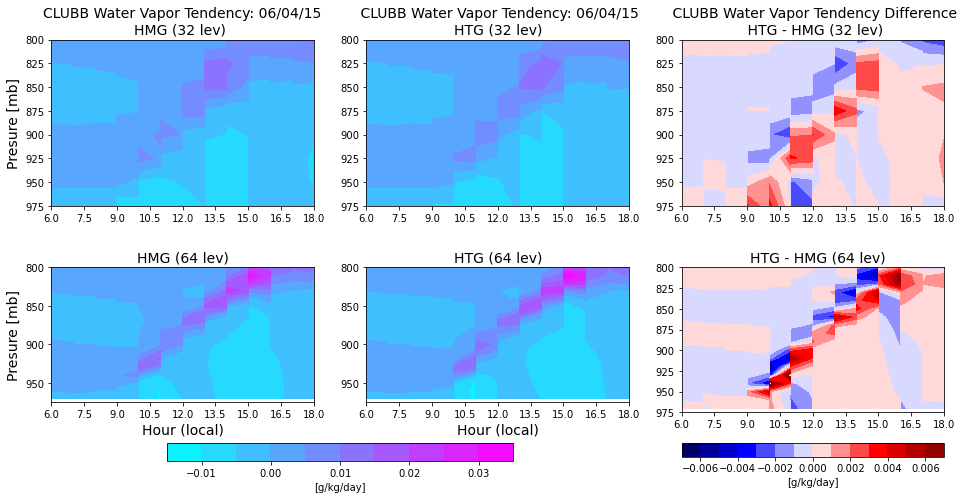

In [56]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

#Tlevs = np.arange(0.0020,0.01,0.0005)
#Qlevs = np.arange(3.0,11.0,0.5)
#RVMlevs = np.arange(-5,35,5)
RVMlevs      = np.arange(-0.015,0.04,0.005)
RVMdiff_levs = np.arange(-0.007,0.0075,0.001)

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(RVMTEND_hmg32[timeSel,:,:,:])*86400.0), 
                       RVMlevs,
                       cmap='cool')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Water Vapor Tendency: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(RVMTEND_htg32[timeSel,:,:,:])*86400.0), 
                       RVMlevs,
                       cmap='cool')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Water Vapor Tendency: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32    = ((np.squeeze(RVMTEND_htg32[timeSel,:,:,:])*86400.0) - (np.squeeze(RVMTEND_hmg32[timeSel,:,:,:])*86400.0))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          RVMdiff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Water Vapor Tendency Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(RVMTEND_hmg64[timeSel,:,:,:])*86400.0), 
                       RVMlevs,
                       cmap='cool')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='[g/kg/day]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(RVMTEND_htg64[timeSel,:,:,:])*86400.0), 
                       RVMlevs,
                       cmap='cool')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64    = ((np.squeeze(RVMTEND_htg64[timeSel,:,:,:])*86400.0) - (np.squeeze(RVMTEND_hmg64[timeSel,:,:,:])*86400.0))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                          np.transpose(diff_64), 
                          RVMdiff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = '[g/kg/day]')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])



(6.0, 18.0)

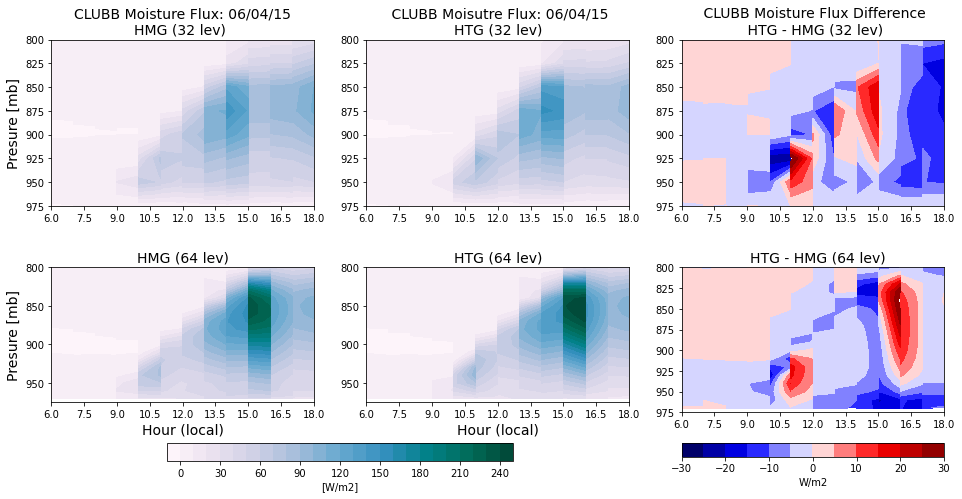

In [63]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

WPRTPlevs      = np.arange(-10,260,10)
#WPRTPlevs      = 20
WPRTPdiff_levs = np.arange(-30,35,5)
#WPRTPdiff_levs = 20

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(WPRTP_hmg32[timeSel,:,:,:])), 
                       WPRTPlevs,
                       cmap='PuBuGn')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Moisture Flux: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(WPRTP_htg32[timeSel,:,:,:])), 
                       WPRTPlevs,
                       cmap='PuBuGn')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Moisutre Flux: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32    = ((np.squeeze(WPRTP_htg32[timeSel,:,:,:])) - (np.squeeze(WPRTP_hmg32[timeSel,:,:,:])))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          WPRTPdiff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Moisture Flux Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(WPRTP_hmg64[timeSel,:,:,:])), 
                       WPRTPlevs,
                       cmap='PuBuGn')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='[W/m2]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(WPRTP_htg64[timeSel,:,:,:])), 
                       WPRTPlevs,
                       cmap='PuBuGn')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64 = ((np.squeeze(WPRTP_htg64[timeSel,:,:,:])) - (np.squeeze(WPRTP_hmg64[timeSel,:,:,:])))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_64), 
                          WPRTPdiff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = 'W/m2')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])



(6.0, 18.0)

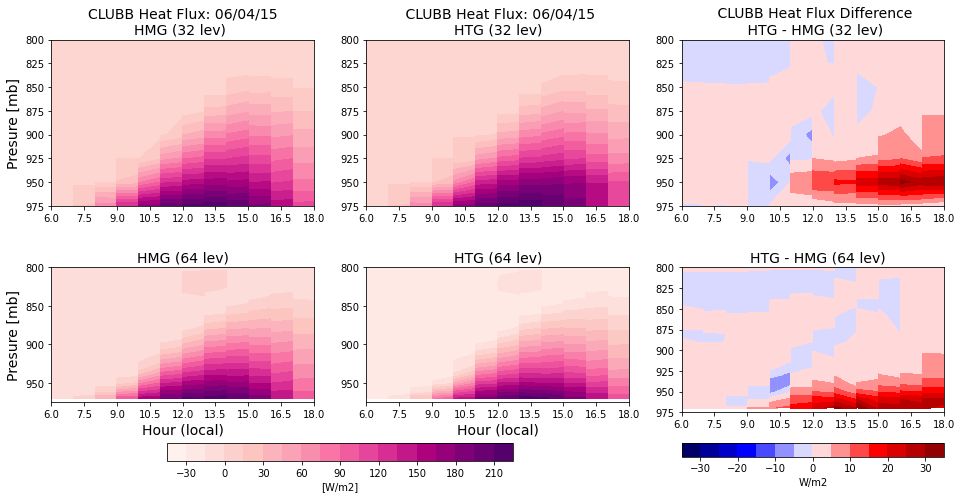

In [67]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

WWPTHLPlevs  = np.arange(-30,230,30)
#WPTHLPlevs      = 20
WPTHLPdiff_levs = np.arange(-35,40,5)
#WPTHLPdiff_levs = 20

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(WPTHLP_hmg32[timeSel,:,:,:])), 
                       WPTHLPlevs,
                       cmap='RdPu')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Heat Flux: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(WPTHLP_htg32[timeSel,:,:,:])), 
                       WPTHLPlevs,
                       cmap='RdPu')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Heat Flux: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32    = ((np.squeeze(WPTHLP_htg32[timeSel,:,:,:])) - (np.squeeze(WPTHLP_hmg32[timeSel,:,:,:])))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          WPTHLPdiff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Heat Flux Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(WPTHLP_hmg64[timeSel,:,:,:])), 
                       WPTHLPlevs,
                       cmap='RdPu')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='[W/m2]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(WPTHLP_htg64[timeSel,:,:,:])), 
                       WPTHLPlevs,
                       cmap='RdPu')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64 = ((np.squeeze(WPTHLP_htg64[timeSel,:,:,:])) - (np.squeeze(WPTHLP_hmg64[timeSel,:,:,:])))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_64), 
                          WPTHLPdiff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = 'W/m2')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])




(6.0, 18.0)

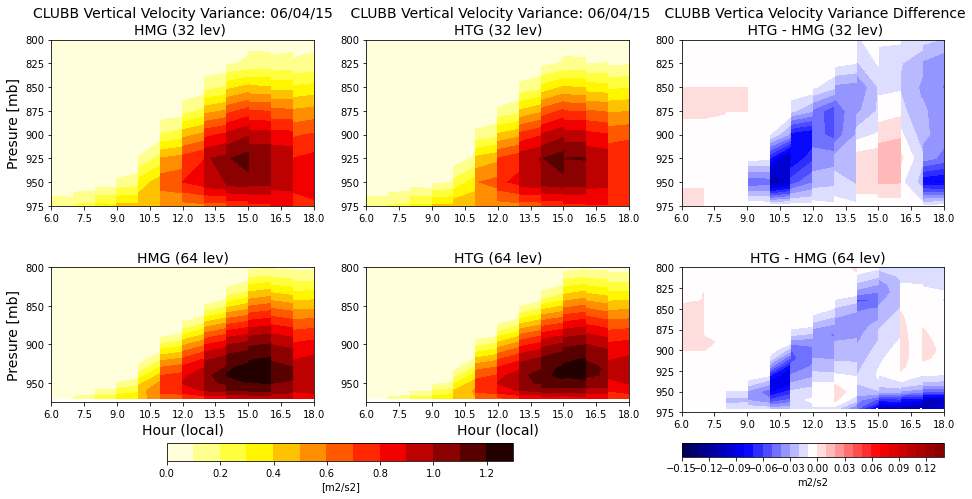

In [71]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

WP2levs  = np.arange(0,1.4,0.1)
#WP2levs      = 20
WP2diff_levs = np.arange(-.15,0.15,0.01)
#WP2diff_levs = 20

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(WP2_hmg32[timeSel,:,:,:])), 
                       WP2levs,
                       cmap='hot_r')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Vertical Velocity Variance: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(WP2_htg32[timeSel,:,:,:])), 
                       WP2levs,
                       cmap='hot_r')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Vertical Velocity Variance: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32    = ((np.squeeze(WP2_htg32[timeSel,:,:,:])) - (np.squeeze(WP2_hmg32[timeSel,:,:,:])))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          WP2diff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Vertica Velocity Variance Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(WP2_hmg64[timeSel,:,:,:])), 
                       WP2levs,
                       cmap='hot_r')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='[m2/s2]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(WP2_htg64[timeSel,:,:,:])), 
                       WP2levs,
                       cmap='hot_r')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64 = ((np.squeeze(WP2_htg64[timeSel,:,:,:])) - (np.squeeze(WP2_hmg64[timeSel,:,:,:])))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_64), 
                          WP2diff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = 'm2/s2')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])





(6.0, 18.0)

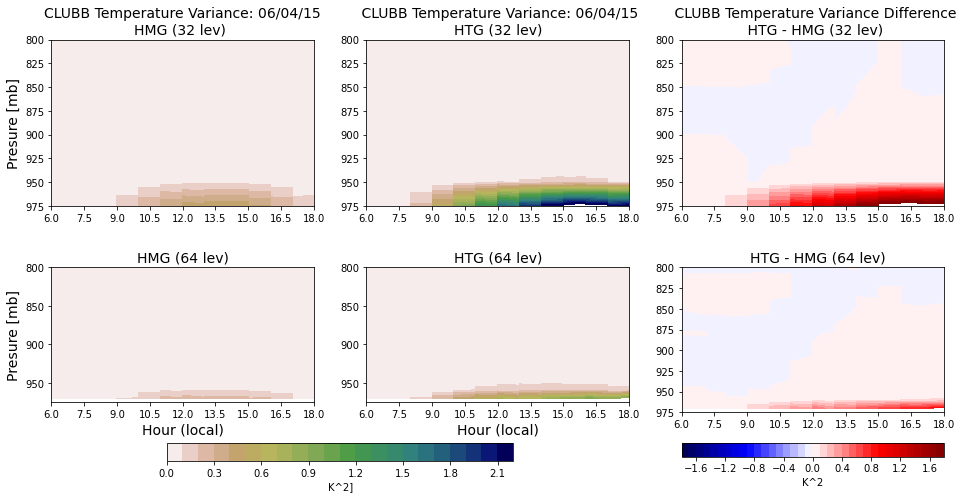

In [96]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

THLP2levs  = np.arange(0.0,2.3,0.1)
#THLP2levs      = 20
THLP2diff_levs = np.arange(-1.8,1.9,0.1)
#THLP2diff_levs = 20

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(THLP2_hmg32[timeSel,:,:,:])), 
                       THLP2levs,
                       cmap='gist_earth_r')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Temperature Variance: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(THLP2_htg32[timeSel,:,:,:])), 
                       THLP2levs,
                       cmap='gist_earth_r')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Temperature Variance: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32    = ((np.squeeze(THLP2_htg32[timeSel,:,:,:])) - (np.squeeze(THLP2_hmg32[timeSel,:,:,:])))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          THLP2diff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Temperature Variance Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(THLP2_hmg64[timeSel,:,:,:])), 
                       THLP2levs,
                       cmap='gist_earth_r')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='K^2]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(THLP2_htg64[timeSel,:,:,:])), 
                       THLP2levs,
                       cmap='gist_earth_r')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64 = ((np.squeeze(THLP2_htg64[timeSel,:,:,:])) - (np.squeeze(THLP2_hmg64[timeSel,:,:,:])))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_64), 
                          THLP2diff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = 'K^2')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])



(6.0, 18.0)

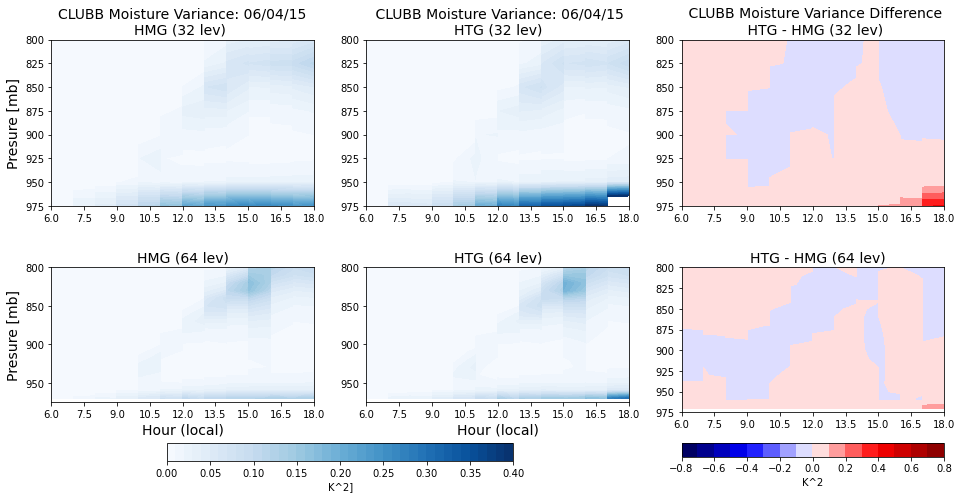

In [108]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

RTP2levs  = np.arange(0.0,0.41,0.01)
#RTP2levs      = 20
RTP2diff_levs = np.arange(-0.8,0.9,0.1)
#RTP2diff_levs = 20

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(RTP2_hmg32[timeSel,:,:,:])), 
                       RTP2levs,
                       cmap='Blues')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Moisture Variance: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(RTP2_htg32[timeSel,:,:,:])), 
                       RTP2levs,
                       cmap='Blues')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Moisture Variance: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32 = ((np.squeeze(RTP2_htg32[timeSel,:,:,:])) - (np.squeeze(RTP2_hmg32[timeSel,:,:,:])))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          RTP2diff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Moisture Variance Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(RTP2_hmg64[timeSel,:,:,:])), 
                       RTP2levs,
                       cmap='Blues')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='K^2]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(RTP2_htg64[timeSel,:,:,:])), 
                       RTP2levs,
                       cmap='Blues')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64 = ((np.squeeze(RTP2_htg64[timeSel,:,:,:])) - (np.squeeze(RTP2_hmg64[timeSel,:,:,:])))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_64), 
                          RTP2diff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = 'K^2')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])



In [105]:
hmg32_DS.UP2_CLUBB

<xarray.DataArray 'UP2_CLUBB' (time: 217, ilev: 33, lat: 1, lon: 1)>
array([[[[4.000000e-04]],

        ...,

        [[6.211907e-01]]],


       ...,


       [[[4.000000e-04]],

        ...,

        [[1.167444e+00]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 36.61
  * lon      (lon) float64 262.5
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
  * time     (time) datetime64[ns] 2015-06-29 2015-06-29T00:20:00 ... 2015-07-02
Attributes:
    mdims:         2
    units:         m2/s2
    long_name:     Zonal Velocity Variance
    cell_methods:  time: mean

(6.0, 18.0)

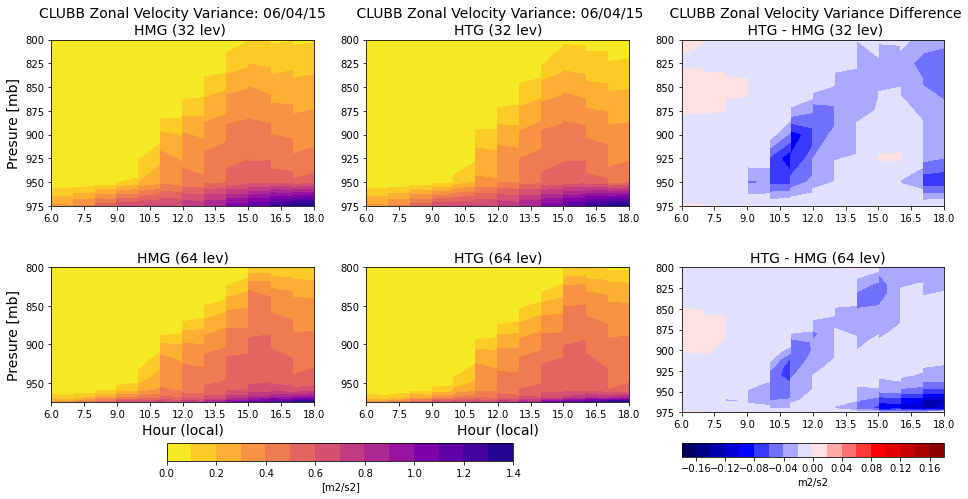

In [110]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

UP2levs  = np.arange(0,1.5,0.1)
#UP2levs      = 20
UP2diff_levs = np.arange(-0.18,0.20,0.02)
#UP2diff_levs = 20

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(UP2_hmg32[timeSel,:,:,:])), 
                       UP2levs,
                       cmap='plasma_r')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Zonal Velocity Variance: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(UP2_htg32[timeSel,:,:,:])), 
                       UP2levs,
                       cmap='plasma_r')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Zonal Velocity Variance: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32    = ((np.squeeze(UP2_htg32[timeSel,:,:,:])) - (np.squeeze(UP2_hmg32[timeSel,:,:,:])))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          UP2diff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Zonal Velocity Variance Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(UP2_hmg64[timeSel,:,:,:])), 
                       UP2levs,
                       cmap='plasma_r')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='[m2/s2]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(UP2_htg64[timeSel,:,:,:])), 
                       UP2levs,
                       cmap='plasma_r')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64 = ((np.squeeze(UP2_htg64[timeSel,:,:,:])) - (np.squeeze(UP2_hmg64[timeSel,:,:,:])))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_64), 
                          UP2diff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = 'm2/s2')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])






**Morning profiles...**

In [12]:
timeSel     = np.where((timesHMG_32local.day==4) & (timesHMG_32local.hour>=8) & (timesHMG_32local.hour<10))[0]

hmgDS_32sel = hmgDS_32.isel(time=timeSel)
htgDS_32sel = htgDS_32.isel(time=timeSel)
noMom_sel   = noMomDS.isel(time=timeSel)
hmgDS_64sel = hmgDS_64.isel(time=timeSel)
htgDS_64sel = htgDS_64.isel(time=timeSel)

timeSel_nate = np.where((timesNate_local.year==2015) & (timesNate_local.month==6) & (timesNate_local.day==4) & 
                       (timesNate_local.hour>=8) & (timesNate_local.hour<10))[0]
nateHMG_sel  = nateHMG.isel(time=timeSel_nate)

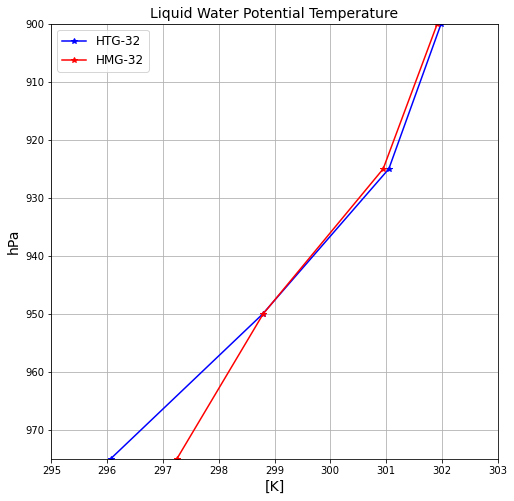

In [42]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 8), 
                     facecolor='w', edgecolor='k')

ax1.plot(np.nanmean(np.squeeze(THETAL_htg32[timeSel,:,:,:]),axis=0),pnew32,'b-*',                      label='HTG-32')
#ax1.plot(np.nanmean(np.squeeze(THETAL_htg64[timeSel,:,:,:]),axis=0),pnew64,'-*',color='cornflowerblue',label='HTG-64')

ax1.plot(np.nanmean(np.squeeze(THETAL_hmg32[timeSel,:,:,:]),axis=0),pnew32,'r-*',              label='HMG-32')
#ax1.plot(np.nanmean(np.squeeze(THETAL_hmg64[timeSel,:,:,:]),axis=0),pnew64,'-*',color='orange',label='HMG-64')

ax1.legend(fontsize=12)
ax1.set_ylim([900,975])
ax1.set_xlim([295,303])
ax1.set_title('Liquid Water Potential Temperature', fontsize=14)
ax1.set_ylabel('hPa',fontsize=14)
ax1.set_xlabel('[K]',fontsize=14)



plt.gca().invert_yaxis()
plt.grid()



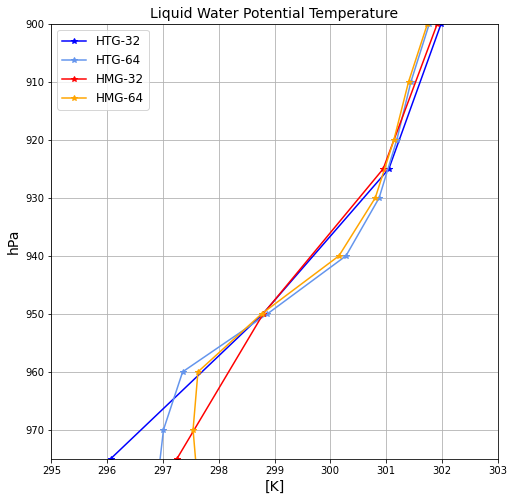

In [43]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 8), 
                     facecolor='w', edgecolor='k')

ax1.plot(np.nanmean(np.squeeze(THETAL_htg32[timeSel,:,:,:]),axis=0),pnew32,'b-*',                      label='HTG-32')
ax1.plot(np.nanmean(np.squeeze(THETAL_htg64[timeSel,:,:,:]),axis=0),pnew64,'-*',color='cornflowerblue',label='HTG-64')

ax1.plot(np.nanmean(np.squeeze(THETAL_hmg32[timeSel,:,:,:]),axis=0),pnew32,'r-*',              label='HMG-32')
ax1.plot(np.nanmean(np.squeeze(THETAL_hmg64[timeSel,:,:,:]),axis=0),pnew64,'-*',color='orange',label='HMG-64')

ax1.legend(fontsize=12)
ax1.set_ylim([900,975])
ax1.set_xlim([295,303])
ax1.set_title('Liquid Water Potential Temperature', fontsize=14)
ax1.set_ylabel('hPa',fontsize=14)
ax1.set_xlabel('[K]',fontsize=14)

plt.gca().invert_yaxis()
plt.grid()




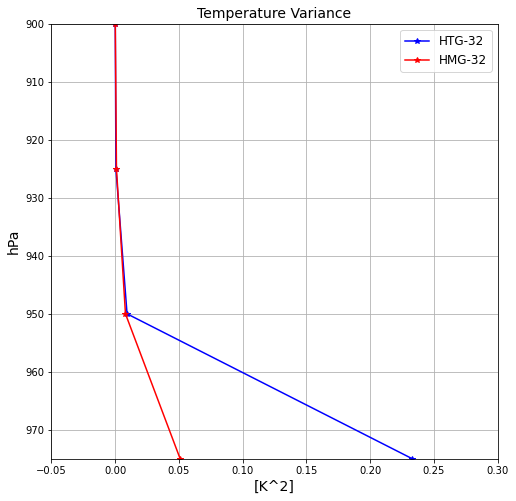

In [52]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 8), 
                     facecolor='w', edgecolor='k')

ax1.plot(np.nanmean(np.squeeze(THLP2_htg32[timeSel,:,:,:]),axis=0),pnew32,'b-*',                      label='HTG-32')
#ax1.plot(np.nanmean(np.squeeze(THLP2_htg64[timeSel,:,:,:]),axis=0),pnew64,'-*',color='cornflowerblue',label='HTG-64')

ax1.plot(np.nanmean(np.squeeze(THLP2_hmg32[timeSel,:,:,:]),axis=0),pnew32,'r-*',              label='HMG-32')
#ax1.plot(np.nanmean(np.squeeze(THLP2__hmg64[timeSel,:,:,:]),axis=0),pnew64,'-*',color='orange',label='HMG-64')

ax1.legend(fontsize=12)
ax1.set_ylim([900,975])
ax1.set_xlim([-0.05,0.3])
ax1.set_title('Temperature Variance', fontsize=14)
ax1.set_ylabel('hPa',fontsize=14)
ax1.set_xlabel('[K^2]',fontsize=14)



plt.gca().invert_yaxis()
plt.grid()




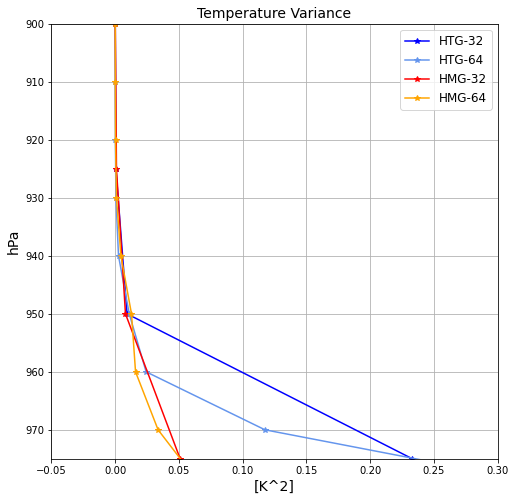

In [54]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 8), 
                     facecolor='w', edgecolor='k')

ax1.plot(np.nanmean(np.squeeze(THLP2_htg32[timeSel,:,:,:]),axis=0),pnew32,'b-*',                      label='HTG-32')
ax1.plot(np.nanmean(np.squeeze(THLP2_htg64[timeSel,:,:,:]),axis=0),pnew64,'-*',color='cornflowerblue',label='HTG-64')

ax1.plot(np.nanmean(np.squeeze(THLP2_hmg32[timeSel,:,:,:]),axis=0),pnew32,'r-*',              label='HMG-32')
ax1.plot(np.nanmean(np.squeeze(THLP2_hmg64[timeSel,:,:,:]),axis=0),pnew64,'-*',color='orange',label='HMG-64')

ax1.legend(fontsize=12)
ax1.set_ylim([900,975])
ax1.set_xlim([-0.05,0.3])
ax1.set_title('Temperature Variance', fontsize=14)
ax1.set_ylabel('hPa',fontsize=14)
ax1.set_xlabel('[K^2]',fontsize=14)

plt.gca().invert_yaxis()
plt.grid()





In [60]:
htg32_DS.Q

<xarray.DataArray 'Q' (time: 217, lev: 32, lat: 1, lon: 1)>
array([[[[2.739138e-09]],

        ...,

        [[1.028702e-02]]],


       ...,


       [[[1.271991e-08]],

        ...,

        [[6.714925e-03]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 36.61
  * lon      (lon) float64 262.5
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) datetime64[ns] 2015-06-28 2015-06-28T00:20:00 ... 2015-07-01
Attributes:
    mdims:         1
    units:         kg/kg
    mixing_ratio:  wet
    long_name:     Specific humidity
    cell_methods:  time: mean

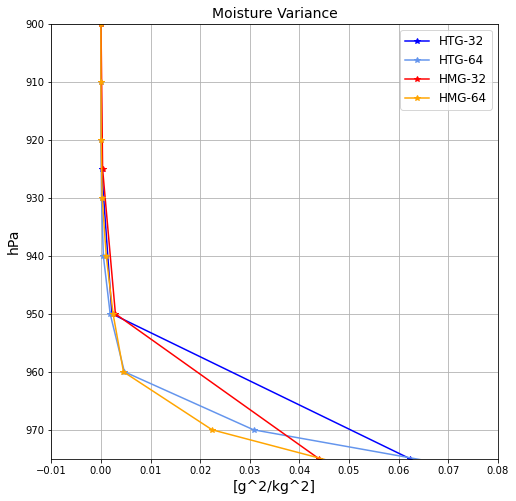

In [58]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 8), 
                     facecolor='w', edgecolor='k')

ax1.plot(np.nanmean(np.squeeze(RTP2_htg32[timeSel,:,:,:]),axis=0),pnew32,'b-*',                      label='HTG-32')
ax1.plot(np.nanmean(np.squeeze(RTP2_htg64[timeSel,:,:,:]),axis=0),pnew64,'-*',color='cornflowerblue',label='HTG-64')

ax1.plot(np.nanmean(np.squeeze(RTP2_hmg32[timeSel,:,:,:]),axis=0),pnew32,'r-*',              label='HMG-32')
ax1.plot(np.nanmean(np.squeeze(RTP2_hmg64[timeSel,:,:,:]),axis=0),pnew64,'-*',color='orange',label='HMG-64')

ax1.legend(fontsize=12)
ax1.set_ylim([900,975])
ax1.set_xlim([-0.01,0.08])
ax1.set_title('Moisture Variance', fontsize=14)
ax1.set_ylabel('hPa',fontsize=14)
ax1.set_xlabel('[g^2/kg^2]',fontsize=14)


plt.gca().invert_yaxis()
plt.grid()


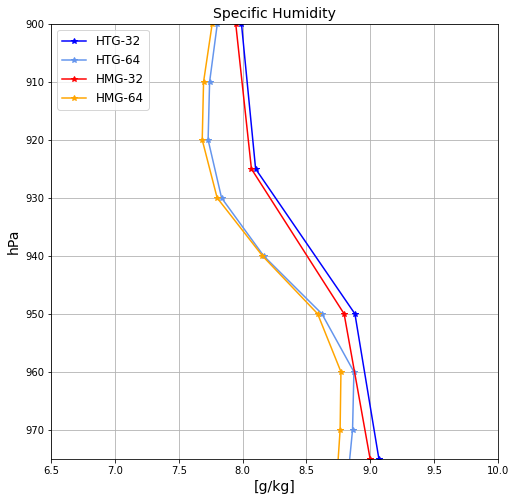

In [181]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 8), 
                     facecolor='w', edgecolor='k')

ax1.plot(np.nanmean(np.squeeze(Q_htg32[timeSel,:,:,:])*1000.,axis=0),pnew32,'b-*',                      label='HTG-32')
ax1.plot(np.nanmean(np.squeeze(Q_htg64[timeSel,:,:,:])*1000.,axis=0),pnew64,'-*',color='cornflowerblue',label='HTG-64')

ax1.plot(np.nanmean(np.squeeze(Q_hmg32[timeSel,:,:,:])*1000.,axis=0),pnew32,'r-*',              label='HMG-32')
ax1.plot(np.nanmean(np.squeeze(Q_hmg64[timeSel,:,:,:])*1000.,axis=0),pnew64,'-*',color='orange',label='HMG-64')

# ax2 = ax1.twinx()
# ax2.plot(np.nanmean(np.squeeze(nateHMG_sel.q.values),axis=0), nateHMG_sel.lev.values,'k-*',label='Obs (RAP Analysis)')
# ax2.legend(fontsize=12,loc='upper right')

ax1.legend(fontsize=12,loc='upper left')
ax1.set_ylim([900,975])
ax1.set_xlim([6.5,10])
ax1.set_title('Specific Humidity', fontsize=14)
ax1.set_ylabel('hPa',fontsize=14)
ax1.set_xlabel('[g/kg]',fontsize=14)



plt.gca().invert_yaxis()
plt.grid()







Nate's files have water vapor mixing ratio, which is *similar* to specific humidity but not quite. So to convert model output to mixing ratio, use the equation: w = q/(1-q). 

In [206]:
Q_htg32[timeSel,:,:,:]*1000.0

array([[[[4.02462132]],

        [[4.09352983]],

        [[4.24254998]],

        [[4.73045952]],

        [[5.21836905]],

        [[6.31144044]],

        [[7.34469536]],

        [[7.99971353]],

        [[8.08023312]],

        [[8.16561421]],

        [[8.89600081]],

        [[9.18992822]]],


       [[[3.97693203]],

        [[4.04274188]],

        [[4.19158849]],

        [[4.6502663 ]],

        [[5.10894411]],

        [[6.21172091]],

        [[7.25890339]],

        [[7.94630167]],

        [[8.05613529]],

        [[8.1476022 ]],

        [[8.89809847]],

        [[9.14167889]]],


       [[[3.95516686]],

        [[4.02829111]],

        [[4.16845786]],

        [[4.61959756]],

        [[5.07073726]],

        [[6.09923231]],

        [[7.1162722 ]],

        [[7.83587035]],

        [[7.99298577]],

        [[8.09131346]],

        [[8.86438095]],

        [[9.10163302]]],


       [[[3.90768245]],

        [[3.98008679]],

        [[4.11638773]],

        [[4.5625108

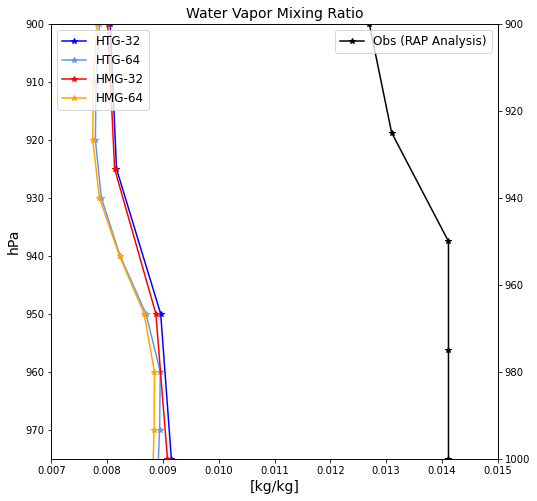

In [215]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 8), 
                     facecolor='w', edgecolor='k')

w_htg32 = (Q_htg32[timeSel,:,:,:])/(1 - (Q_htg32[timeSel,:,:,:]))
w_hmg32 = (Q_hmg32[timeSel,:,:,:])/(1 - (Q_hmg32[timeSel,:,:,:]))
w_htg64 = (Q_htg64[timeSel,:,:,:])/(1 - (Q_htg64[timeSel,:,:,:]))
w_hmg64 = (Q_hmg64[timeSel,:,:,:])/(1 - (Q_hmg64[timeSel,:,:,:]))


ax1.plot(np.nanmean(np.squeeze(w_htg32),axis=0),pnew32,'b-*',                      label='HTG-32')
ax1.plot(np.nanmean(np.squeeze(w_htg64),axis=0),pnew64,'-*',color='cornflowerblue',label='HTG-64')

ax1.plot(np.nanmean(np.squeeze(w_hmg32),axis=0),pnew32,'r-*',              label='HMG-32')
ax1.plot(np.nanmean(np.squeeze(w_hmg64),axis=0),pnew64,'-*',color='orange',label='HMG-64')
ax1.invert_yaxis()

ax2 = ax1.twinx()
ax2.plot(np.nanmean(np.squeeze(nateHMG_sel.q.values/1000.0),axis=0), nateHMG_sel.lev.values,'k-*',label='Obs (RAP Analysis)')
ax2.legend(fontsize=12,loc='upper right')
ax2.set_ylim([1000,900])

ax1.legend(fontsize=12,loc='upper left')
ax1.set_ylim([900,975])
ax1.set_xlim([0.007,0.015])
ax1.set_title('Water Vapor Mixing Ratio', fontsize=14)
ax1.set_ylabel('hPa',fontsize=14)
ax1.set_xlabel('[kg/kg]',fontsize=14)
ax1.invert_yaxis()

# ax2.invert_yaxis()

#plt.gca().invert_yaxis()
#plt.grid()
plt.show()

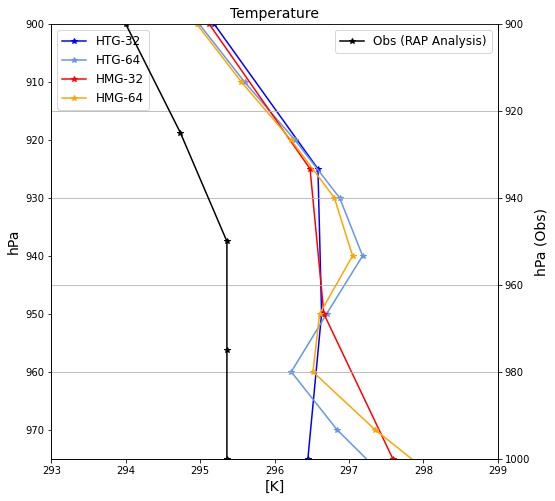

In [225]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 8), 
                     facecolor='w', edgecolor='k')

ax1.plot(np.nanmean(np.squeeze(T_htg32[timeSel,:,:,:]),axis=0),pnew32,'b-*',                      label='HTG-32')
ax1.plot(np.nanmean(np.squeeze(T_htg64[timeSel,:,:,:]),axis=0),pnew64,'-*',color='cornflowerblue',label='HTG-64')

ax1.plot(np.nanmean(np.squeeze(T_hmg32[timeSel,:,:,:]),axis=0),pnew32,'r-*',              label='HMG-32')
ax1.plot(np.nanmean(np.squeeze(T_hmg64[timeSel,:,:,:]),axis=0),pnew64,'-*',color='orange',label='HMG-64')
#ax1.invert_yaxis()

ax2 = ax1.twinx()
ax2.plot(np.nanmean(np.squeeze(nateHMG_sel.T.values),axis=0), nateHMG_sel.lev.values,'k-*',label='Obs (RAP Analysis)')
ax2.legend(fontsize=12,loc='upper right')
ax2.set_ylim([900,1000])
ax2.set_ylabel('hPa (Obs)', fontsize=14)
# ax2.invert_yaxis()

ax1.legend(fontsize=12,loc='upper left')
ax1.set_ylim([900,975])
ax1.set_xlim([293,299])
ax1.set_title('Temperature', fontsize=14)
ax1.set_ylabel('hPa',fontsize=14)
ax1.set_xlabel('[K]',fontsize=14)

plt.gca().invert_yaxis()
plt.grid()
ax1.invert_yaxis()



